In [1]:
  from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [3]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, TimeDistributed
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

user_id activity        timestamp    x_axis     y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.694638  12.680544  0.503953   
1             33  Jogging   49106062271000  5.012288  11.264028  0.953424   
2             33  Jogging   49106112167000  4.903325  10.882658 -0.081722   
3             33  Jogging   49106222305000 -0.612916  18.496431  3.023717   
4             33  Jogging   49106332290000 -1.184970  12.108489  7.205164   
...          ...      ...              ...       ...        ...       ...   
1098200       19  Sitting  131623331483000  9.000000  -1.570000  1.690000   
1098201       19  Sitting  131623371431000  9.040000  -1.460000  1.730000   
1098202       19  Sitting  131623411592000  9.080000  -1.380000  1.690000   
1098203       19  Sitting  131623491487000  9.000000  -1.460000  1.730000   
1098204       19  Sitting  131623531465000  8.880000  -1.330000  1.610000   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[1098204 rows x 7 columns]

<Axes: xlabel='activity', ylabel='count'>

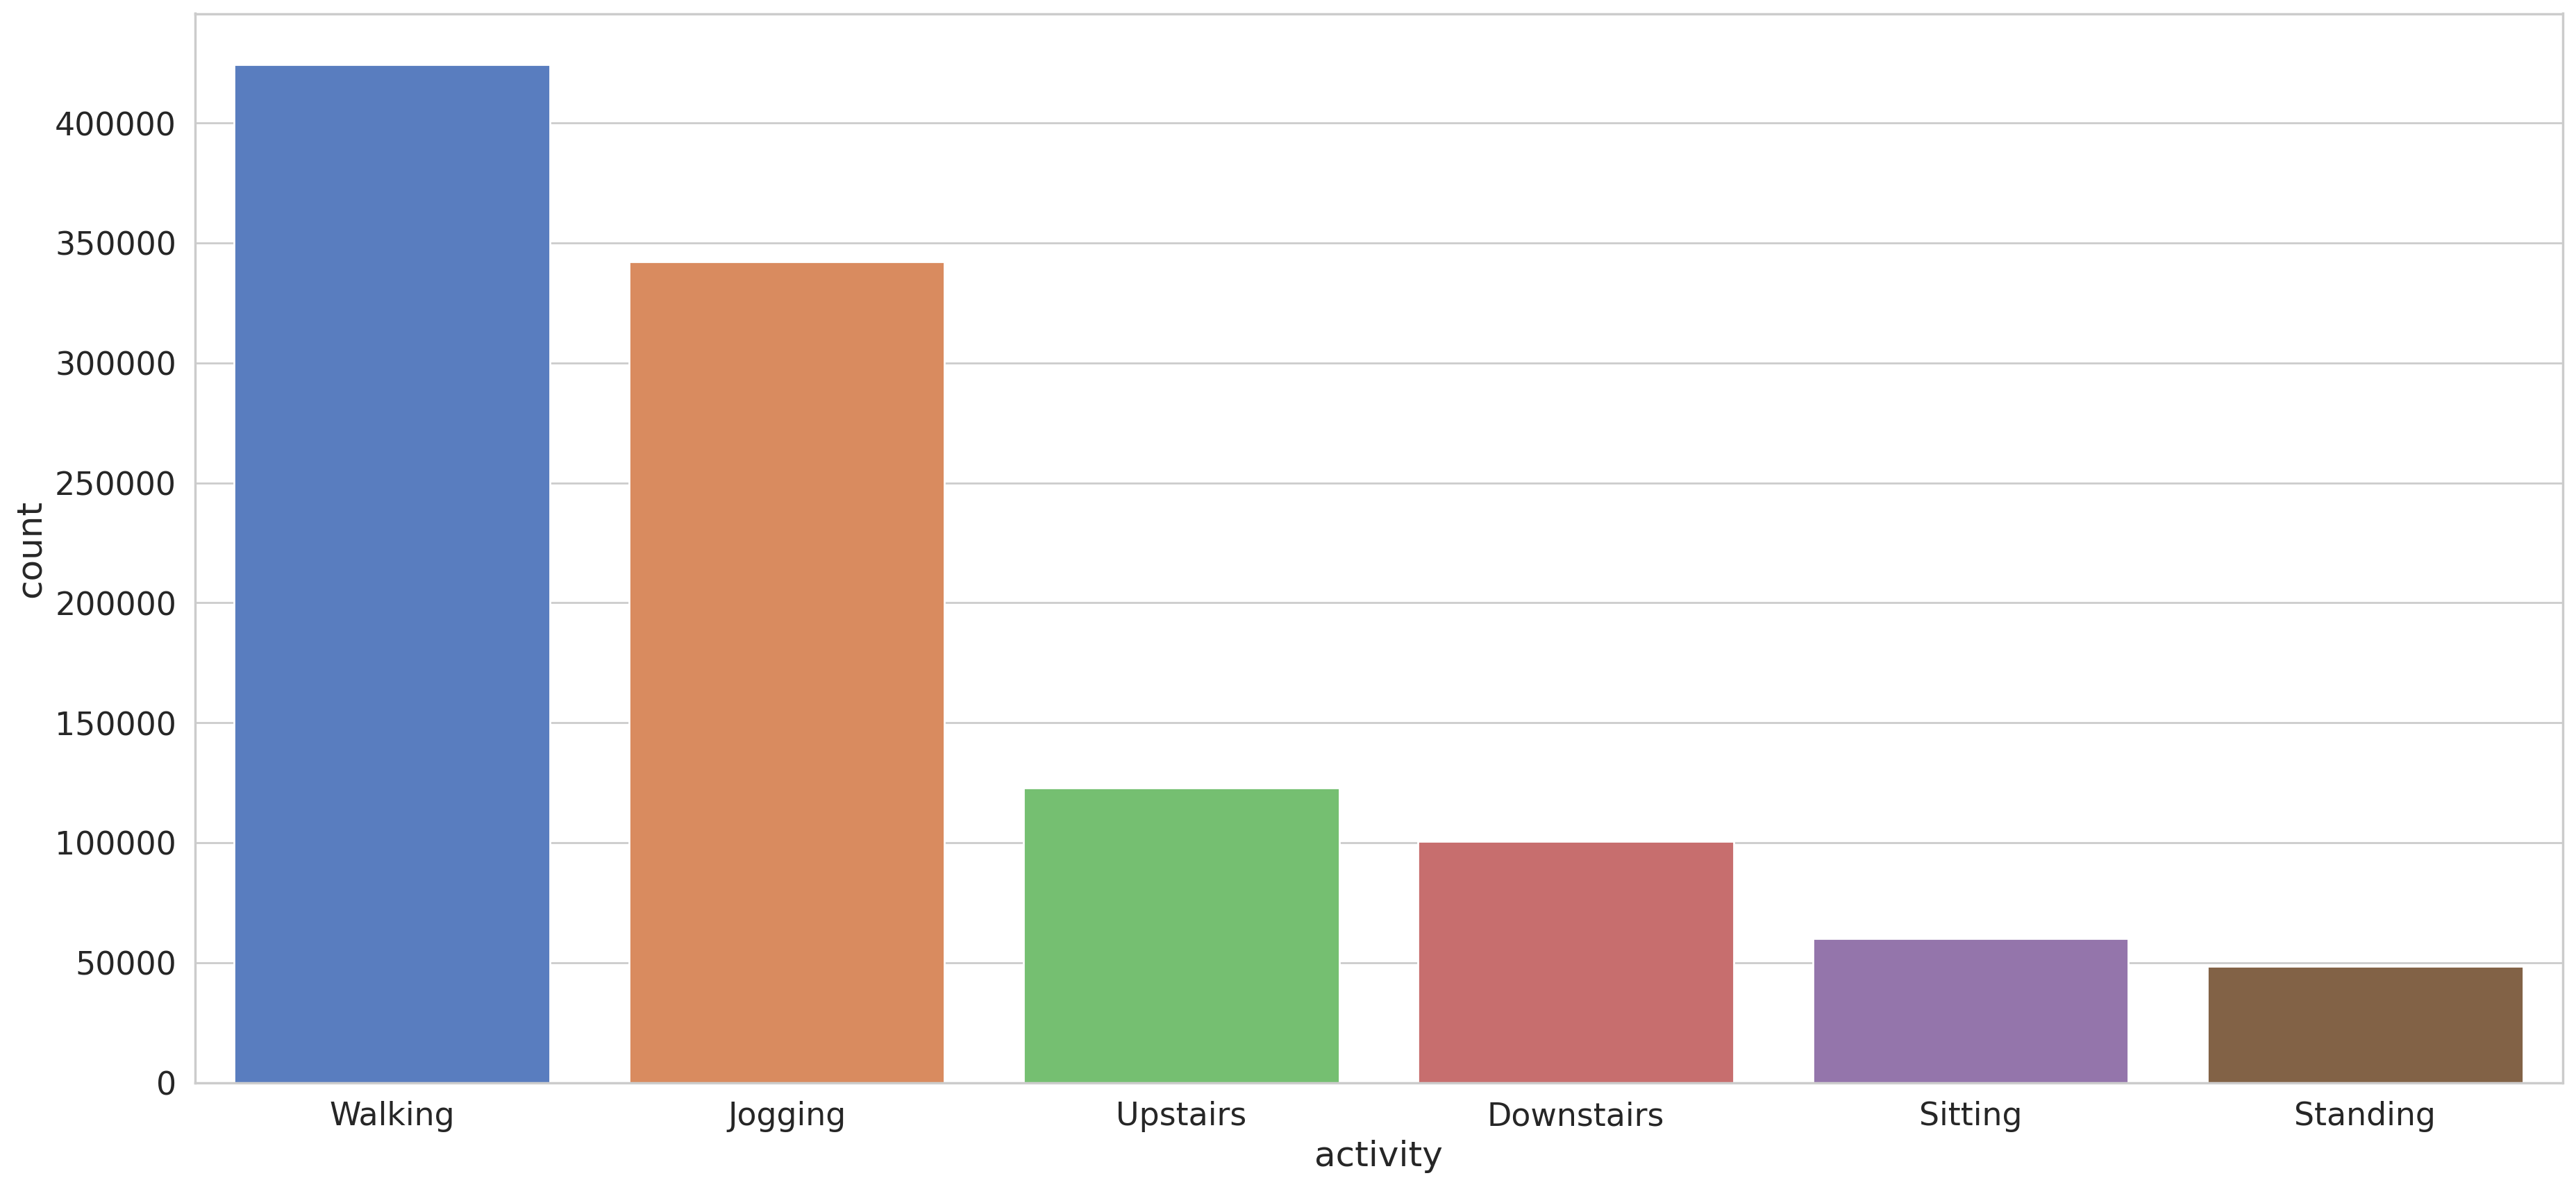

In [6]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

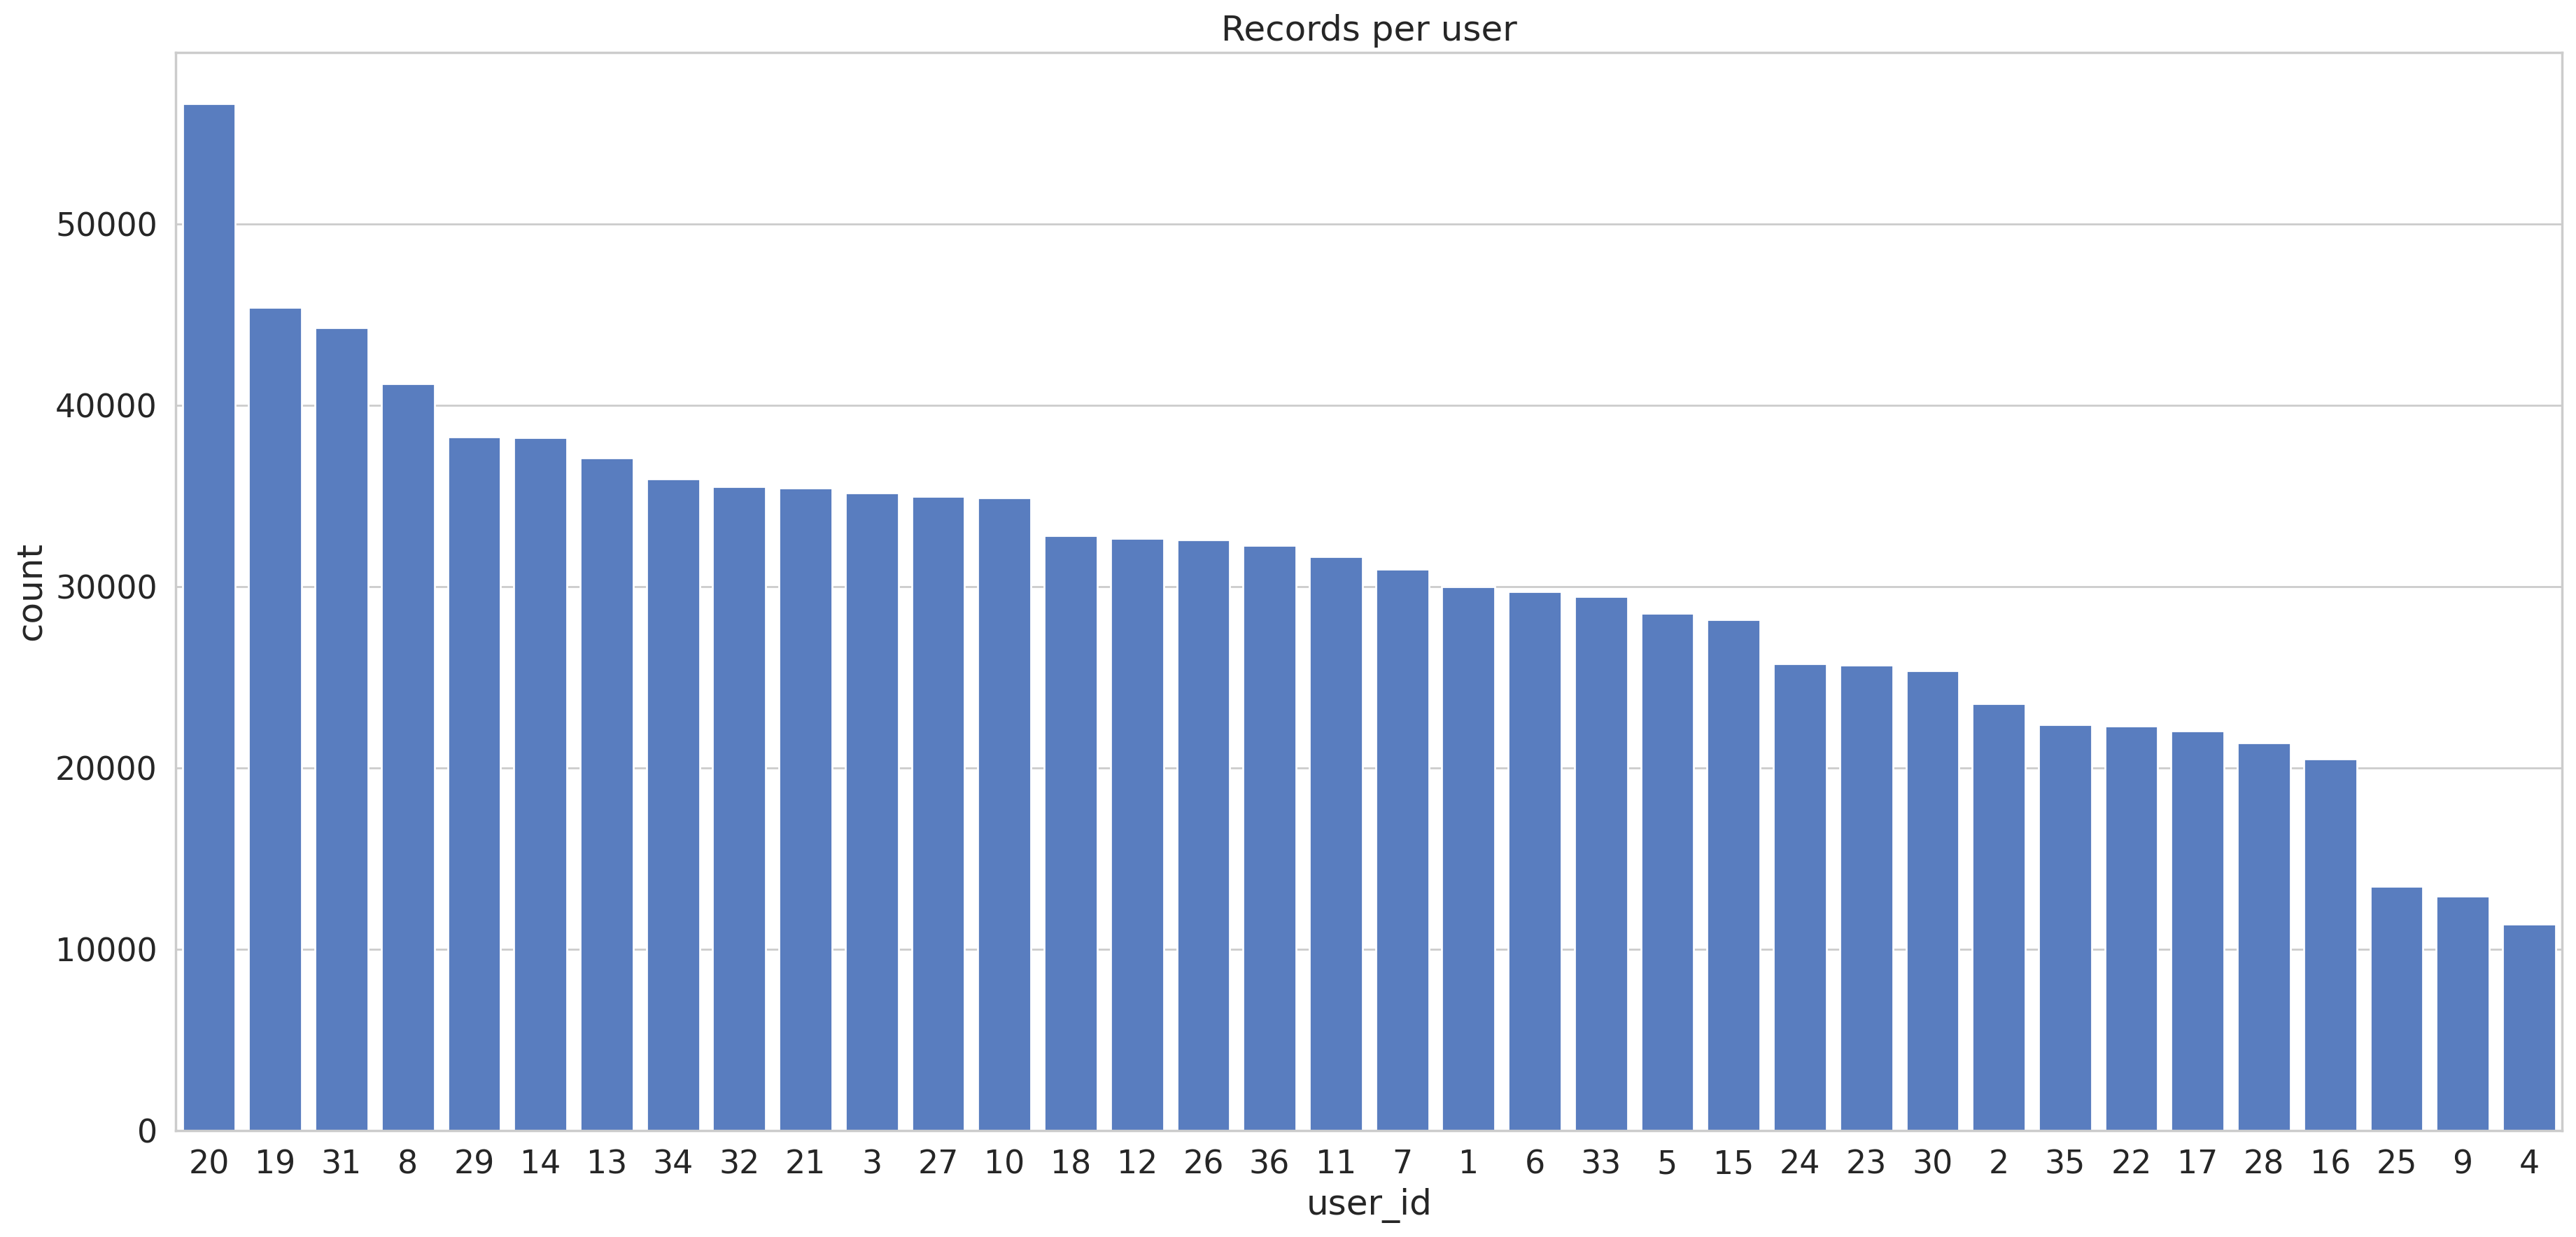

In [7]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


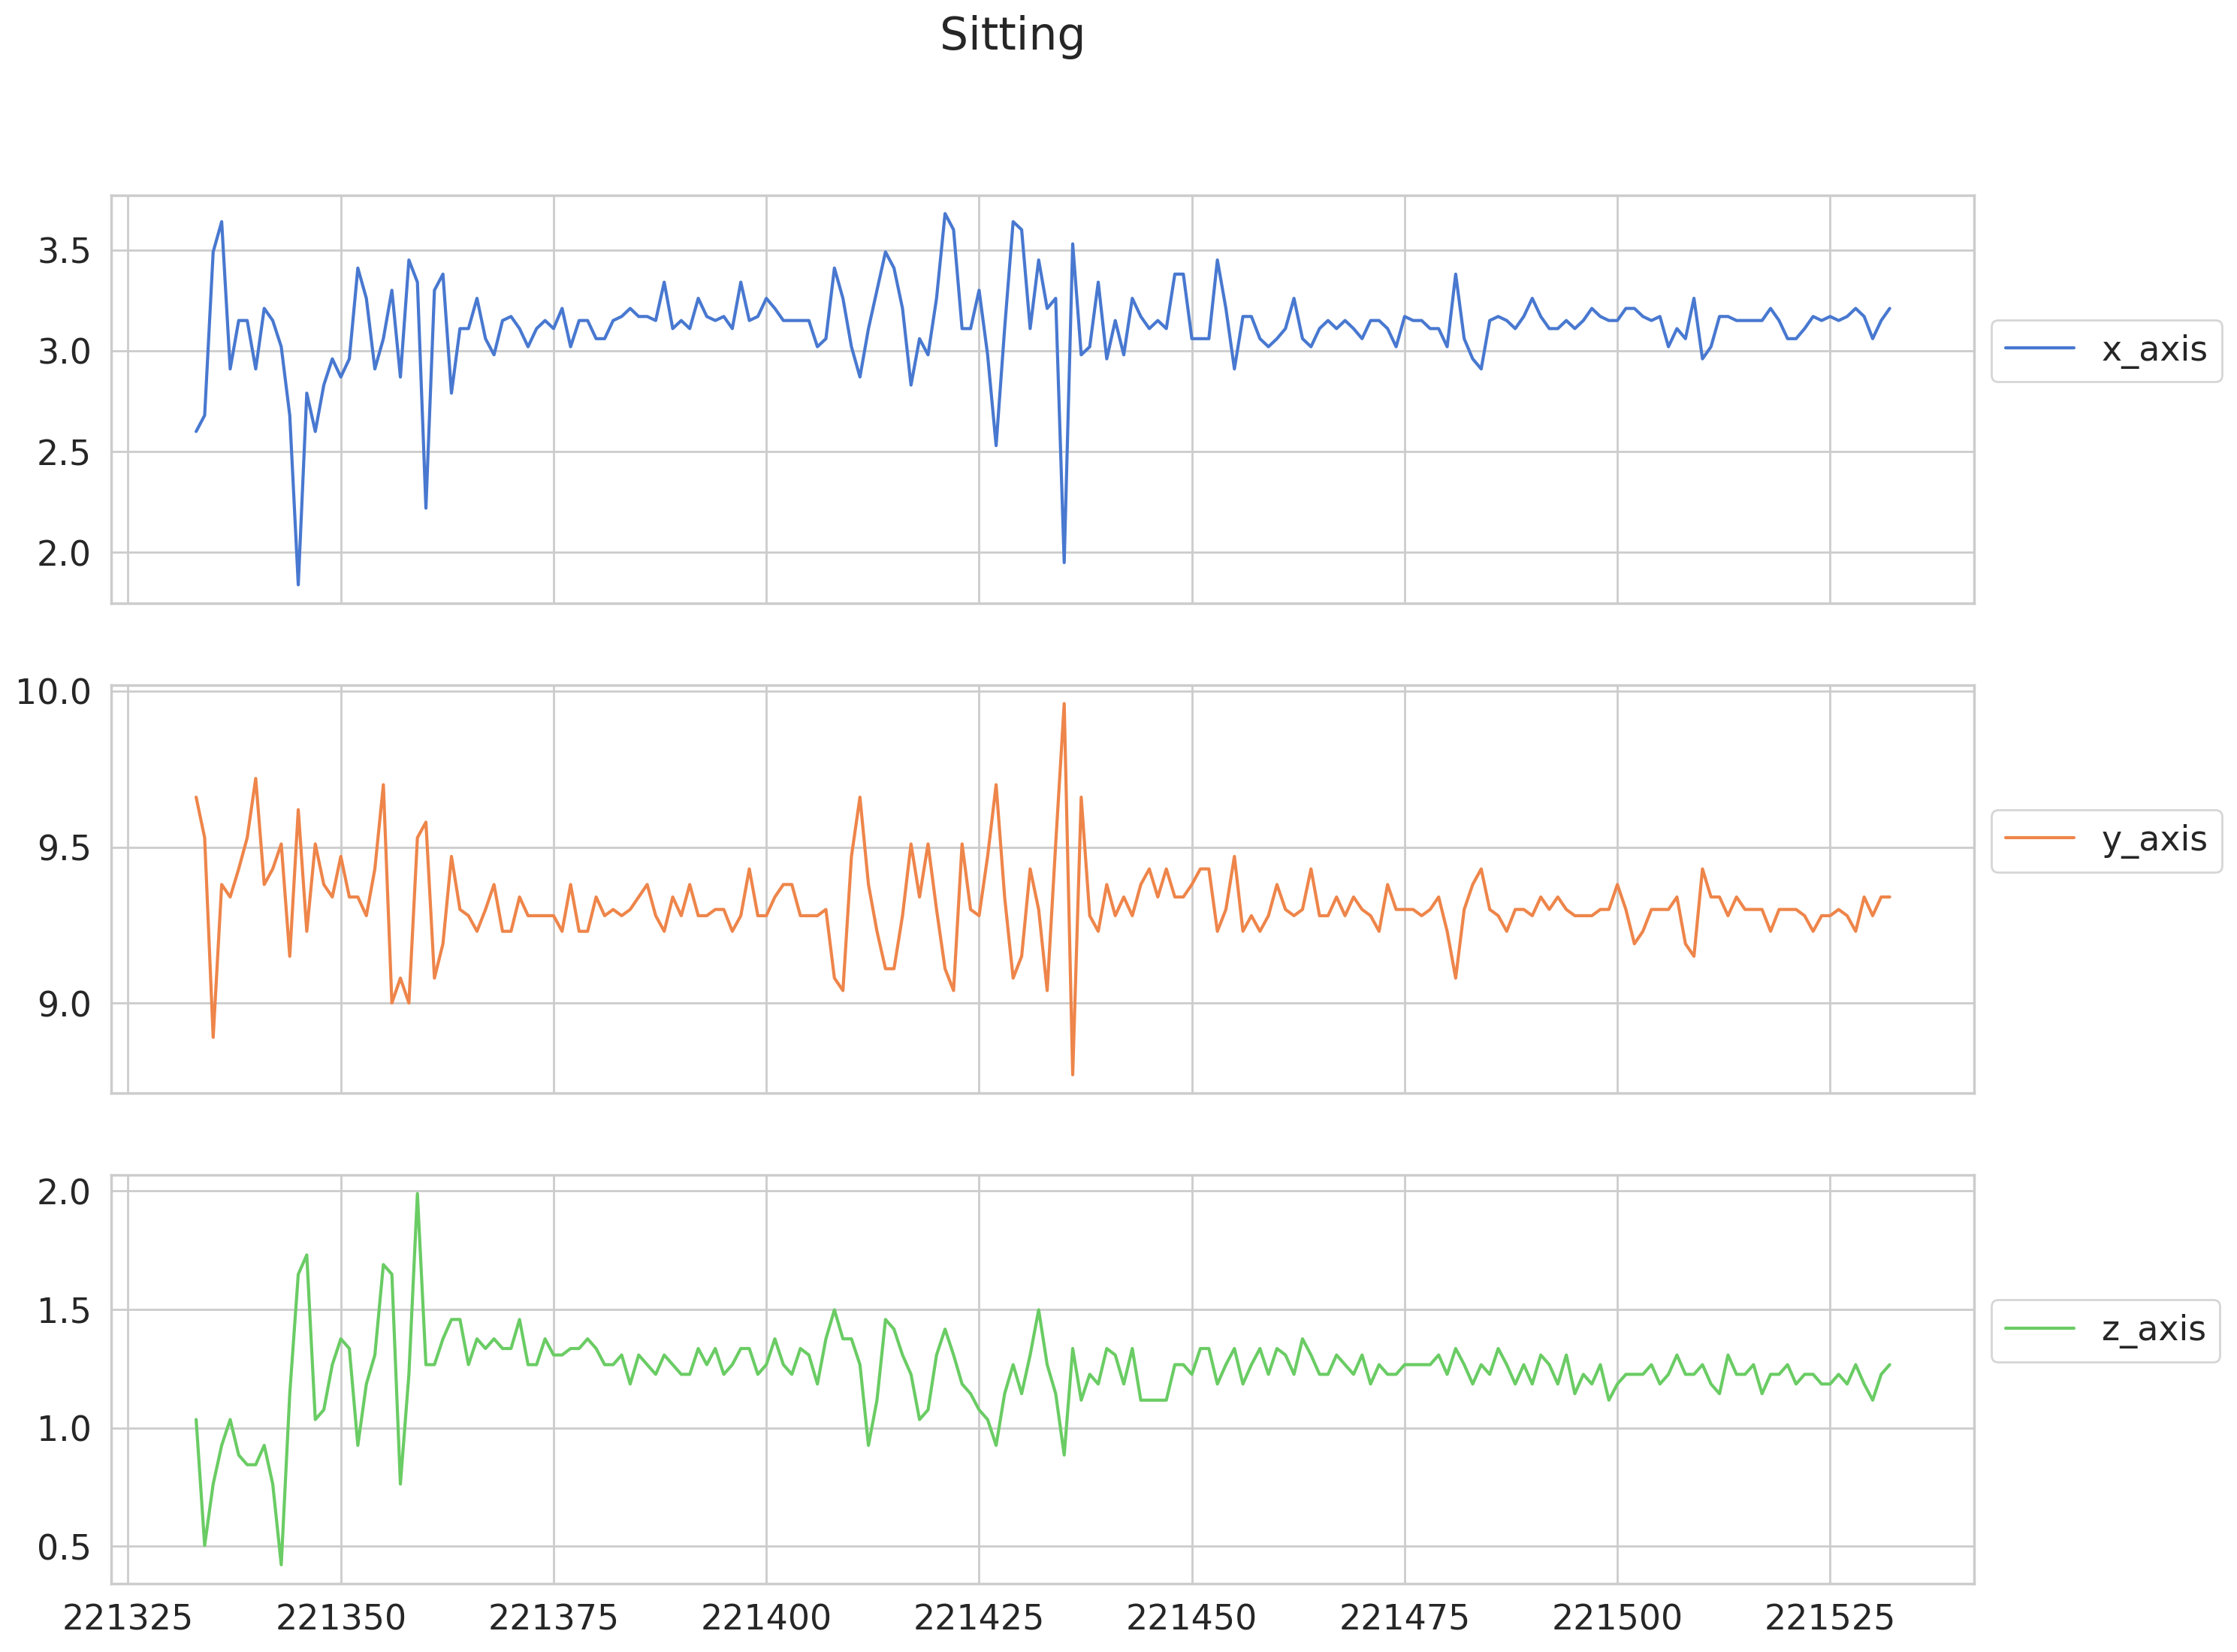

In [8]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [9]:
indexes = df[(df['activity'] != 'Sitting') & (df['activity'] != 'Standing')].index
df.drop(indexes, inplace=True)


In [10]:
df

user_id activity        timestamp  x_axis  y_axis    z_axis  \
221333        27  Sitting   12363992261000    2.60    9.66  1.035146   
221334        27  Sitting   12364042279000    2.68    9.53  0.503953   
221335        27  Sitting   12364092267000    3.49    8.89  0.762740   
221336        27  Sitting   12364142316000    3.64    9.38  0.926184   
221337        27  Sitting   12364192273000    2.91    9.34  1.035146   
...          ...      ...              ...     ...     ...       ...   
1098200       19  Sitting  131623331483000    9.00   -1.57  1.690000   
1098201       19  Sitting  131623371431000    9.04   -1.46  1.730000   
1098202       19  Sitting  131623411592000    9.08   -1.38  1.690000   
1098203       19  Sitting  131623491487000    9.00   -1.46  1.730000   
1098204       19  Sitting  131623531465000    8.88   -1.33  1.610000   

         ActivityEncoded  
221333                 4  
221334                 4  
221335                 4  
221336                 4  
221337                 4  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[108334 rows x 7 columns]

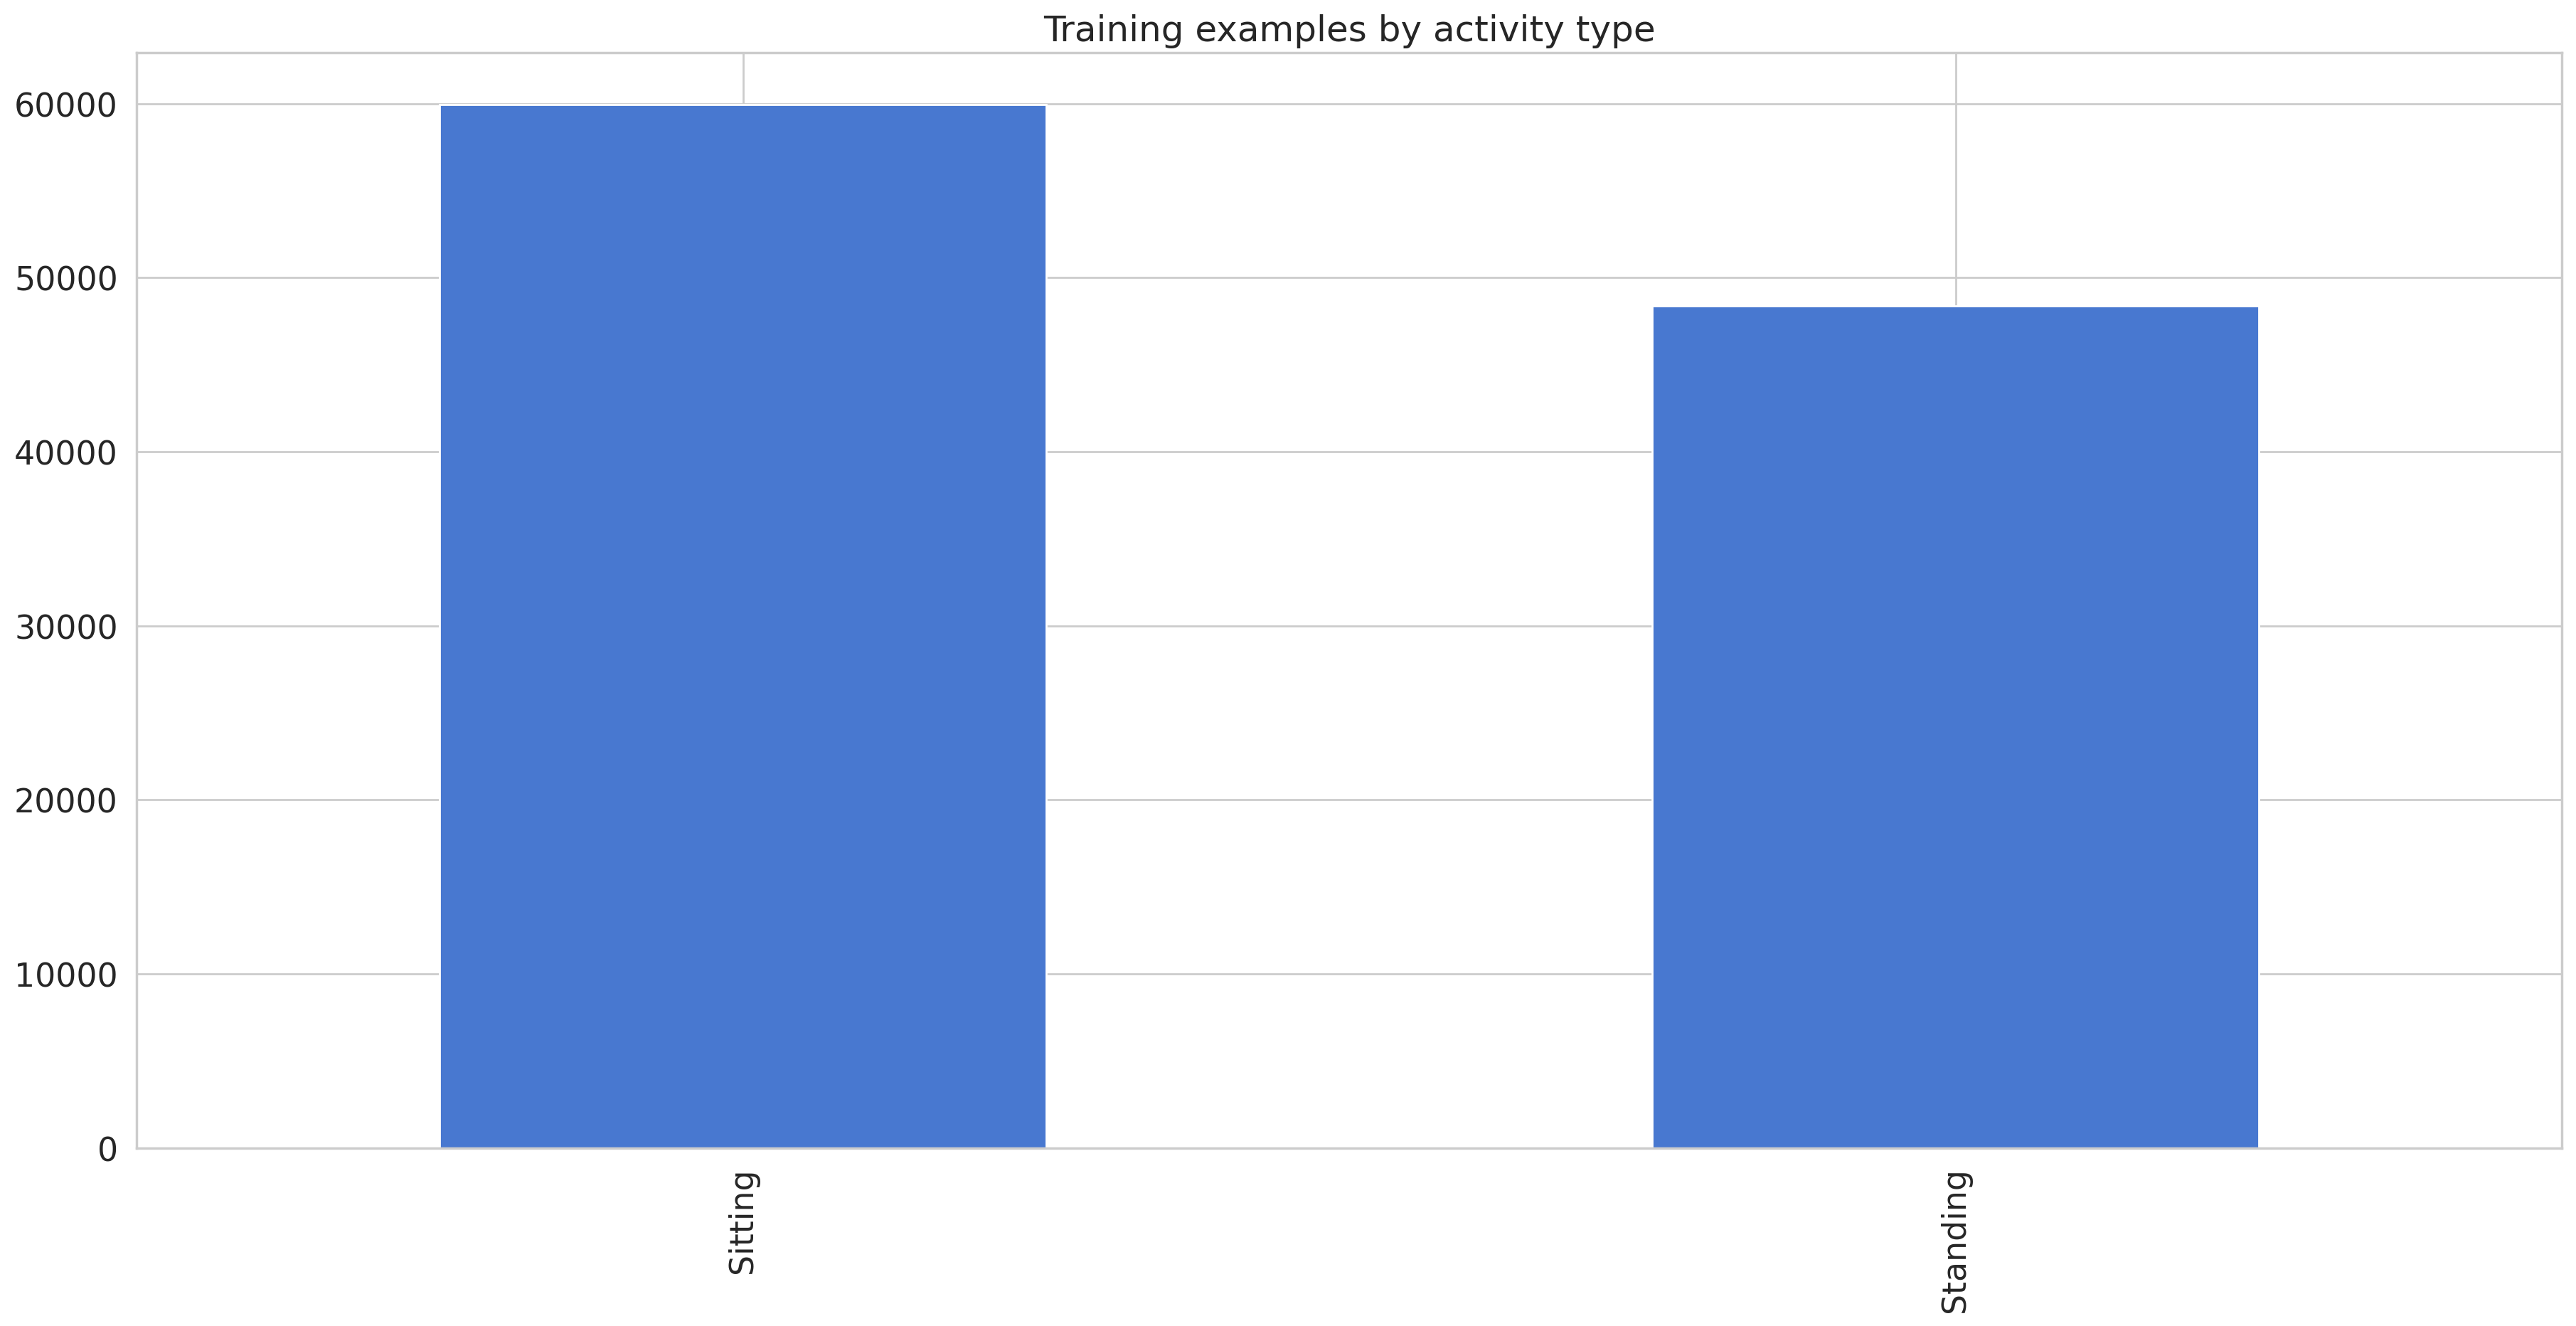

In [11]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [12]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


user_id activity        timestamp    x_axis    y_axis    z_axis  \
221333        27  Sitting   12363992261000  0.490260  0.617689 -0.241746   
221334        27  Sitting   12364042279000  0.503247  0.599144 -0.311732   
221335        27  Sitting   12364092267000  0.634740  0.507846 -0.277636   
221336        27  Sitting   12364142316000  0.659091  0.577746 -0.256102   
221337        27  Sitting   12364192273000  0.540584  0.572040 -0.241746   
...          ...      ...              ...       ...       ...       ...   
1098200       19  Sitting  131623331483000  1.529221 -0.984308 -0.155468   
1098201       19  Sitting  131623371431000  1.535714 -0.968616 -0.150198   
1098202       19  Sitting  131623411592000  1.542208 -0.957204 -0.155468   
1098203       19  Sitting  131623491487000  1.529221 -0.968616 -0.150198   
1098204       19  Sitting  131623531465000  1.509740 -0.950071 -0.166008   

         ActivityEncoded  
221333                 4  
221334                 4  
221335                 4  
221336                 4  
221337                 4  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[108334 rows x 7 columns]

In [13]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)
X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )


n_steps = 4
n_features = X_train.shape[2]
n_length = 50

X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(1730, 4, 50, 3) (1730, 1)
(541, 4, 50, 3) (541, 1)


In [14]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(1730, 4, 50, 3) (1730, 2) (541, 4, 50, 3) (541, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
#Epoch 500

BATCH_SIZE = 32

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps, n_features, n_outputs = n_steps * n_length, X_train.shape[3], y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 2)

# layer3

# CNN1 - LSTM2

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 48, 64)      640       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 48, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 24, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, None, 1536)        0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, None, 100)         6

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
14/14 [==============================] - 9s 288ms/step - loss: 0.3224 - accuracy: 0.8960 - val_loss: 0.1698 - val_accuracy: 0.9284
Epoch 2/10
14/14 [==============================] - 3s 203ms/step - loss: 0.1248 - accuracy: 0.9445 - val_loss: 0.1110 - val_accuracy: 0.9400
Epoch 3/10
14/14 [==============================] - 2s 150ms/step - loss: 0.1065 - accuracy: 0.9584 - val_loss: 0.1002 - val_accuracy: 0.9423
Epoch 4/10
14/14 [==============================] - 2s 118ms/step - loss: 0.0928 - accuracy: 0.9607 - val_loss: 0.0978 - val_accuracy: 0.9584
Epoch 5/10
14/14 [==============================] - 2s 115ms/step - loss: 0.0851 - accuracy: 0.9699 - val_loss: 0.0835 - val_accuracy: 0.9630
Epoch 6/10
14/14 [==============================] - 3s 190ms/step - loss: 0.0700 - accuracy: 0.9751 - val_loss: 0.0733 - val_accuracy: 0.9561
Epoch 7/10
14/14 [==============================] - 2s 118ms/step - loss: 0.0656 - accuracy: 0.9746 - val_loss: 0.0689 - val_accuracy: 0.9815
Epoch 

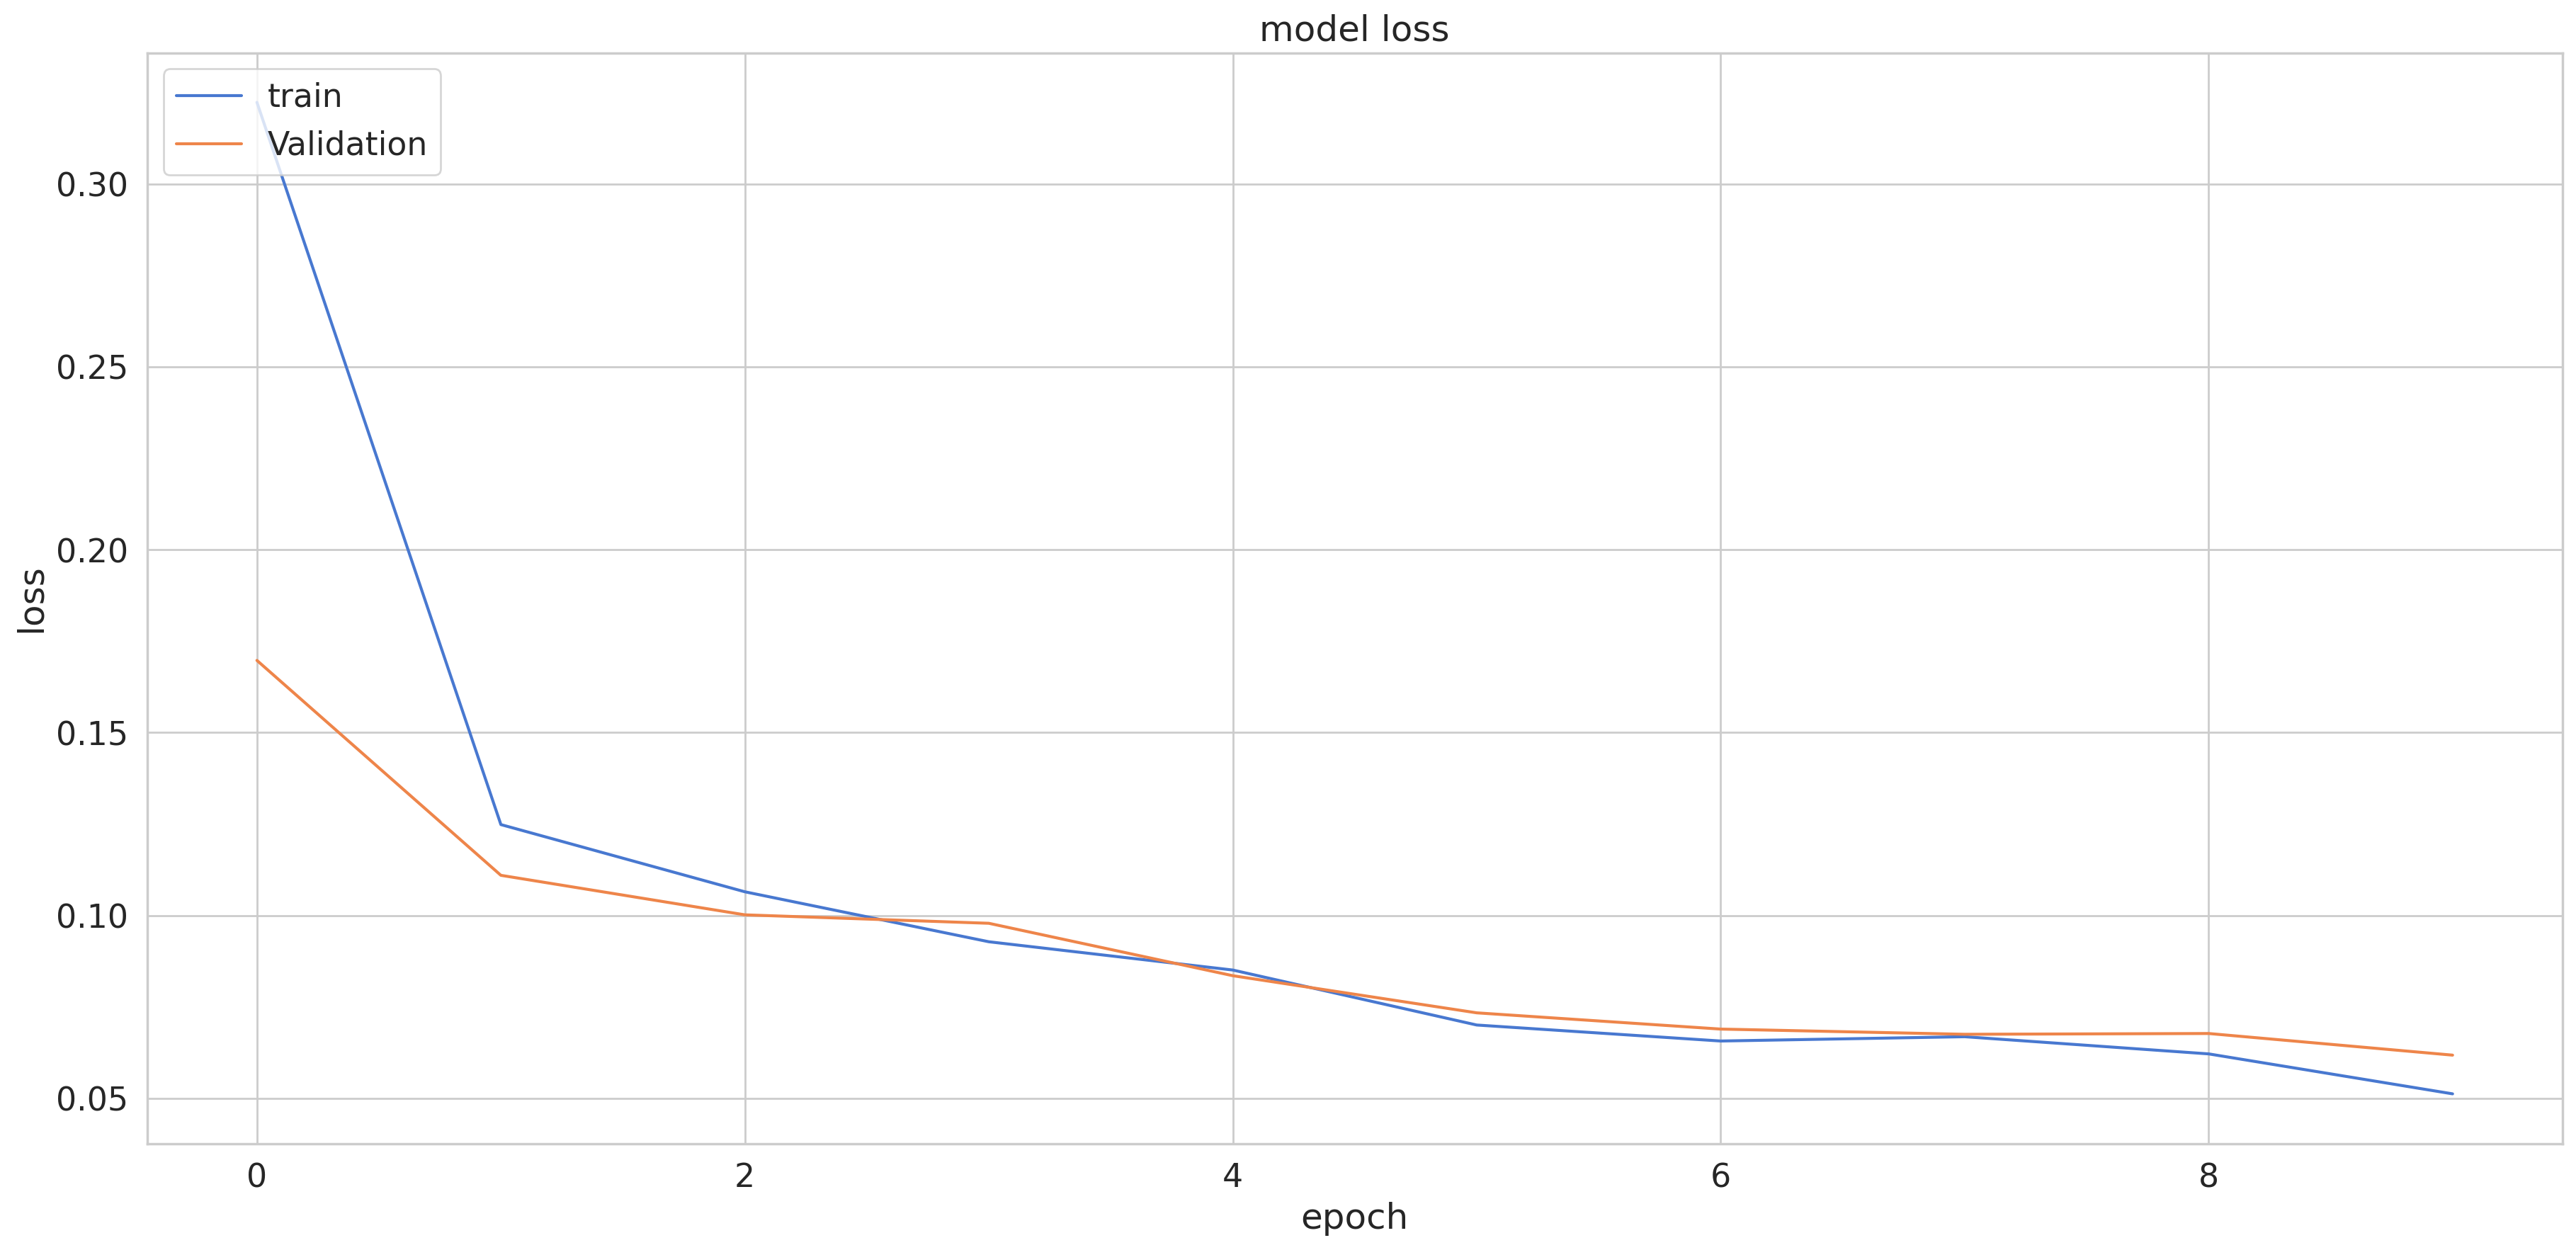

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

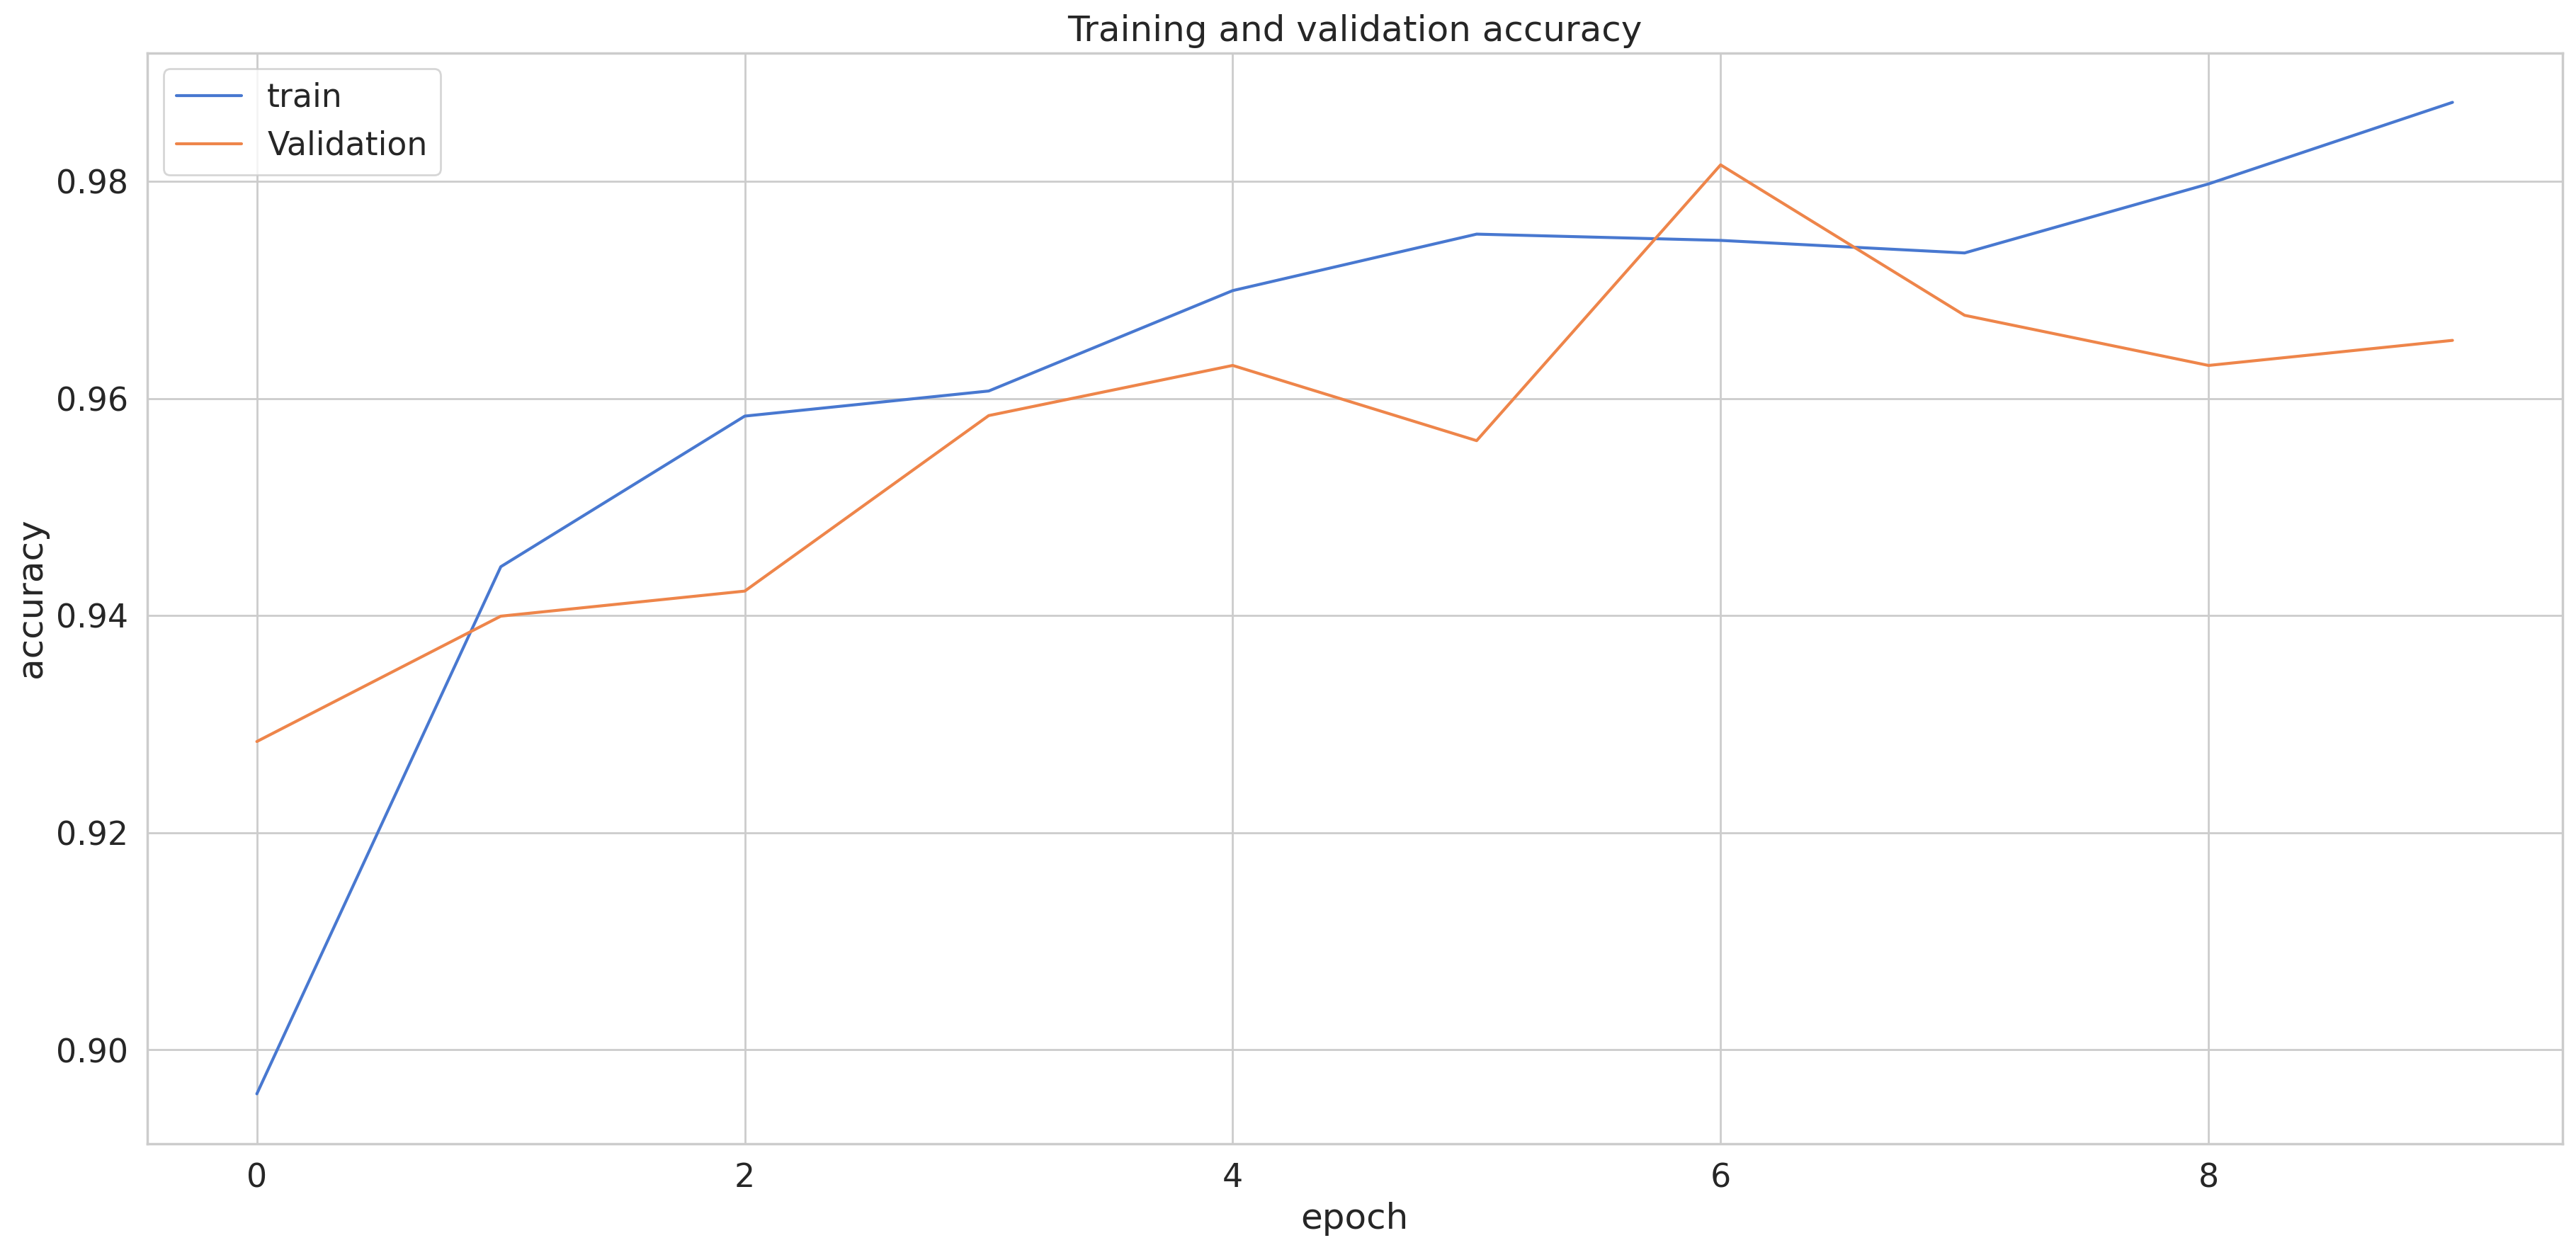

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

17/17 [==============================] - 1s 13ms/step
f1_score =  0.9778488078436346
0.977818853974122
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       299
           1       0.96      0.99      0.98       242

    accuracy                           0.98       541
   macro avg       0.98      0.98      0.98       541
weighted avg       0.98      0.98      0.98       541



<Axes: >

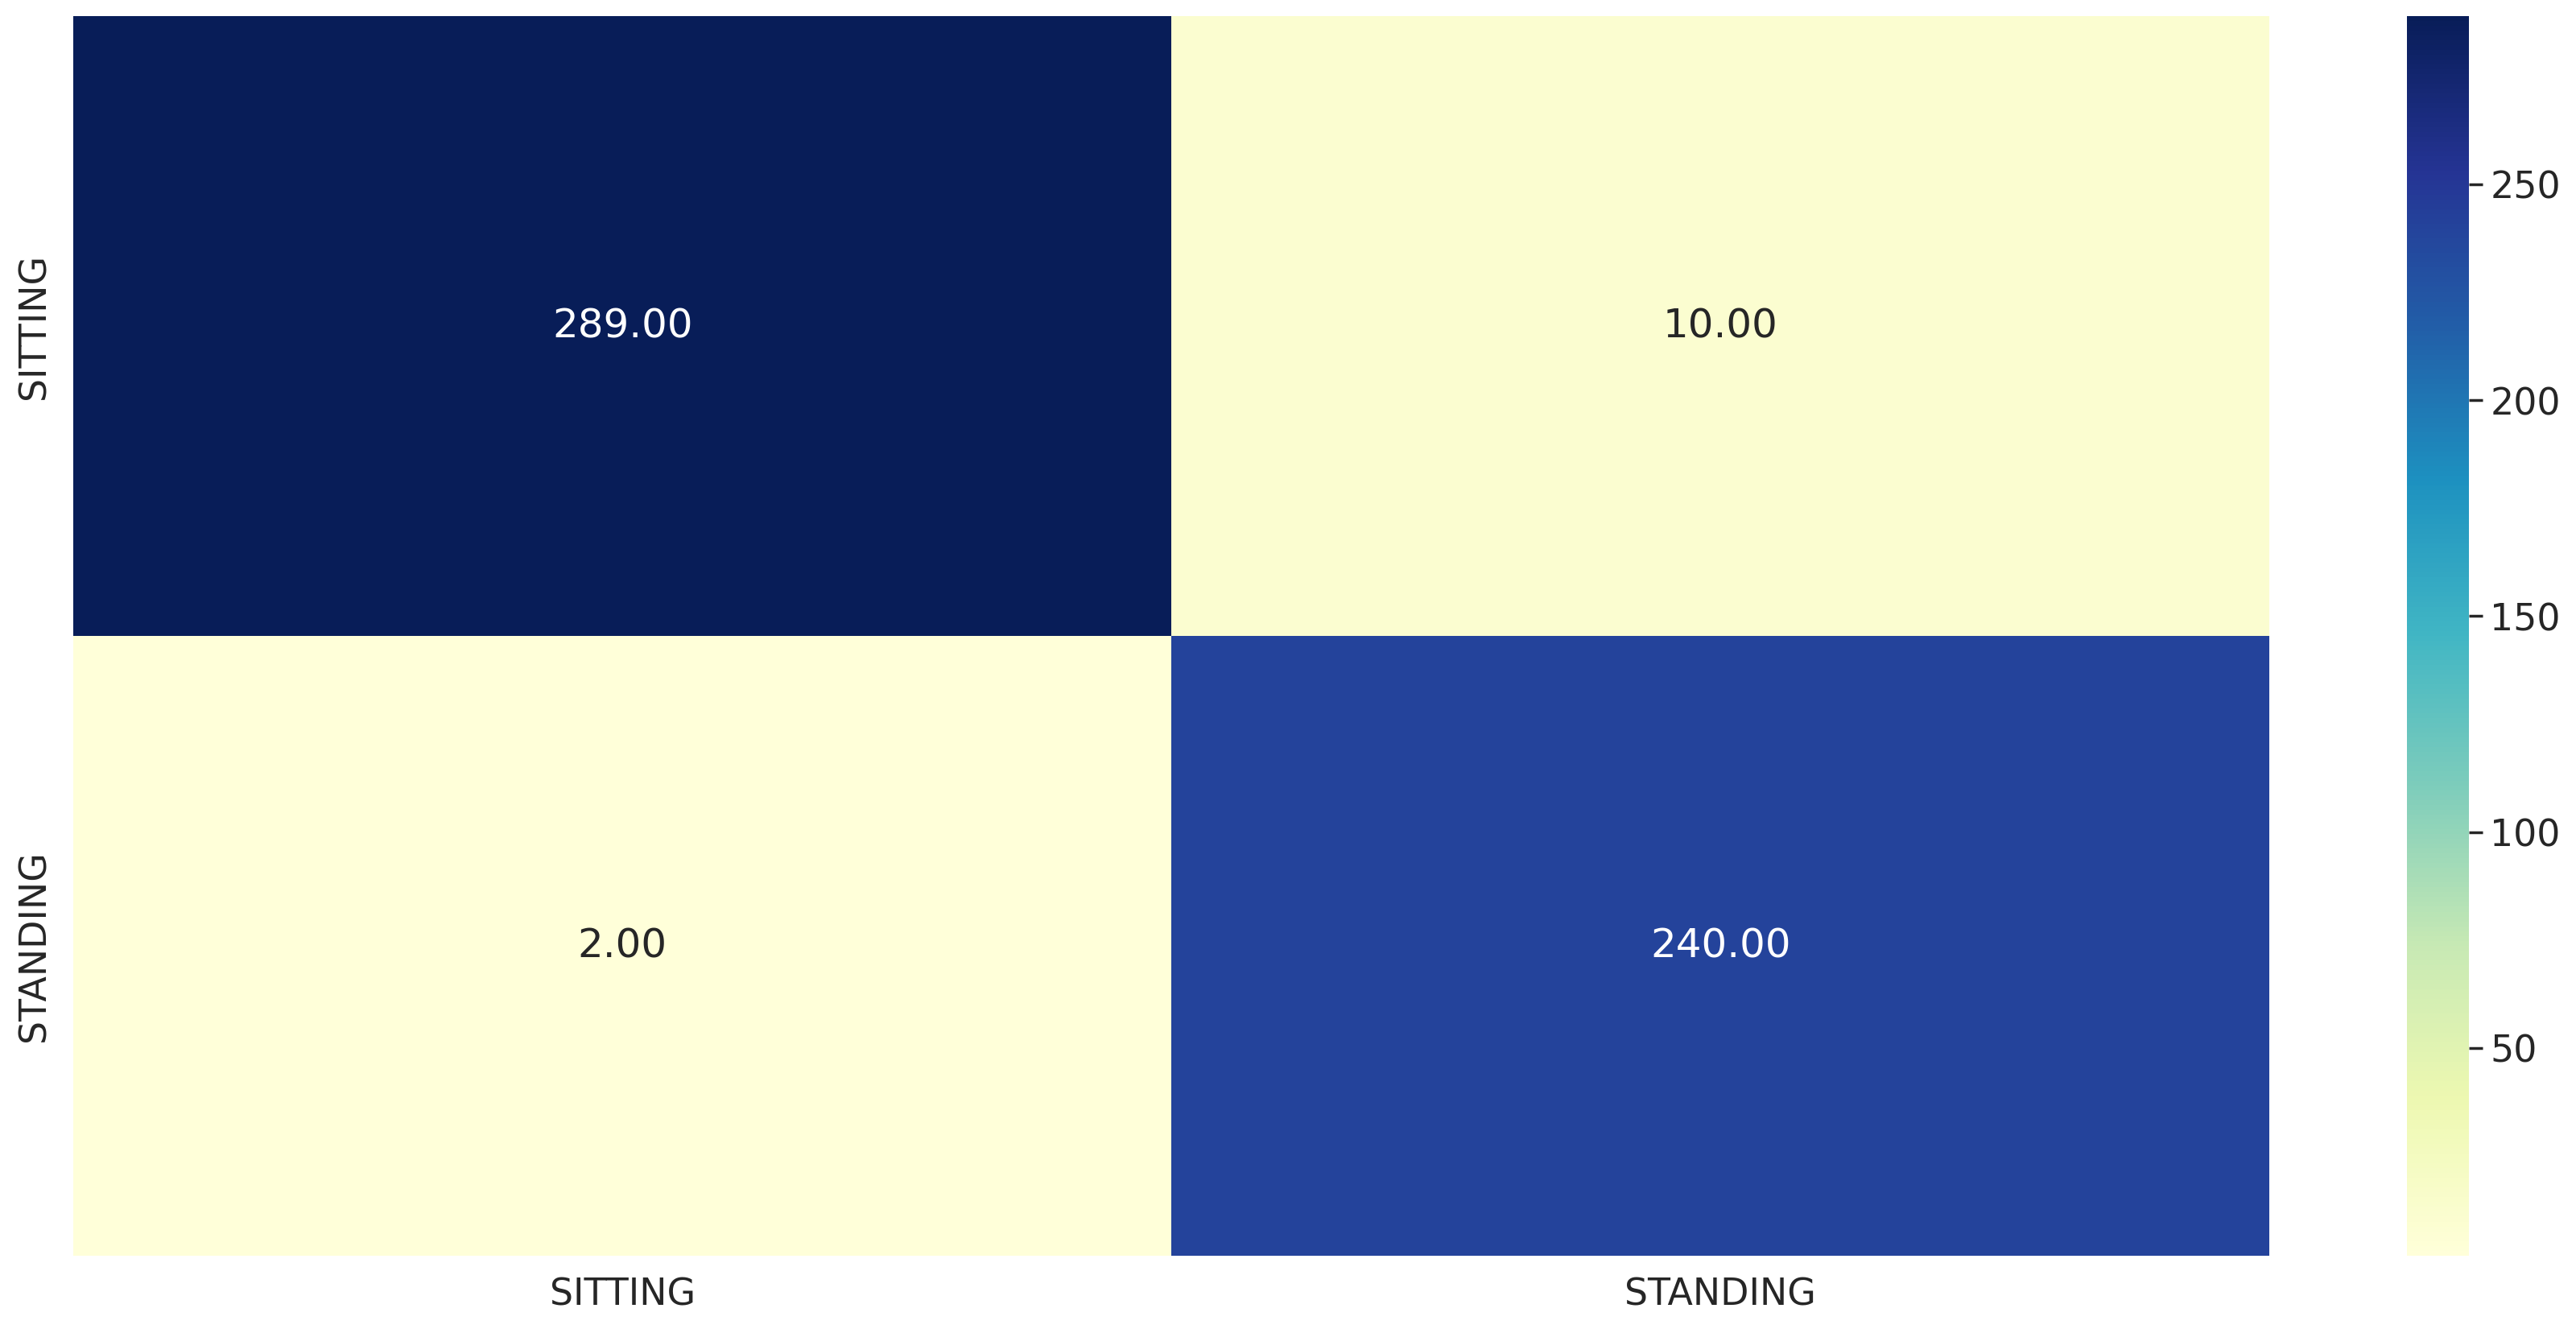

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['SITTING','STANDING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN 2 - LSTM1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, None, 48, 64)      640       
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, None, 46, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, None, 46, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, None, 23, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_8 (TimeDi  (None, None, 1472)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
14/14 [==============================] - 7s 292ms/step - loss: 0.2545 - accuracy: 0.9081 - val_loss: 0.1657 - val_accuracy: 0.9538
Epoch 2/10
14/14 [==============================] - 3s 249ms/step - loss: 0.1165 - accuracy: 0.9555 - val_loss: 0.1106 - val_accuracy: 0.9584
Epoch 3/10
14/14 [==============================] - 2s 165ms/step - loss: 0.0922 - accuracy: 0.9682 - val_loss: 0.0821 - val_accuracy: 0.9677
Epoch 4/10
14/14 [==============================] - 2s 150ms/step - loss: 0.0740 - accuracy: 0.9780 - val_loss: 0.0664 - val_accuracy: 0.9861
Epoch 5/10
14/14 [==============================] - 2s 153ms/step - loss: 0.0584 - accuracy: 0.9838 - val_loss: 0.0536 - val_accuracy: 0.9885
Epoch 6/10
14/14 [==============================] - 4s 295ms/step - loss: 0.0502 - accuracy: 0.9896 - val_loss: 0.0435 - val_accuracy: 0.9931
Epoch 7/10
14/14 [==============================] - 3s 236ms/step - loss: 0.0400 - accuracy: 0.9902 - val_loss: 0.0376 - val_accuracy: 0.9931
Epoch 

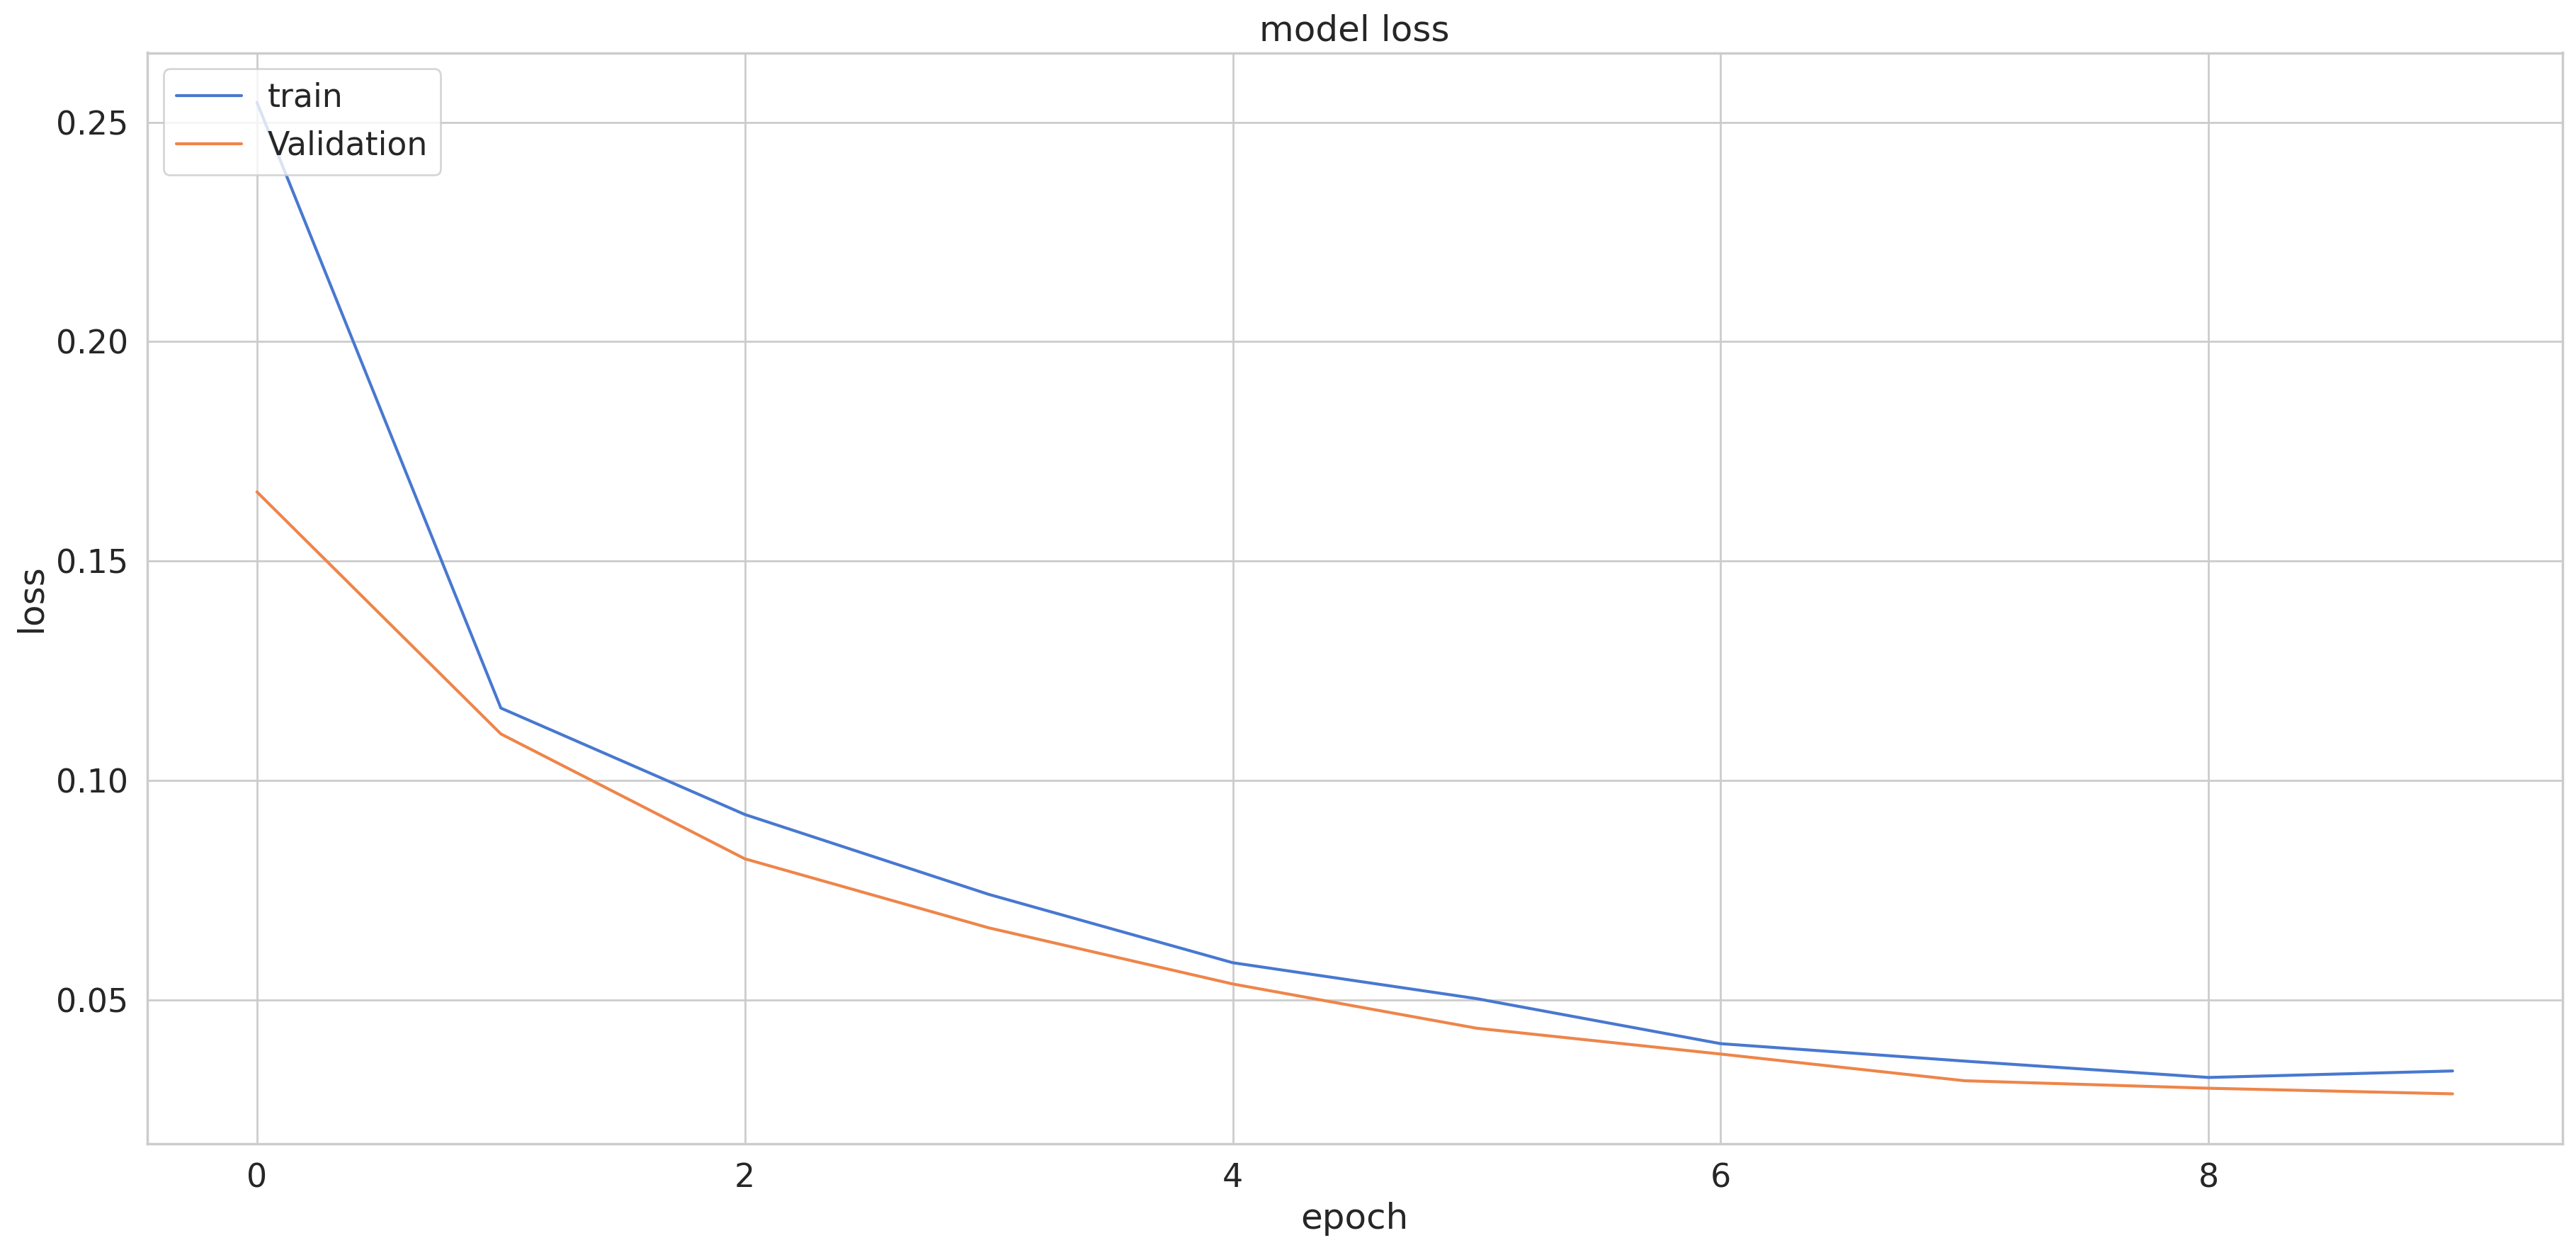

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

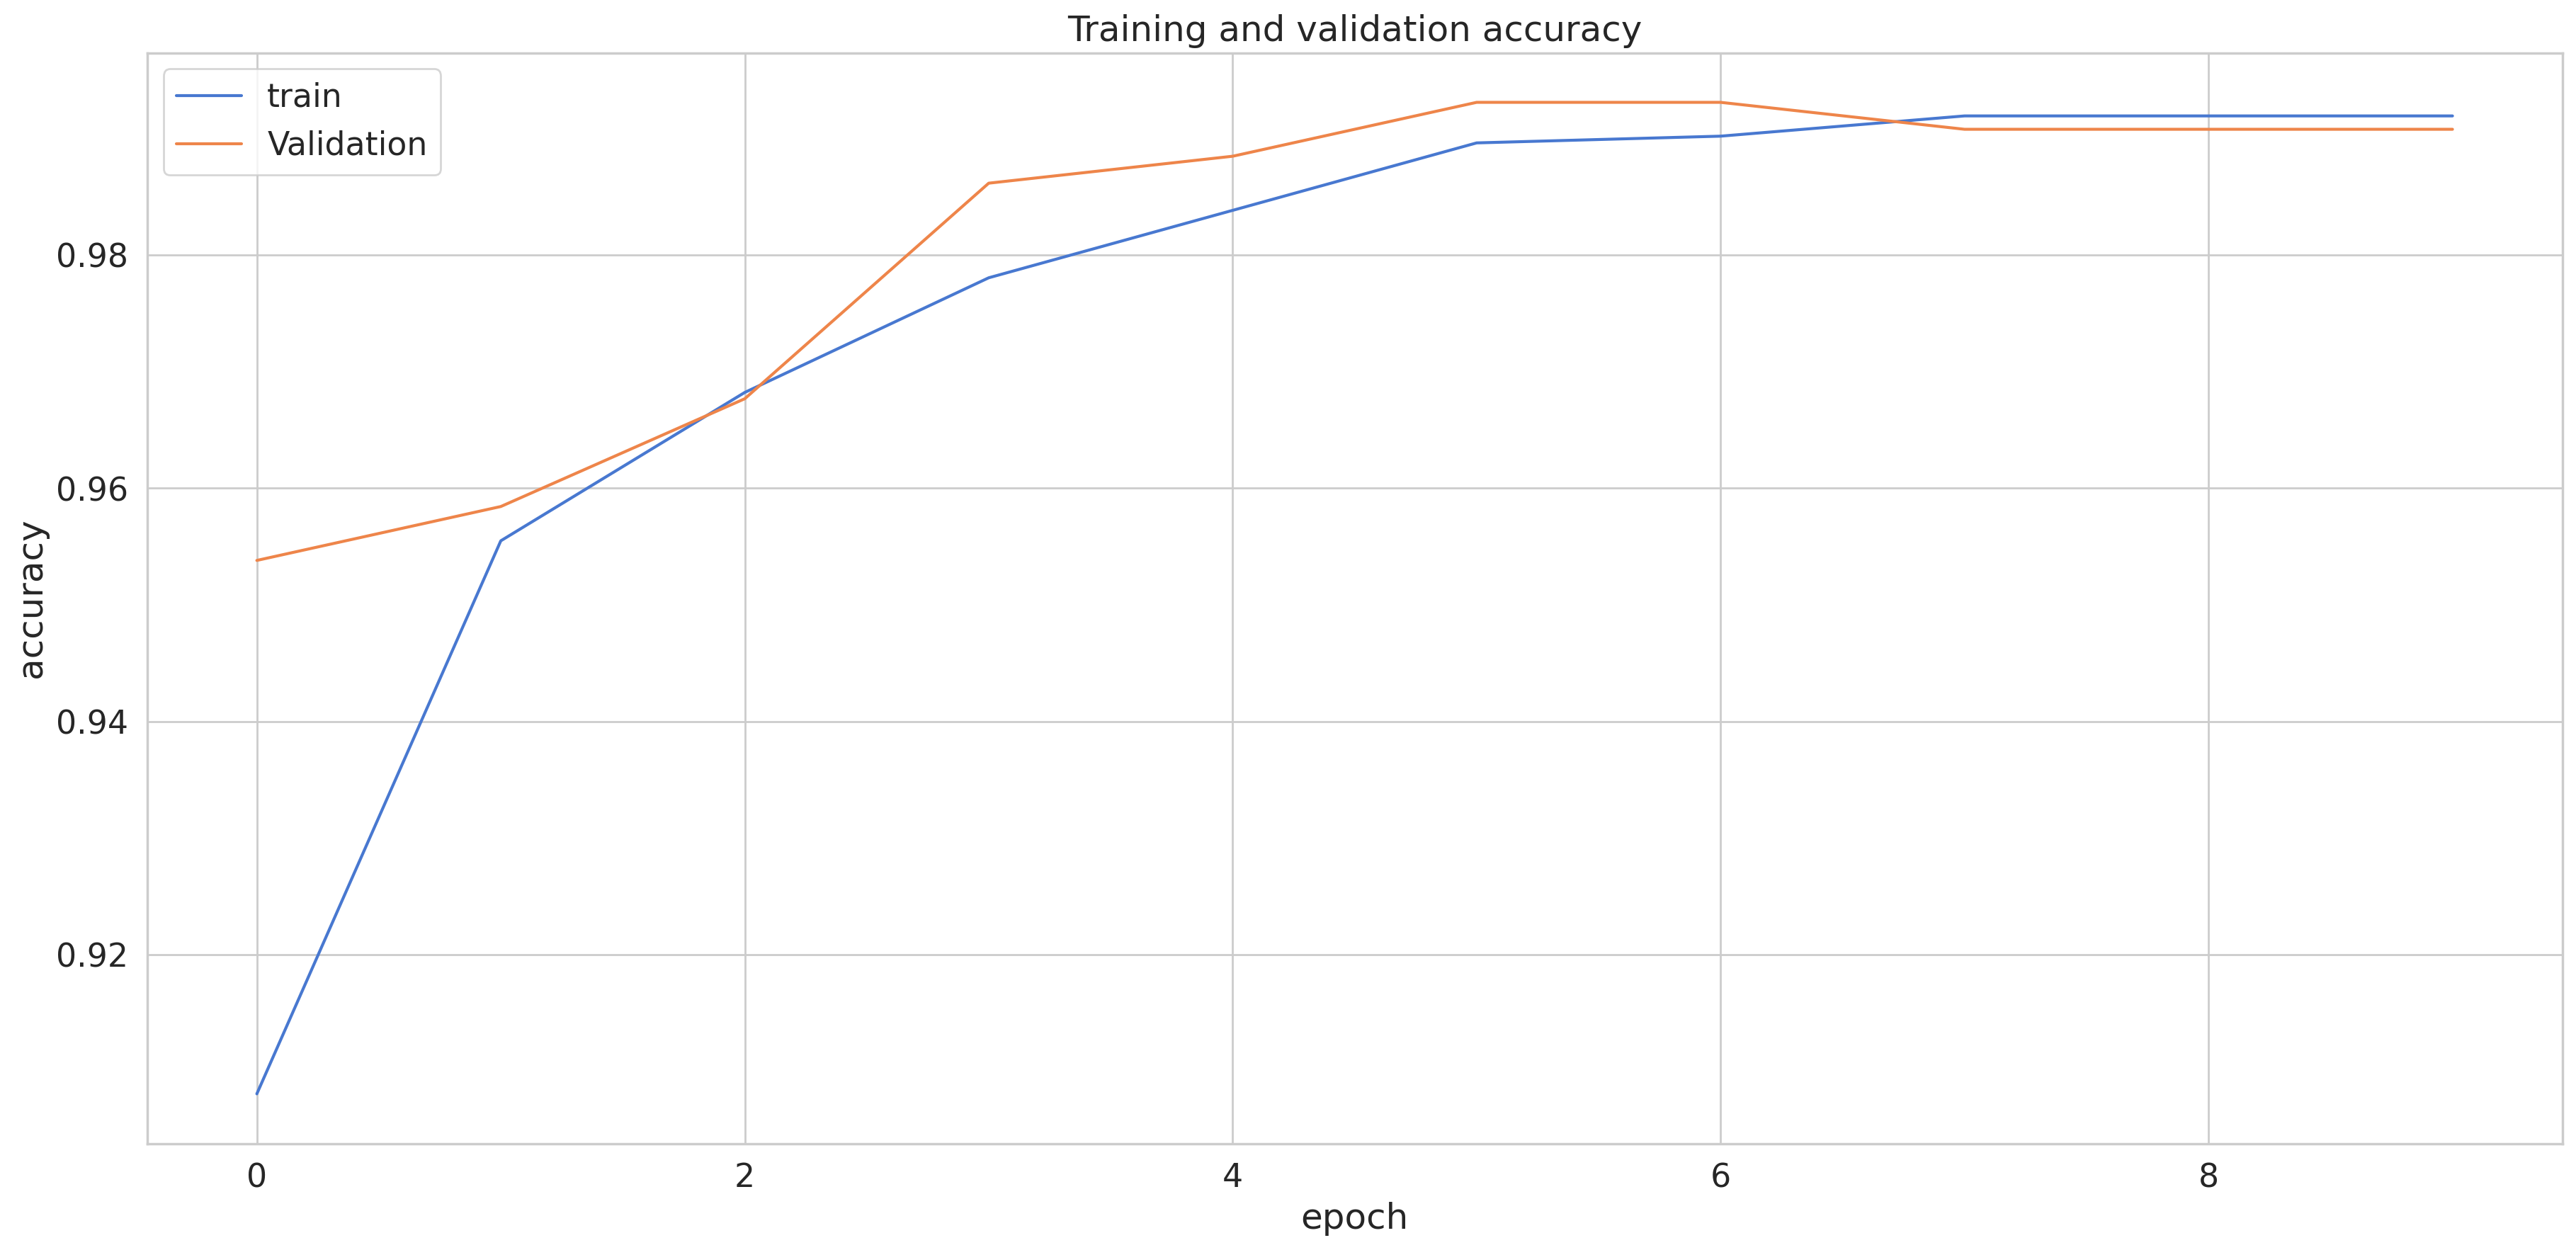

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

17/17 [==============================] - 2s 15ms/step
f1_score =  0.9944557859901868
0.9944547134935305
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       299
           1       0.99      1.00      0.99       242

    accuracy                           0.99       541
   macro avg       0.99      0.99      0.99       541
weighted avg       0.99      0.99      0.99       541



<Axes: >

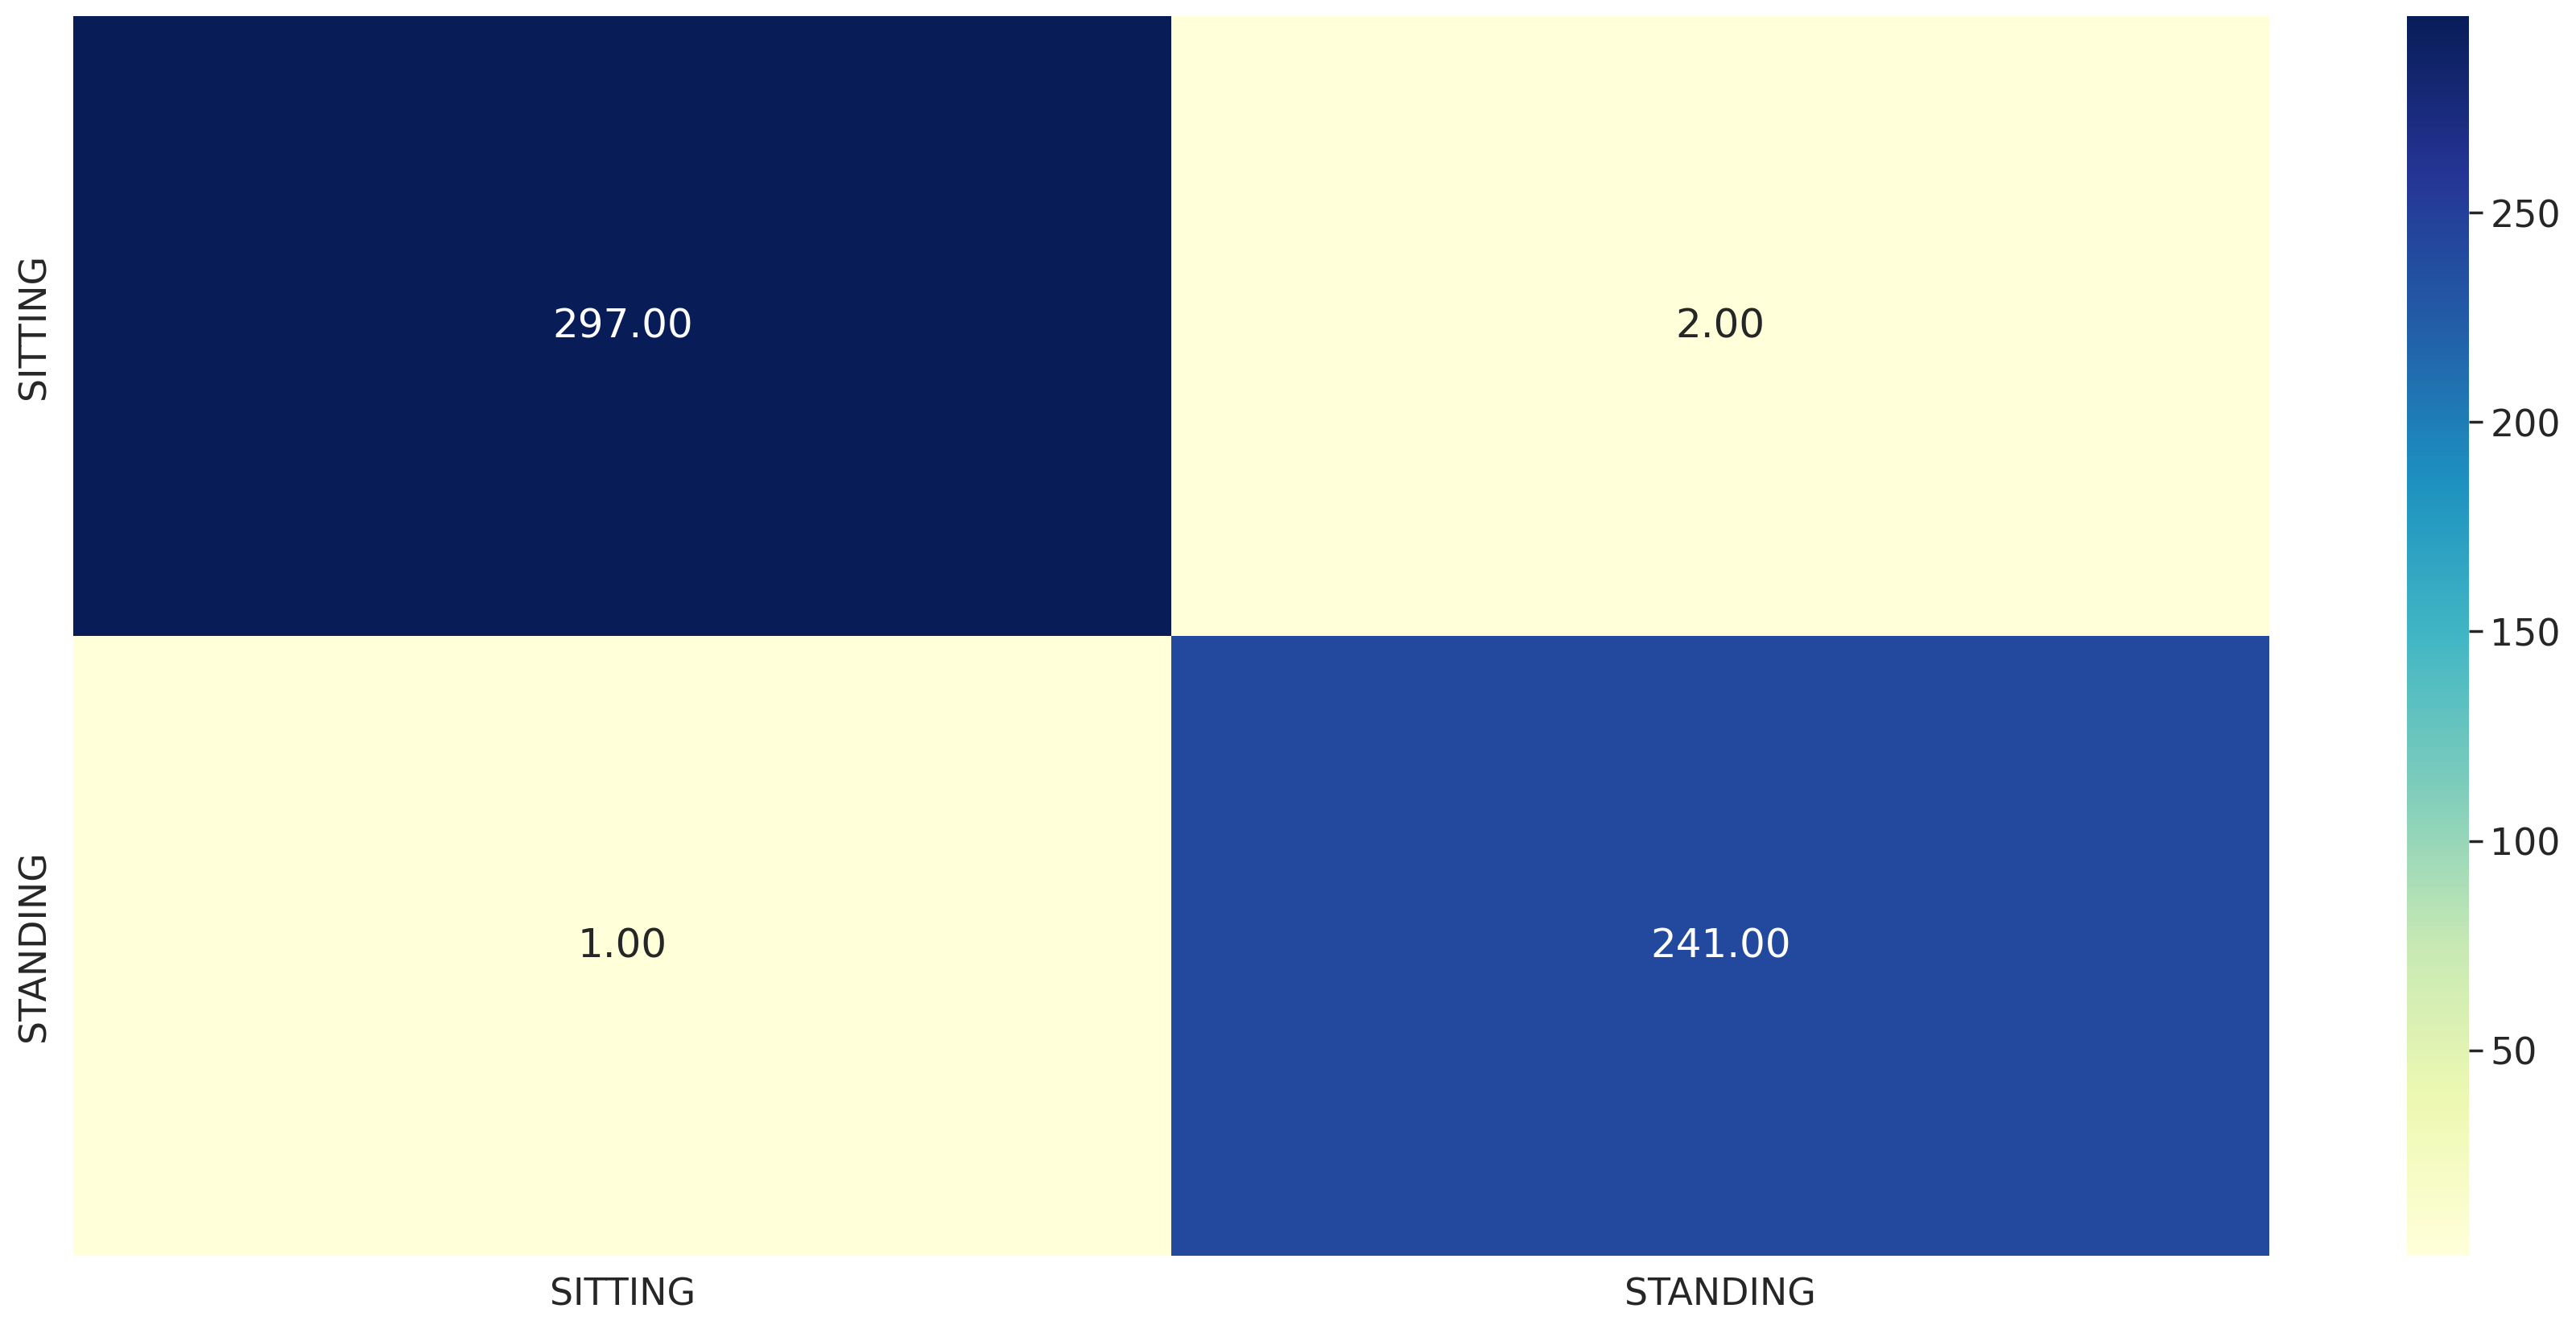

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['SITTING','STANDING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# layer4

# CNN 1 - LSTM3

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))


model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDi  (None, None, 48, 64)      640       
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, None, 48, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, None, 24, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, None, 1536)        0         
 istributed)                                                     
                                                                 
 lstm_3 (LSTM)               (None, None, 100)        

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
14/14 [==============================] - 12s 247ms/step - loss: 0.3803 - accuracy: 0.8838 - val_loss: 0.1759 - val_accuracy: 0.9353
Epoch 2/10
14/14 [==============================] - 2s 135ms/step - loss: 0.1508 - accuracy: 0.9416 - val_loss: 0.1116 - val_accuracy: 0.9446
Epoch 3/10
14/14 [==============================] - 2s 135ms/step - loss: 0.1155 - accuracy: 0.9486 - val_loss: 0.1085 - val_accuracy: 0.9492
Epoch 4/10
14/14 [==============================] - 2s 155ms/step - loss: 0.0966 - accuracy: 0.9647 - val_loss: 0.0947 - val_accuracy: 0.9654
Epoch 5/10
14/14 [==============================] - 3s 218ms/step - loss: 0.0853 - accuracy: 0.9688 - val_loss: 0.0807 - val_accuracy: 0.9677
Epoch 6/10
14/14 [==============================] - 3s 212ms/step - loss: 0.0796 - accuracy: 0.9705 - val_loss: 0.0724 - val_accuracy: 0.9700
Epoch 7/10
14/14 [==============================] - 2s 159ms/step - loss: 0.0694 - accuracy: 0.9740 - val_loss: 0.0754 - val_accuracy: 0.9700
Epoch

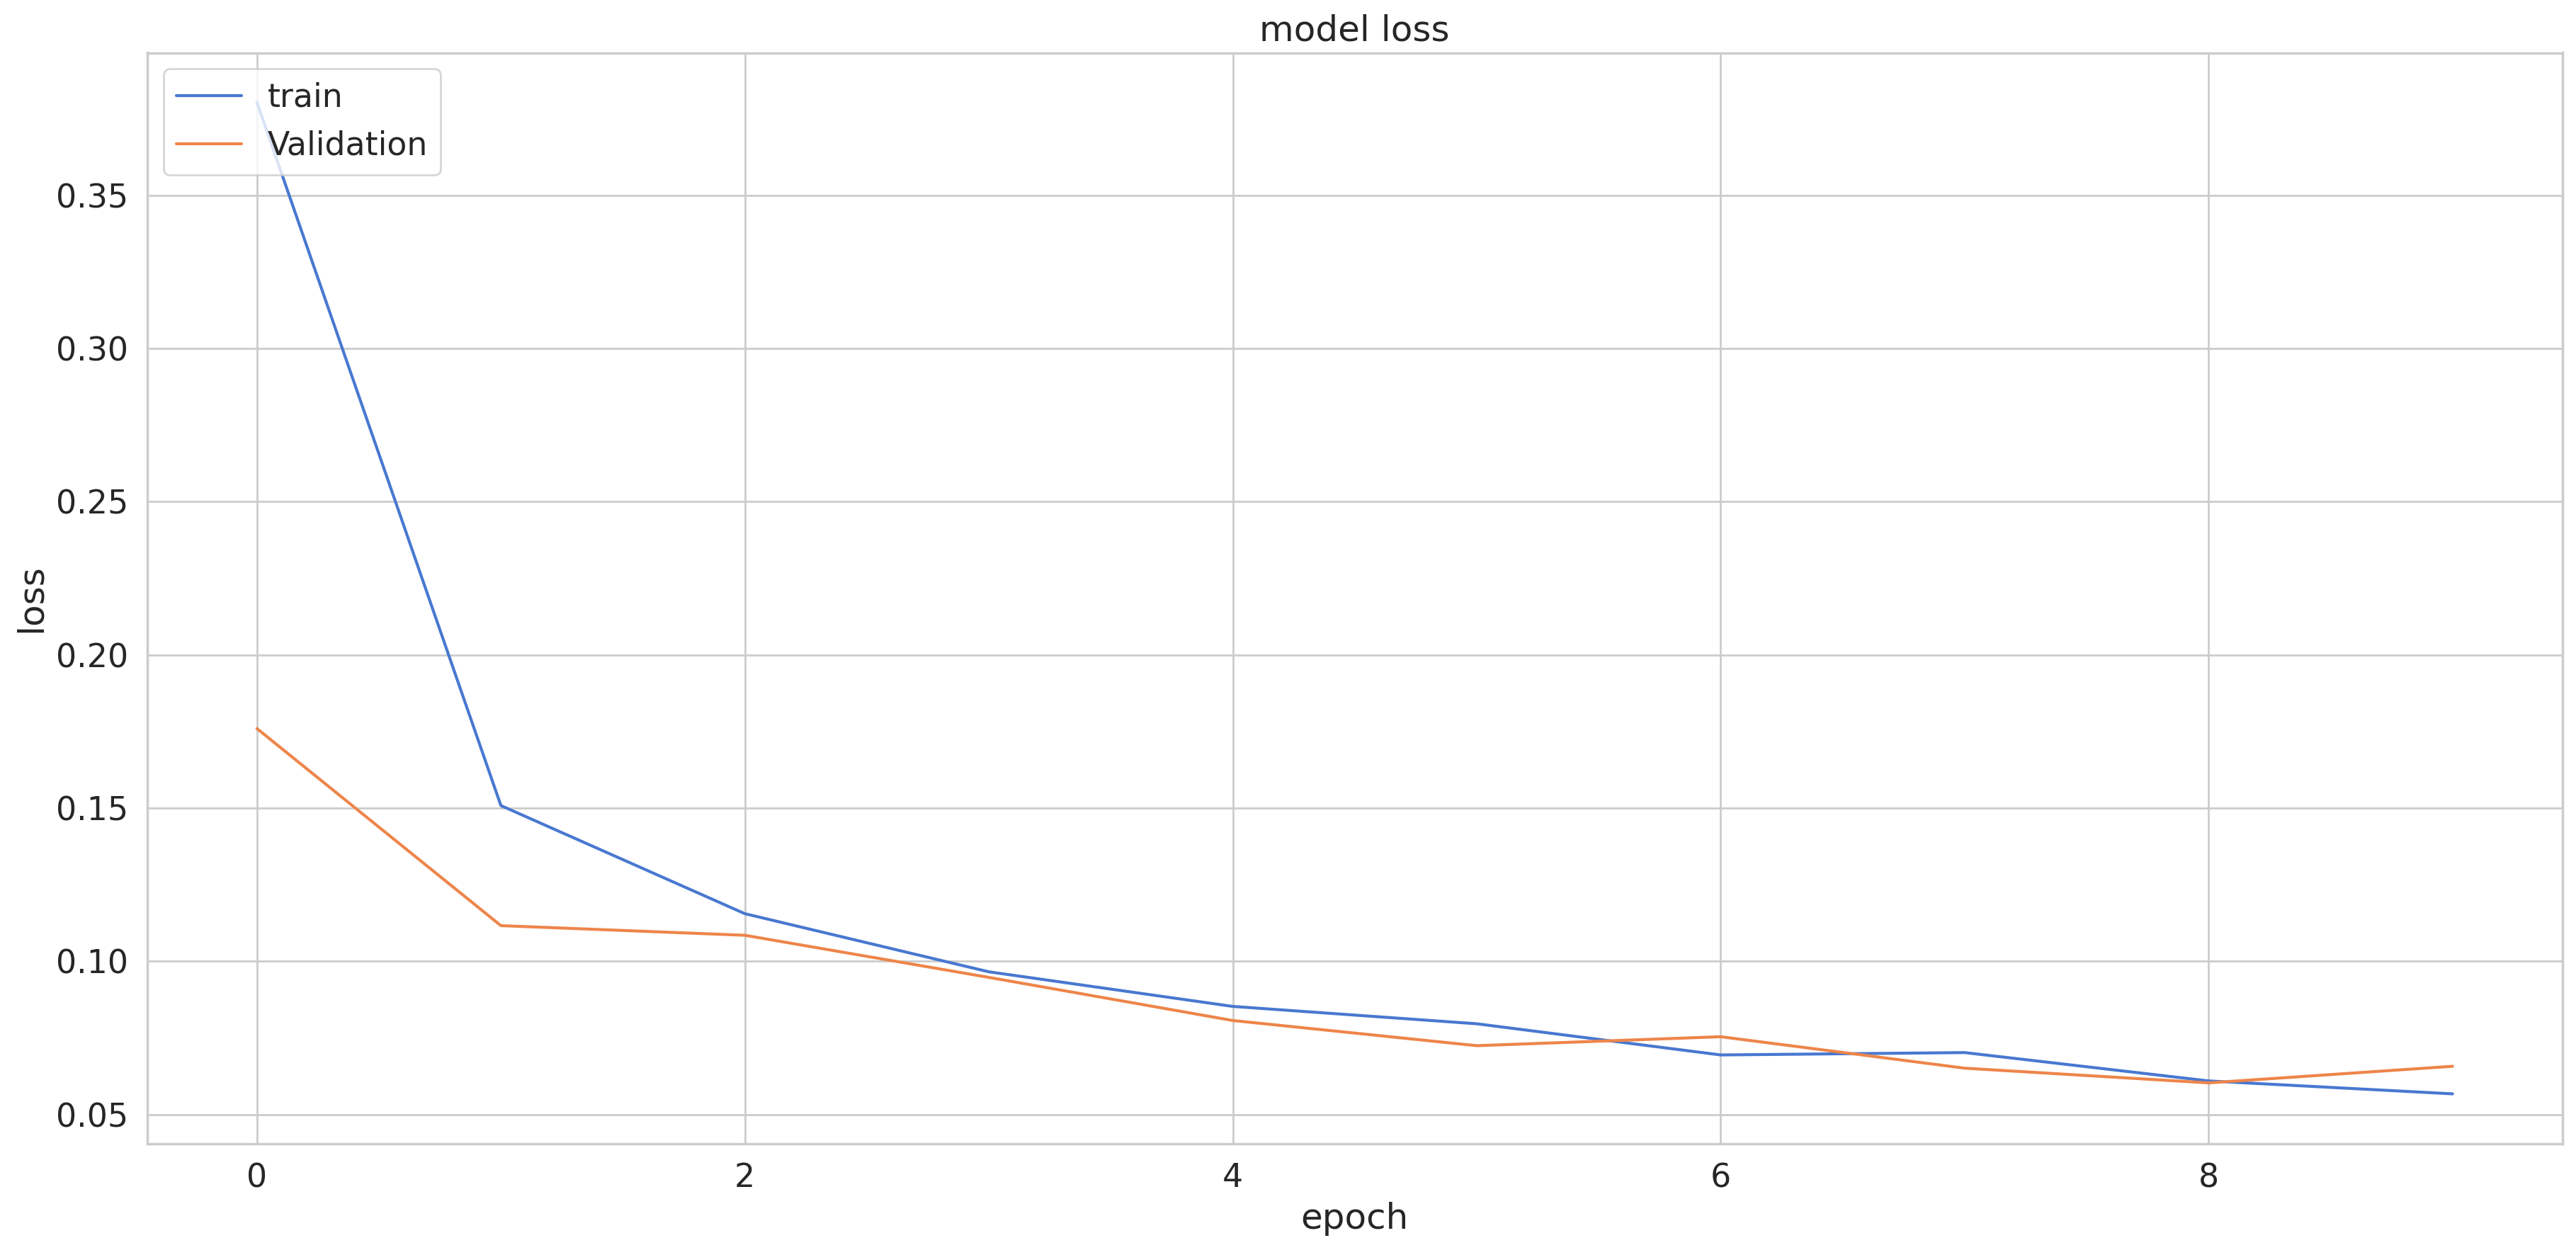

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

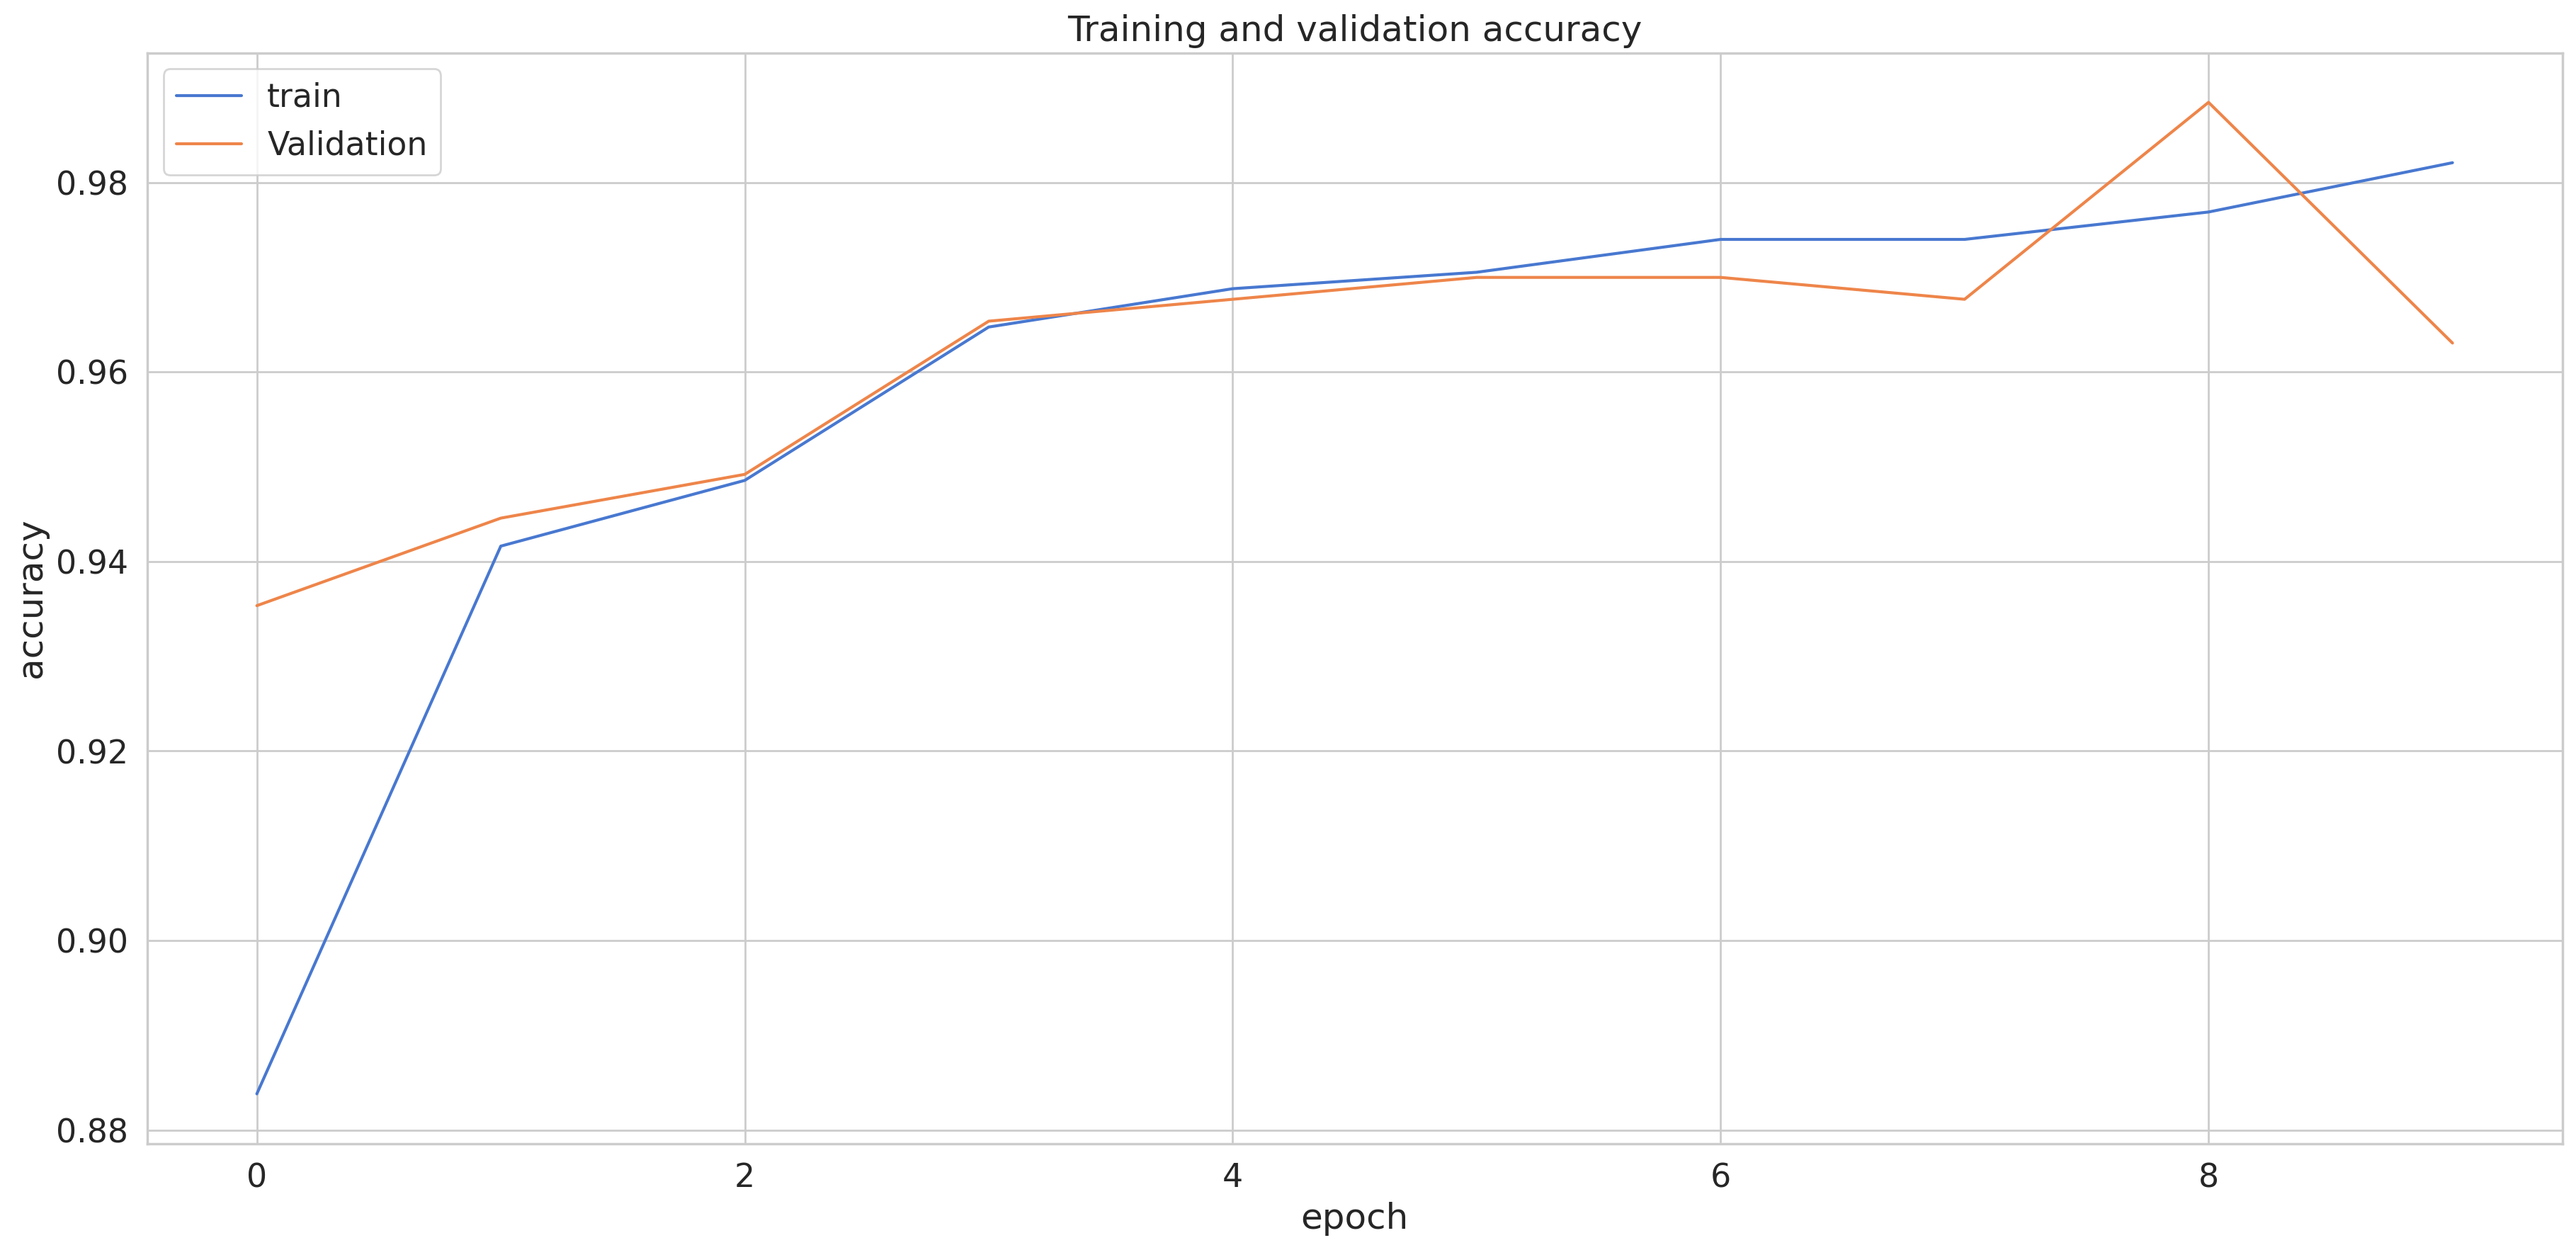

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

17/17 [==============================] - 2s 23ms/step
f1_score =  0.9778547443134048
0.977818853974122
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       299
           1       0.96      1.00      0.98       242

    accuracy                           0.98       541
   macro avg       0.98      0.98      0.98       541
weighted avg       0.98      0.98      0.98       541



<Axes: >

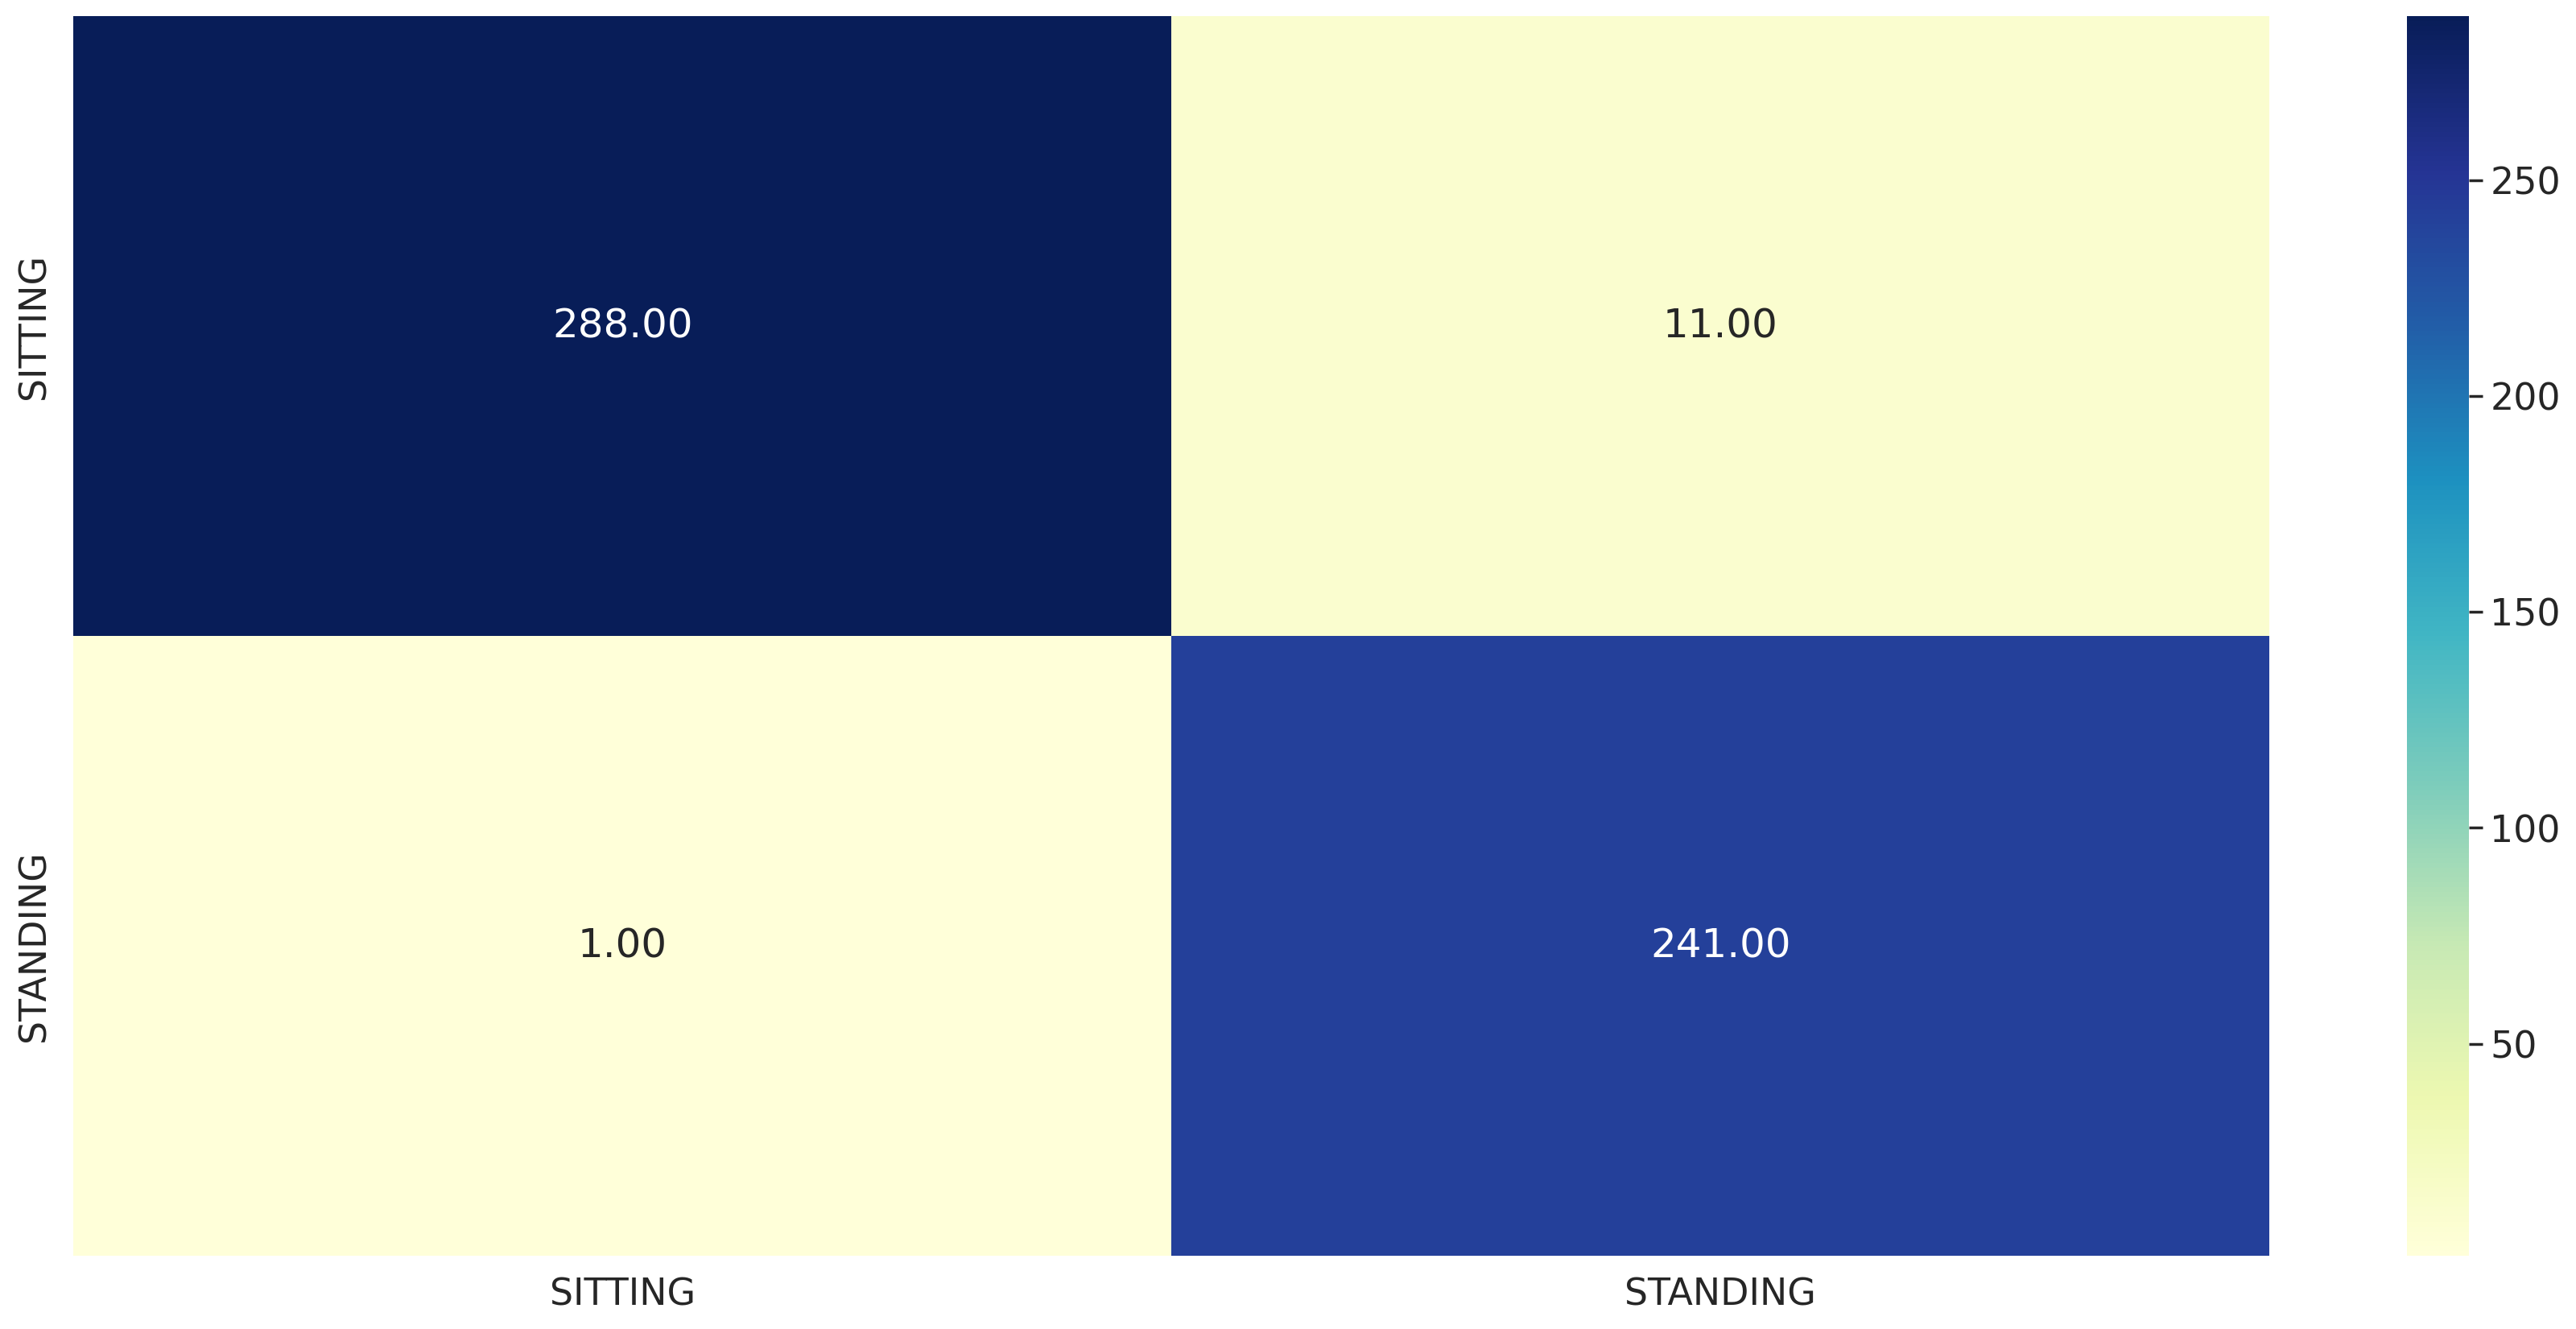

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['SITTING','STANDING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN 2 - LSTM2

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeD  (None, None, 48, 64)      640       
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, None, 46, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, None, 46, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, None, 23, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, None, 1472)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
14/14 [==============================] - 9s 235ms/step - loss: 0.3010 - accuracy: 0.8925 - val_loss: 0.1745 - val_accuracy: 0.9446
Epoch 2/10
14/14 [==============================] - 3s 206ms/step - loss: 0.1201 - accuracy: 0.9653 - val_loss: 0.0942 - val_accuracy: 0.9654
Epoch 3/10
14/14 [==============================] - 4s 272ms/step - loss: 0.0901 - accuracy: 0.9694 - val_loss: 0.0744 - val_accuracy: 0.9723
Epoch 4/10
14/14 [==============================] - 3s 227ms/step - loss: 0.0800 - accuracy: 0.9746 - val_loss: 0.0643 - val_accuracy: 0.9677
Epoch 5/10
14/14 [==============================] - 2s 162ms/step - loss: 0.0579 - accuracy: 0.9827 - val_loss: 0.0655 - val_accuracy: 0.9630
Epoch 6/10
14/14 [==============================] - 2s 162ms/step - loss: 0.0476 - accuracy: 0.9913 - val_loss: 0.0397 - val_accuracy: 0.9908
Epoch 7/10
14/14 [==============================] - 2s 177ms/step - loss: 0.0403 - accuracy: 0.9913 - val_loss: 0.0375 - val_accuracy: 0.9885
Epoch 

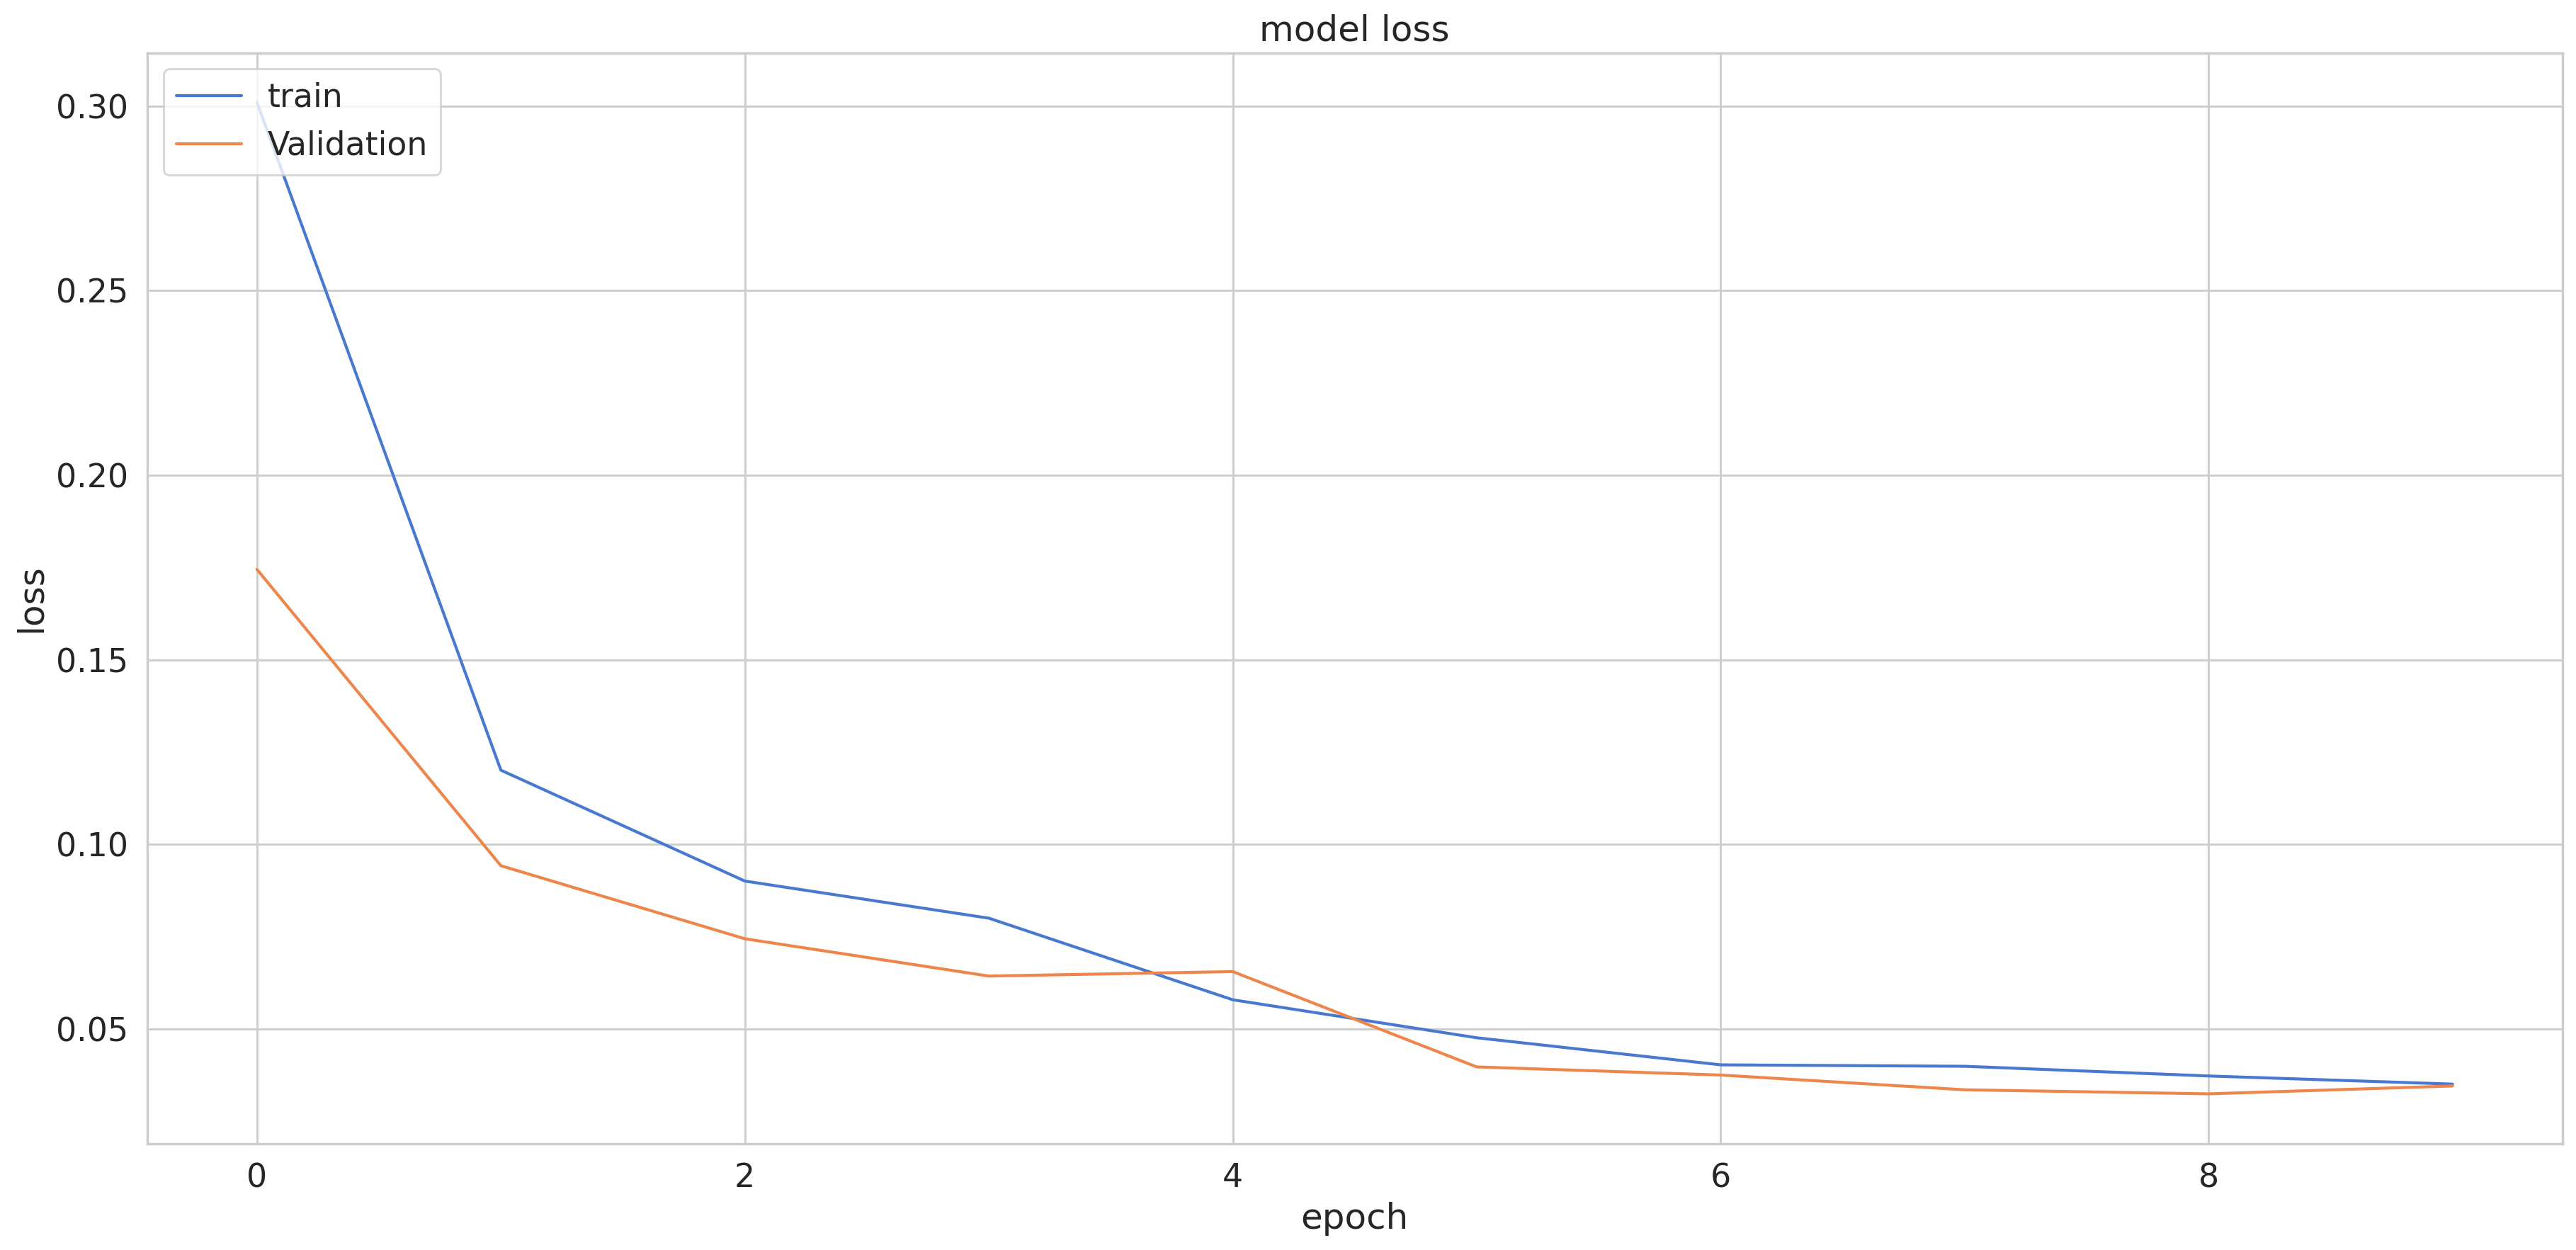

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

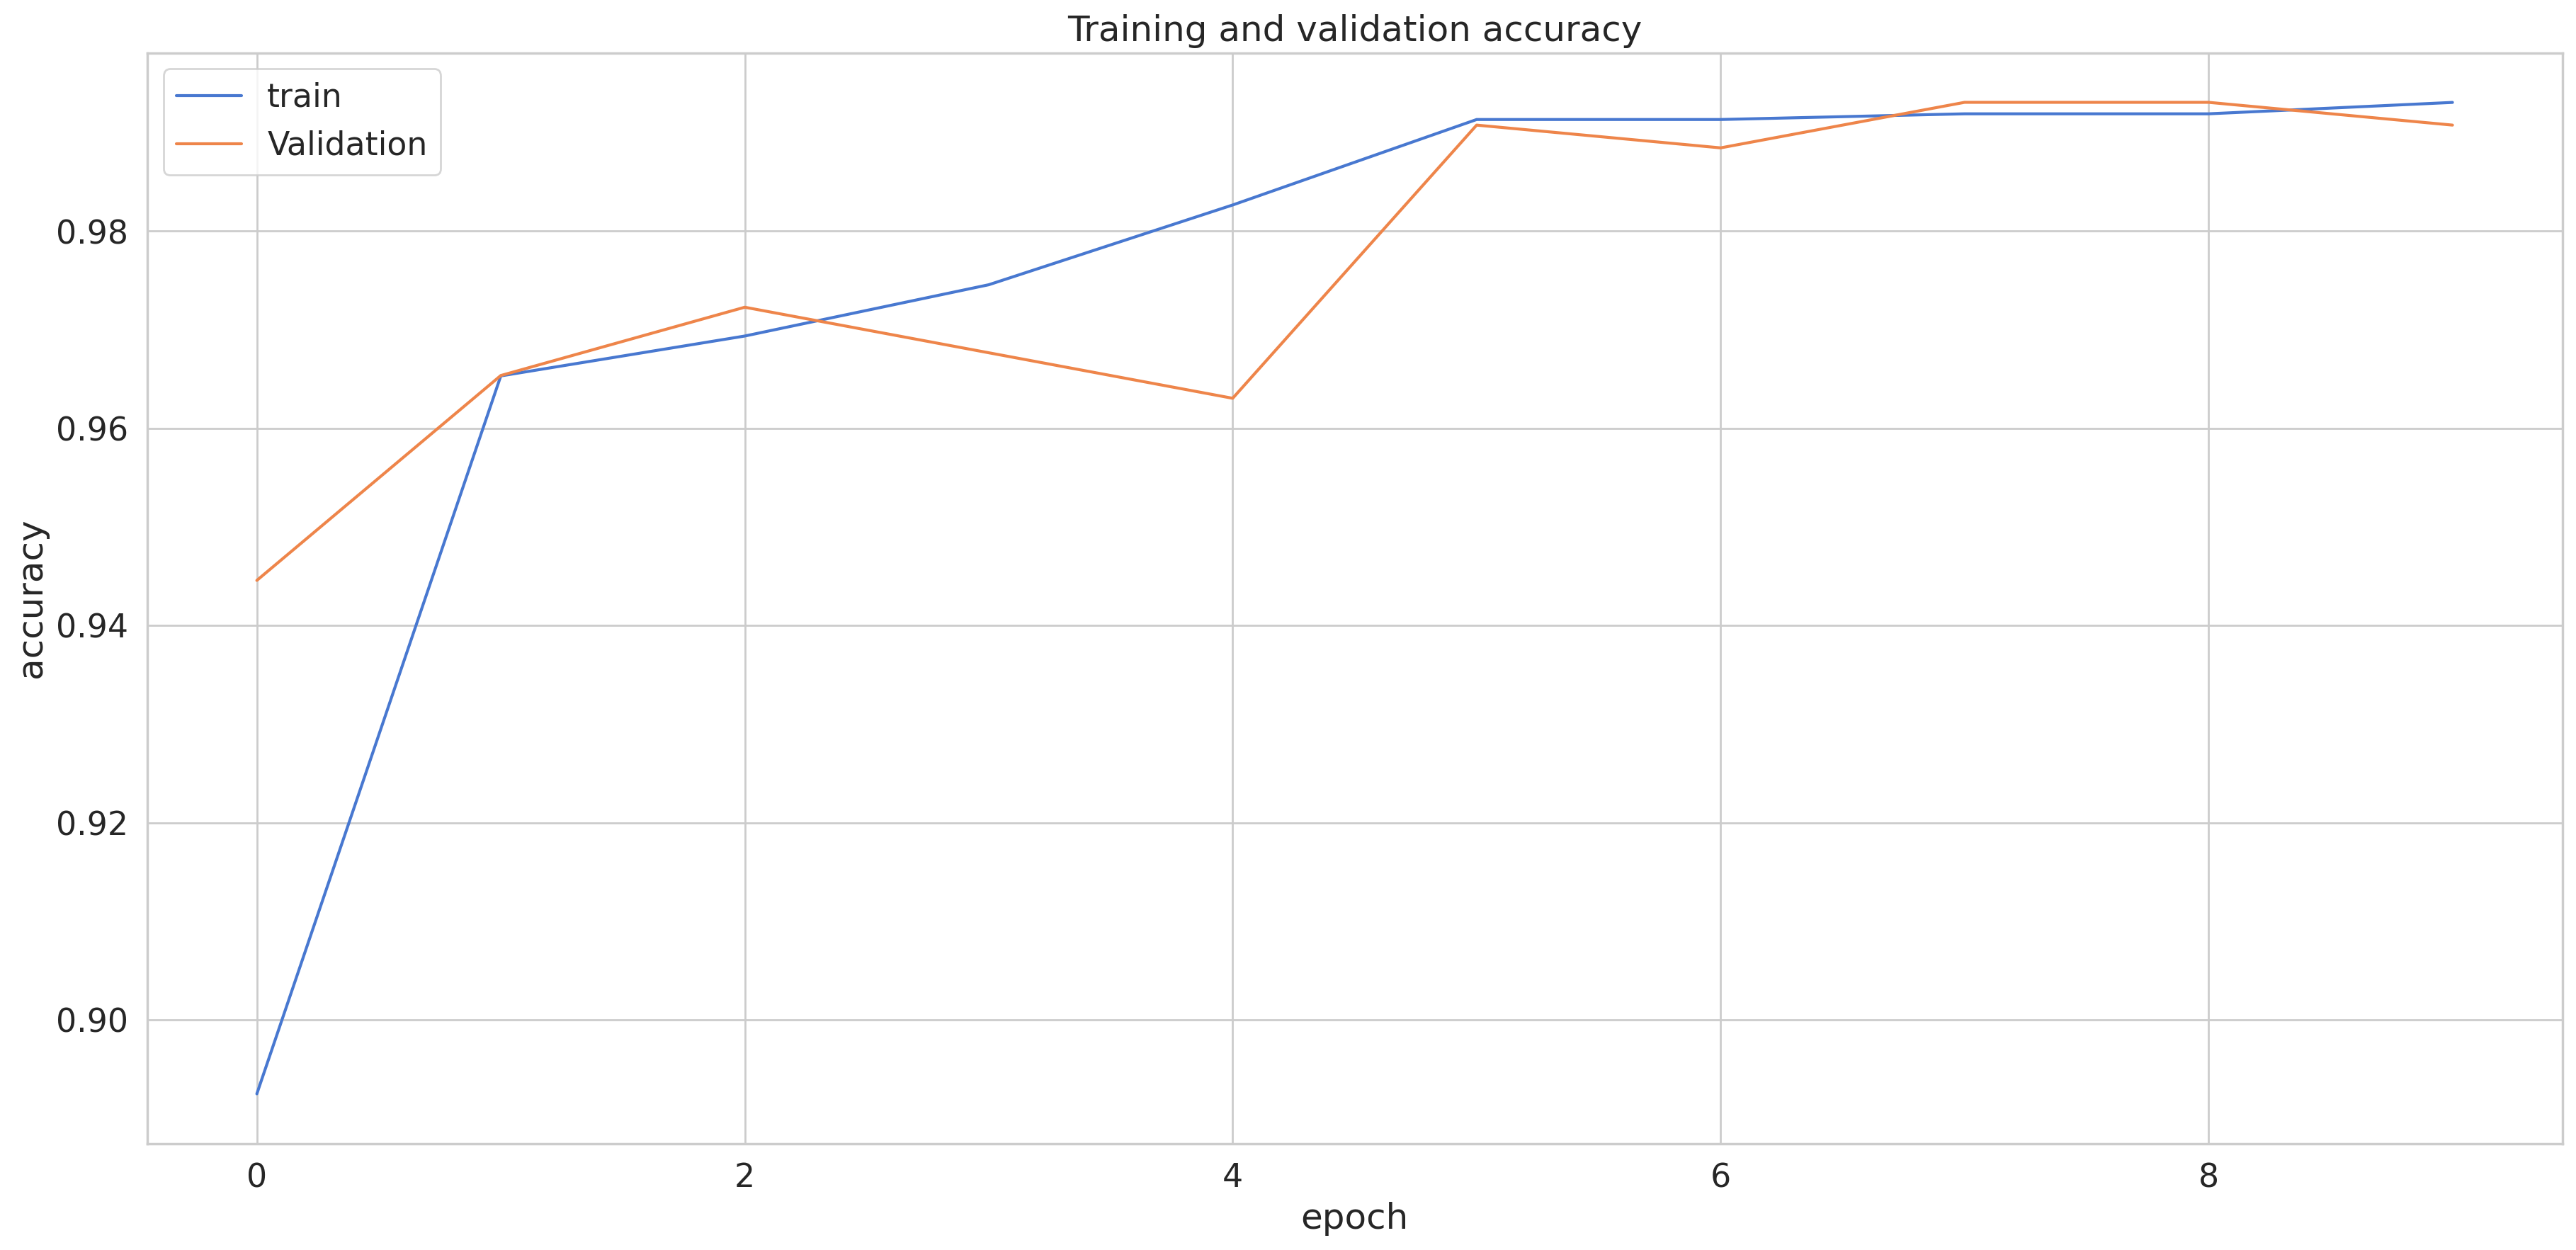

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

17/17 [==============================] - 2s 26ms/step
f1_score =  0.9907596433169779
0.9907578558225508
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       299
           1       0.99      0.99      0.99       242

    accuracy                           0.99       541
   macro avg       0.99      0.99      0.99       541
weighted avg       0.99      0.99      0.99       541



<Axes: >

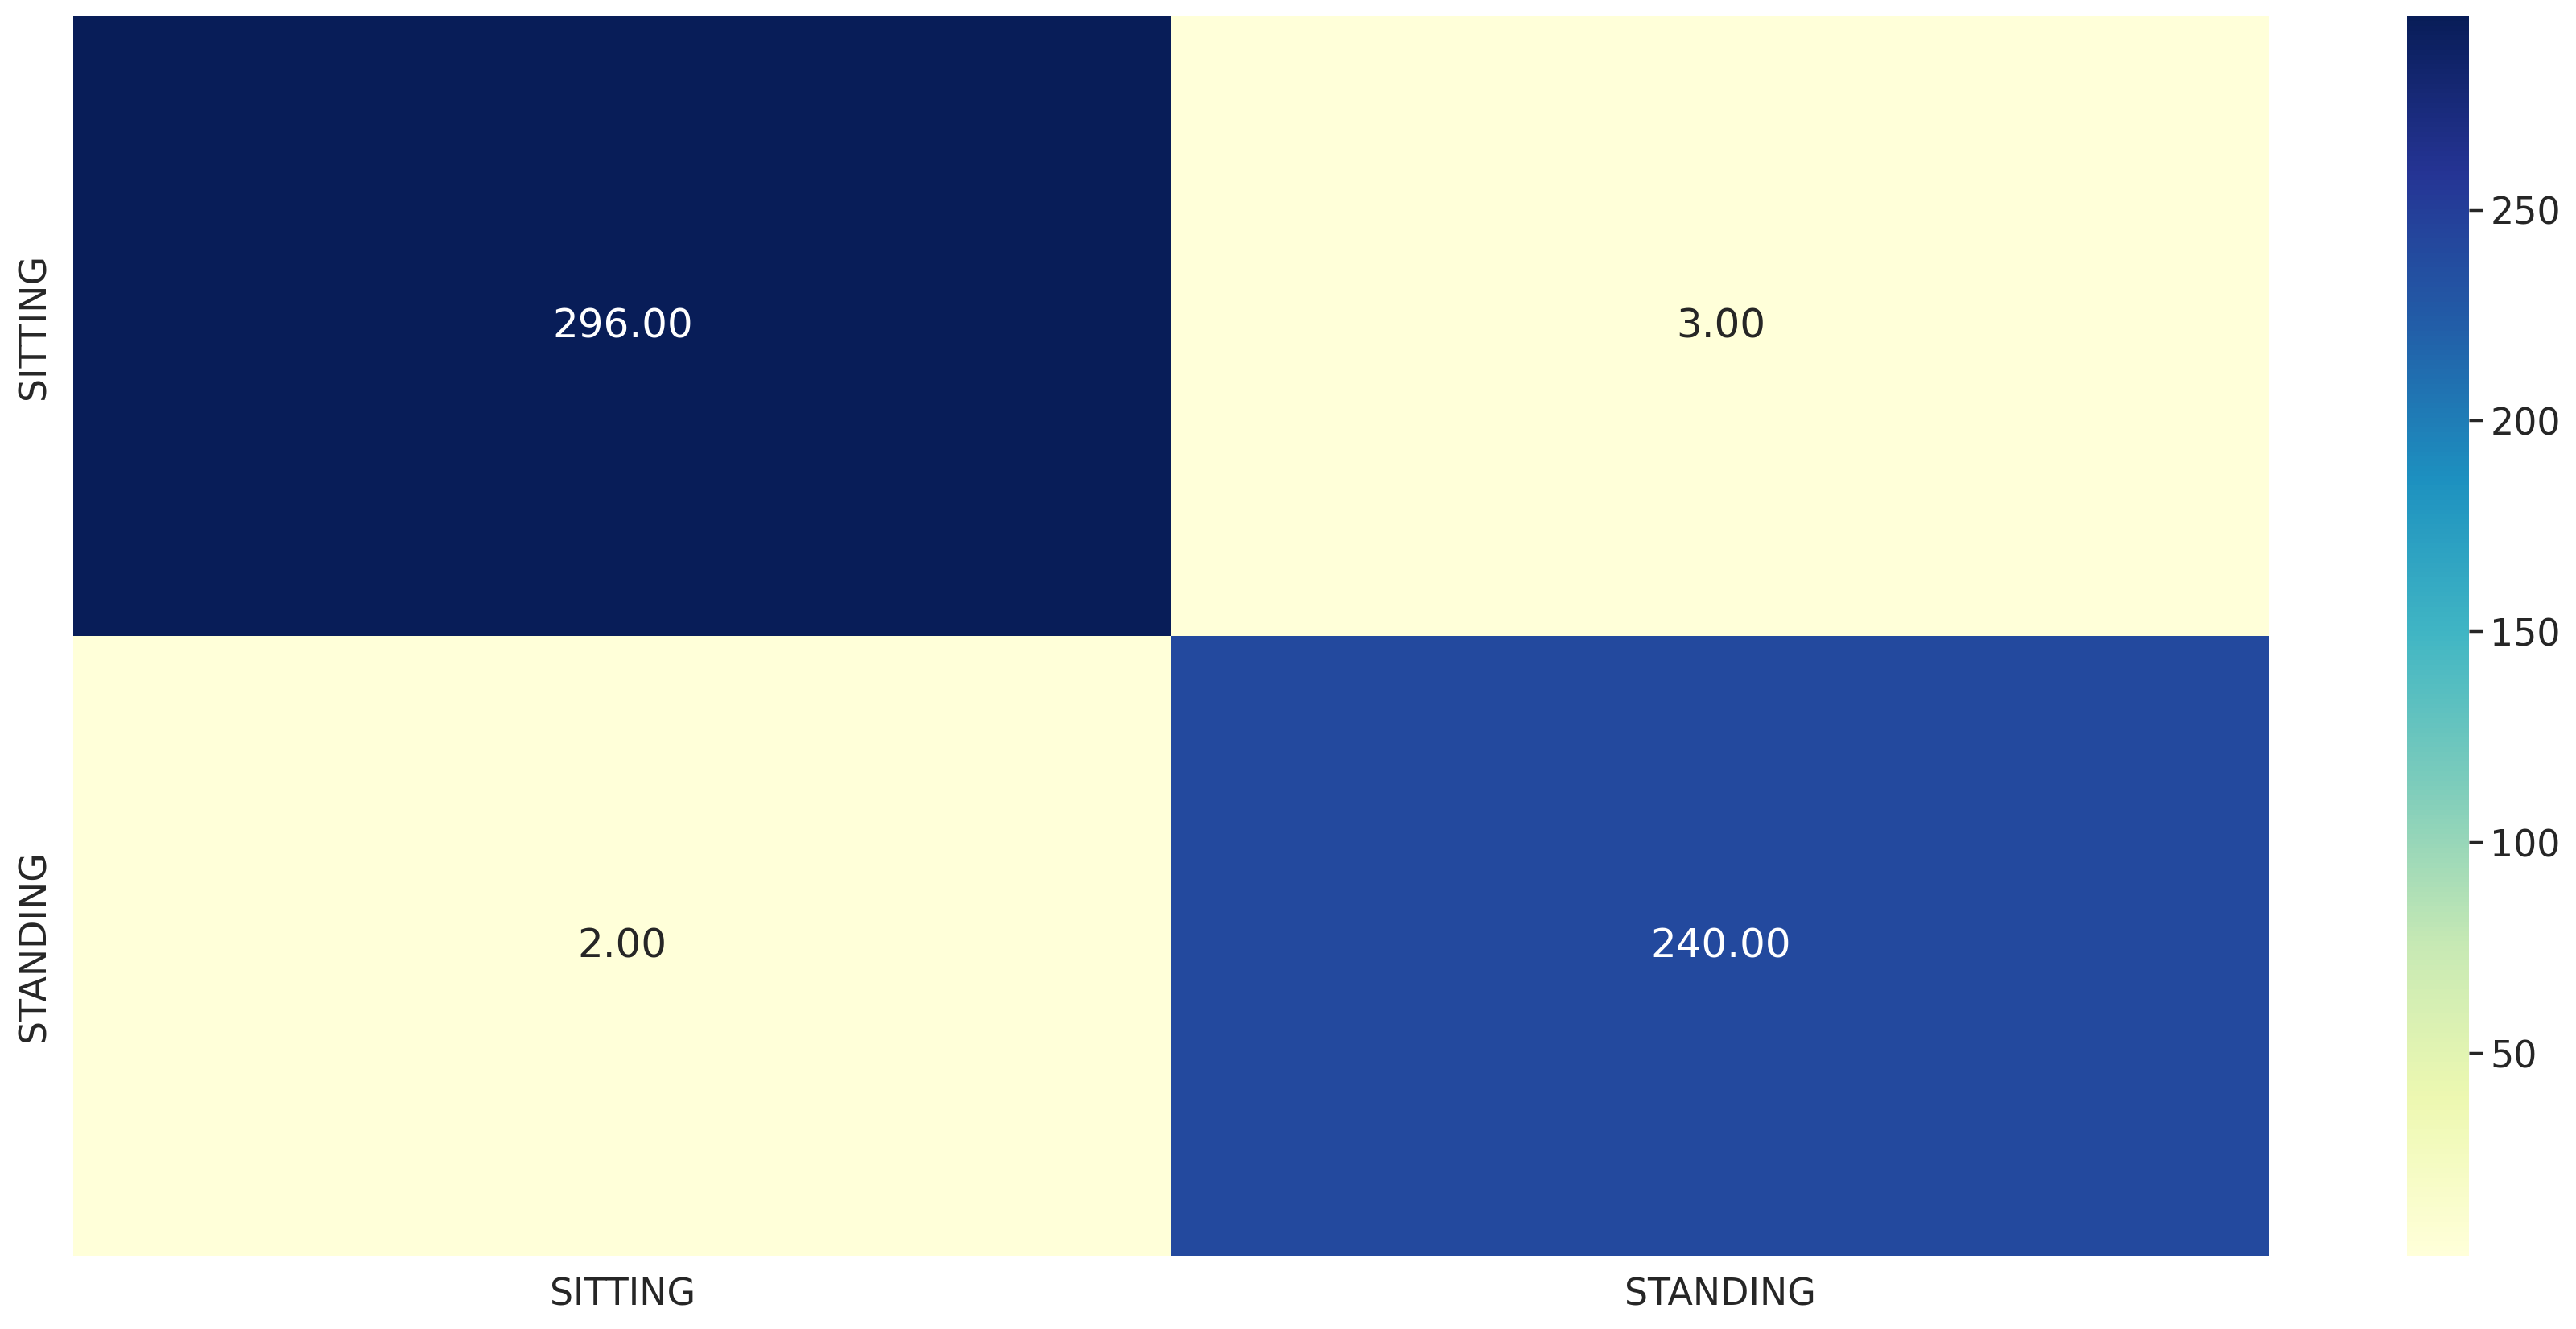

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['SITTING','STANDING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN3 - LSTM 1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeD  (None, None, 48, 64)      640       
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, None, 46, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, None, 46, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_21 (TimeD  (None, None, 23, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_22 (TimeD  (None, None, 21, 64)     

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
14/14 [==============================] - 6s 214ms/step - loss: 0.3144 - accuracy: 0.8734 - val_loss: 0.1785 - val_accuracy: 0.9446
Epoch 2/10
14/14 [==============================] - 2s 146ms/step - loss: 0.1304 - accuracy: 0.9566 - val_loss: 0.1314 - val_accuracy: 0.9469
Epoch 3/10
14/14 [==============================] - 3s 195ms/step - loss: 0.1023 - accuracy: 0.9520 - val_loss: 0.1185 - val_accuracy: 0.9630
Epoch 4/10
14/14 [==============================] - 4s 253ms/step - loss: 0.0922 - accuracy: 0.9694 - val_loss: 0.0966 - val_accuracy: 0.9630
Epoch 5/10
14/14 [==============================] - 3s 237ms/step - loss: 0.0726 - accuracy: 0.9746 - val_loss: 0.0815 - val_accuracy: 0.9654
Epoch 6/10
14/14 [==============================] - 2s 154ms/step - loss: 0.0542 - accuracy: 0.9861 - val_loss: 0.0610 - val_accuracy: 0.9885
Epoch 7/10
14/14 [==============================] - 2s 154ms/step - loss: 0.0508 - accuracy: 0.9873 - val_loss: 0.0499 - val_accuracy: 0.9861
Epoch 

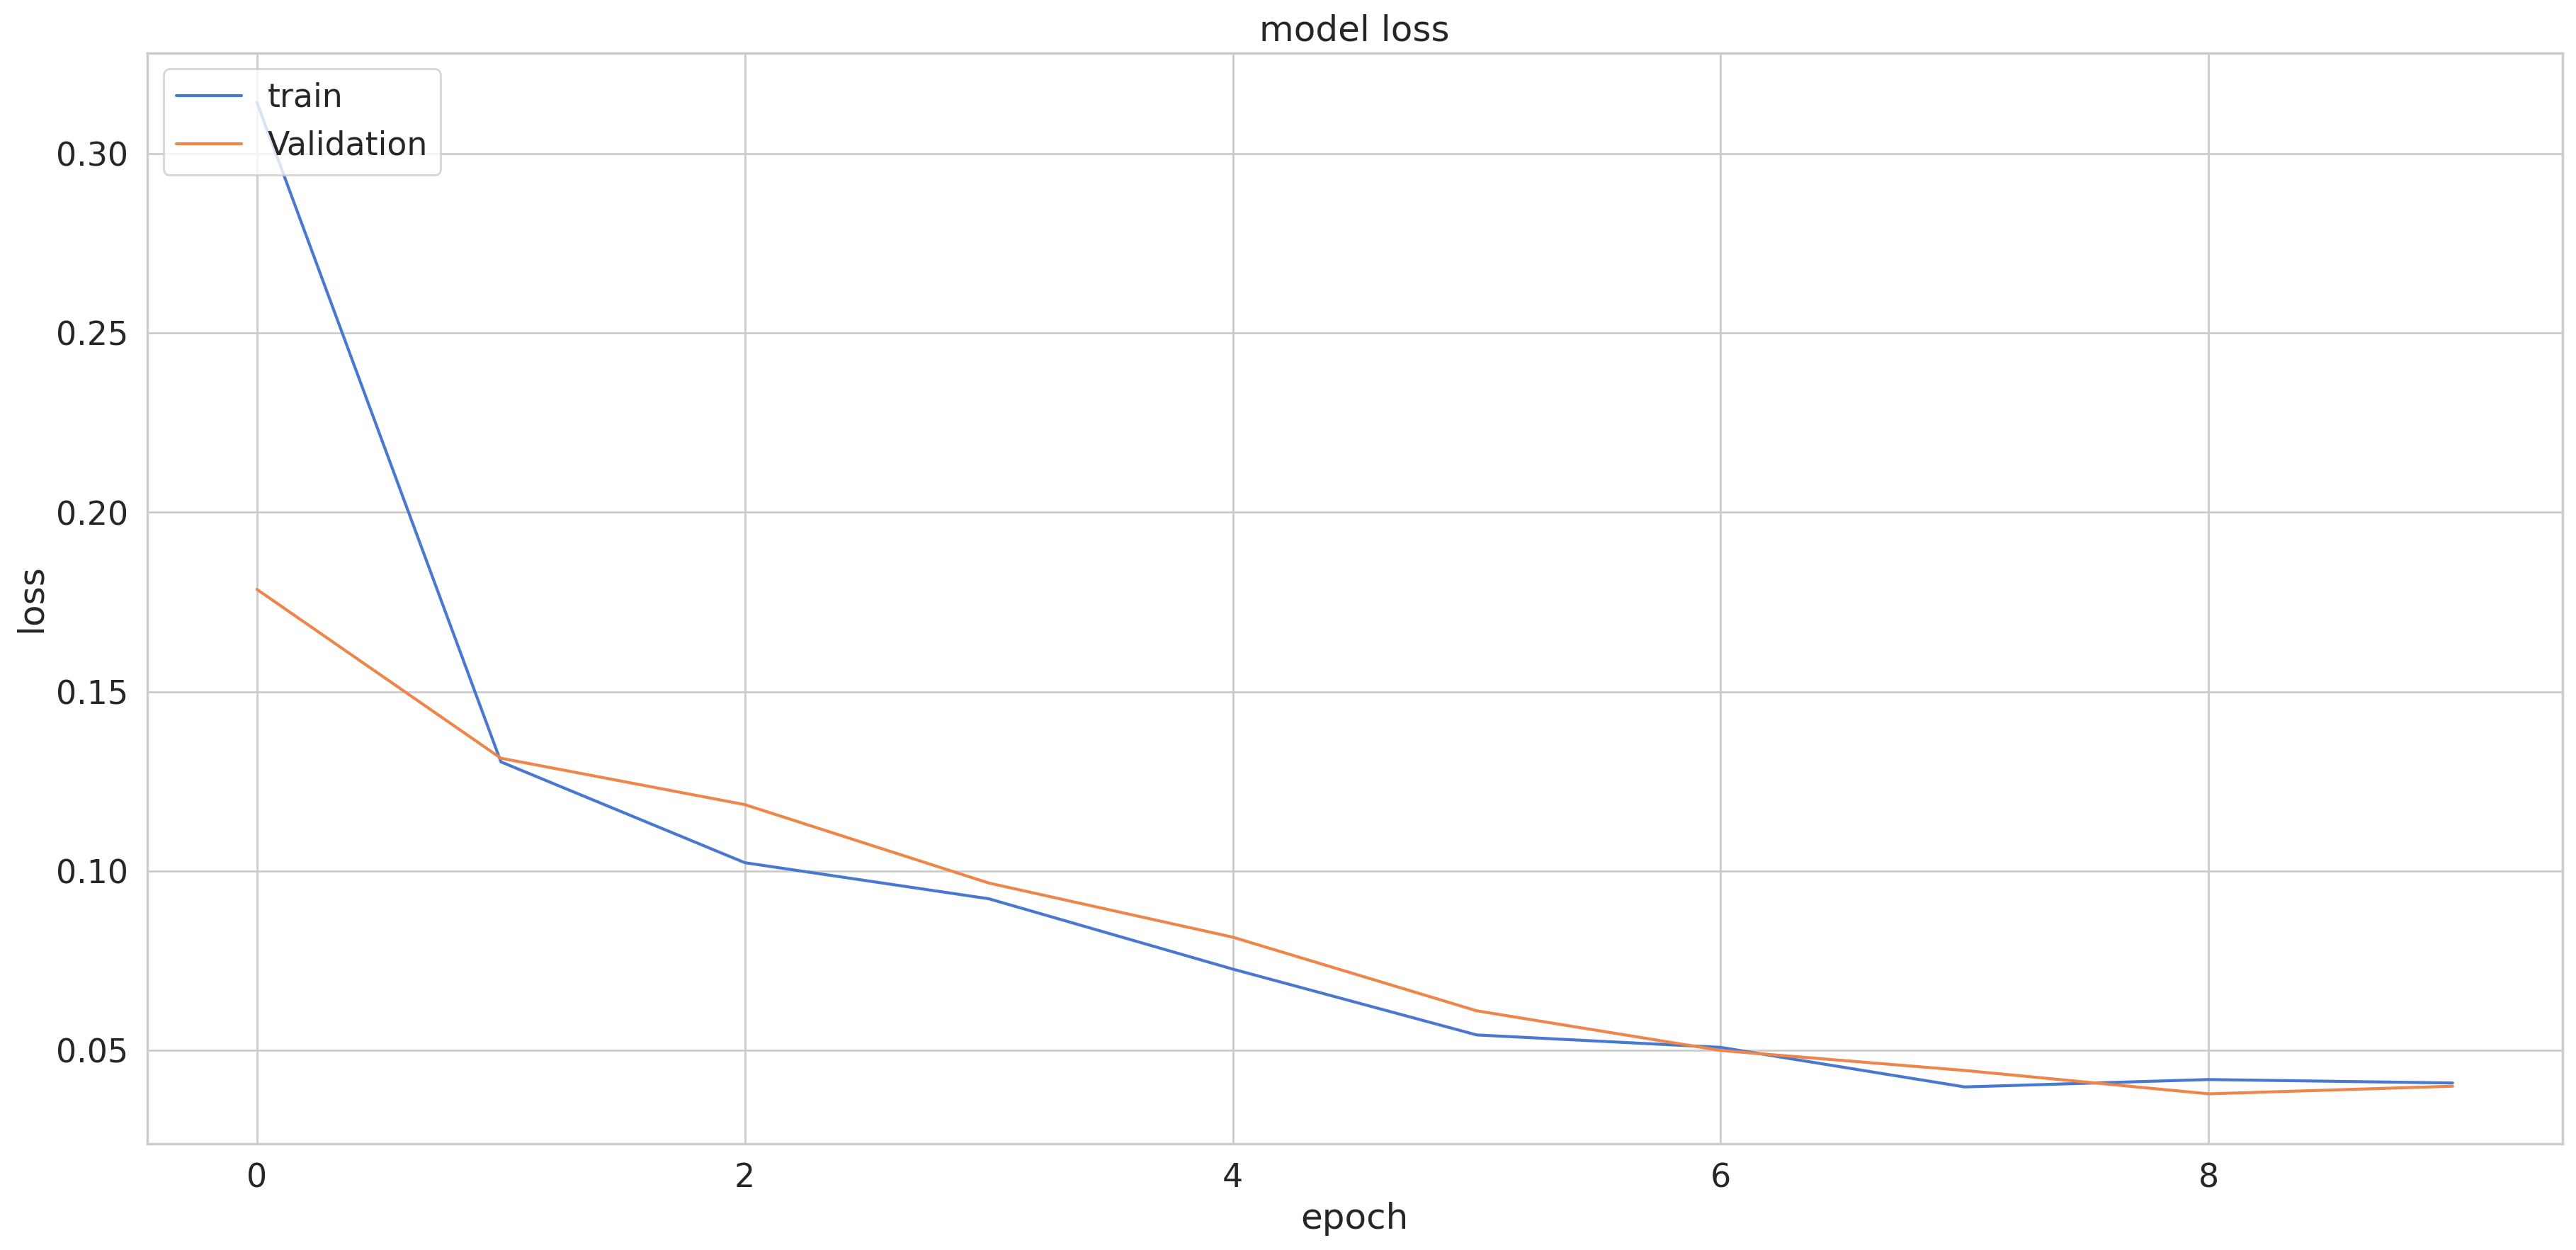

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

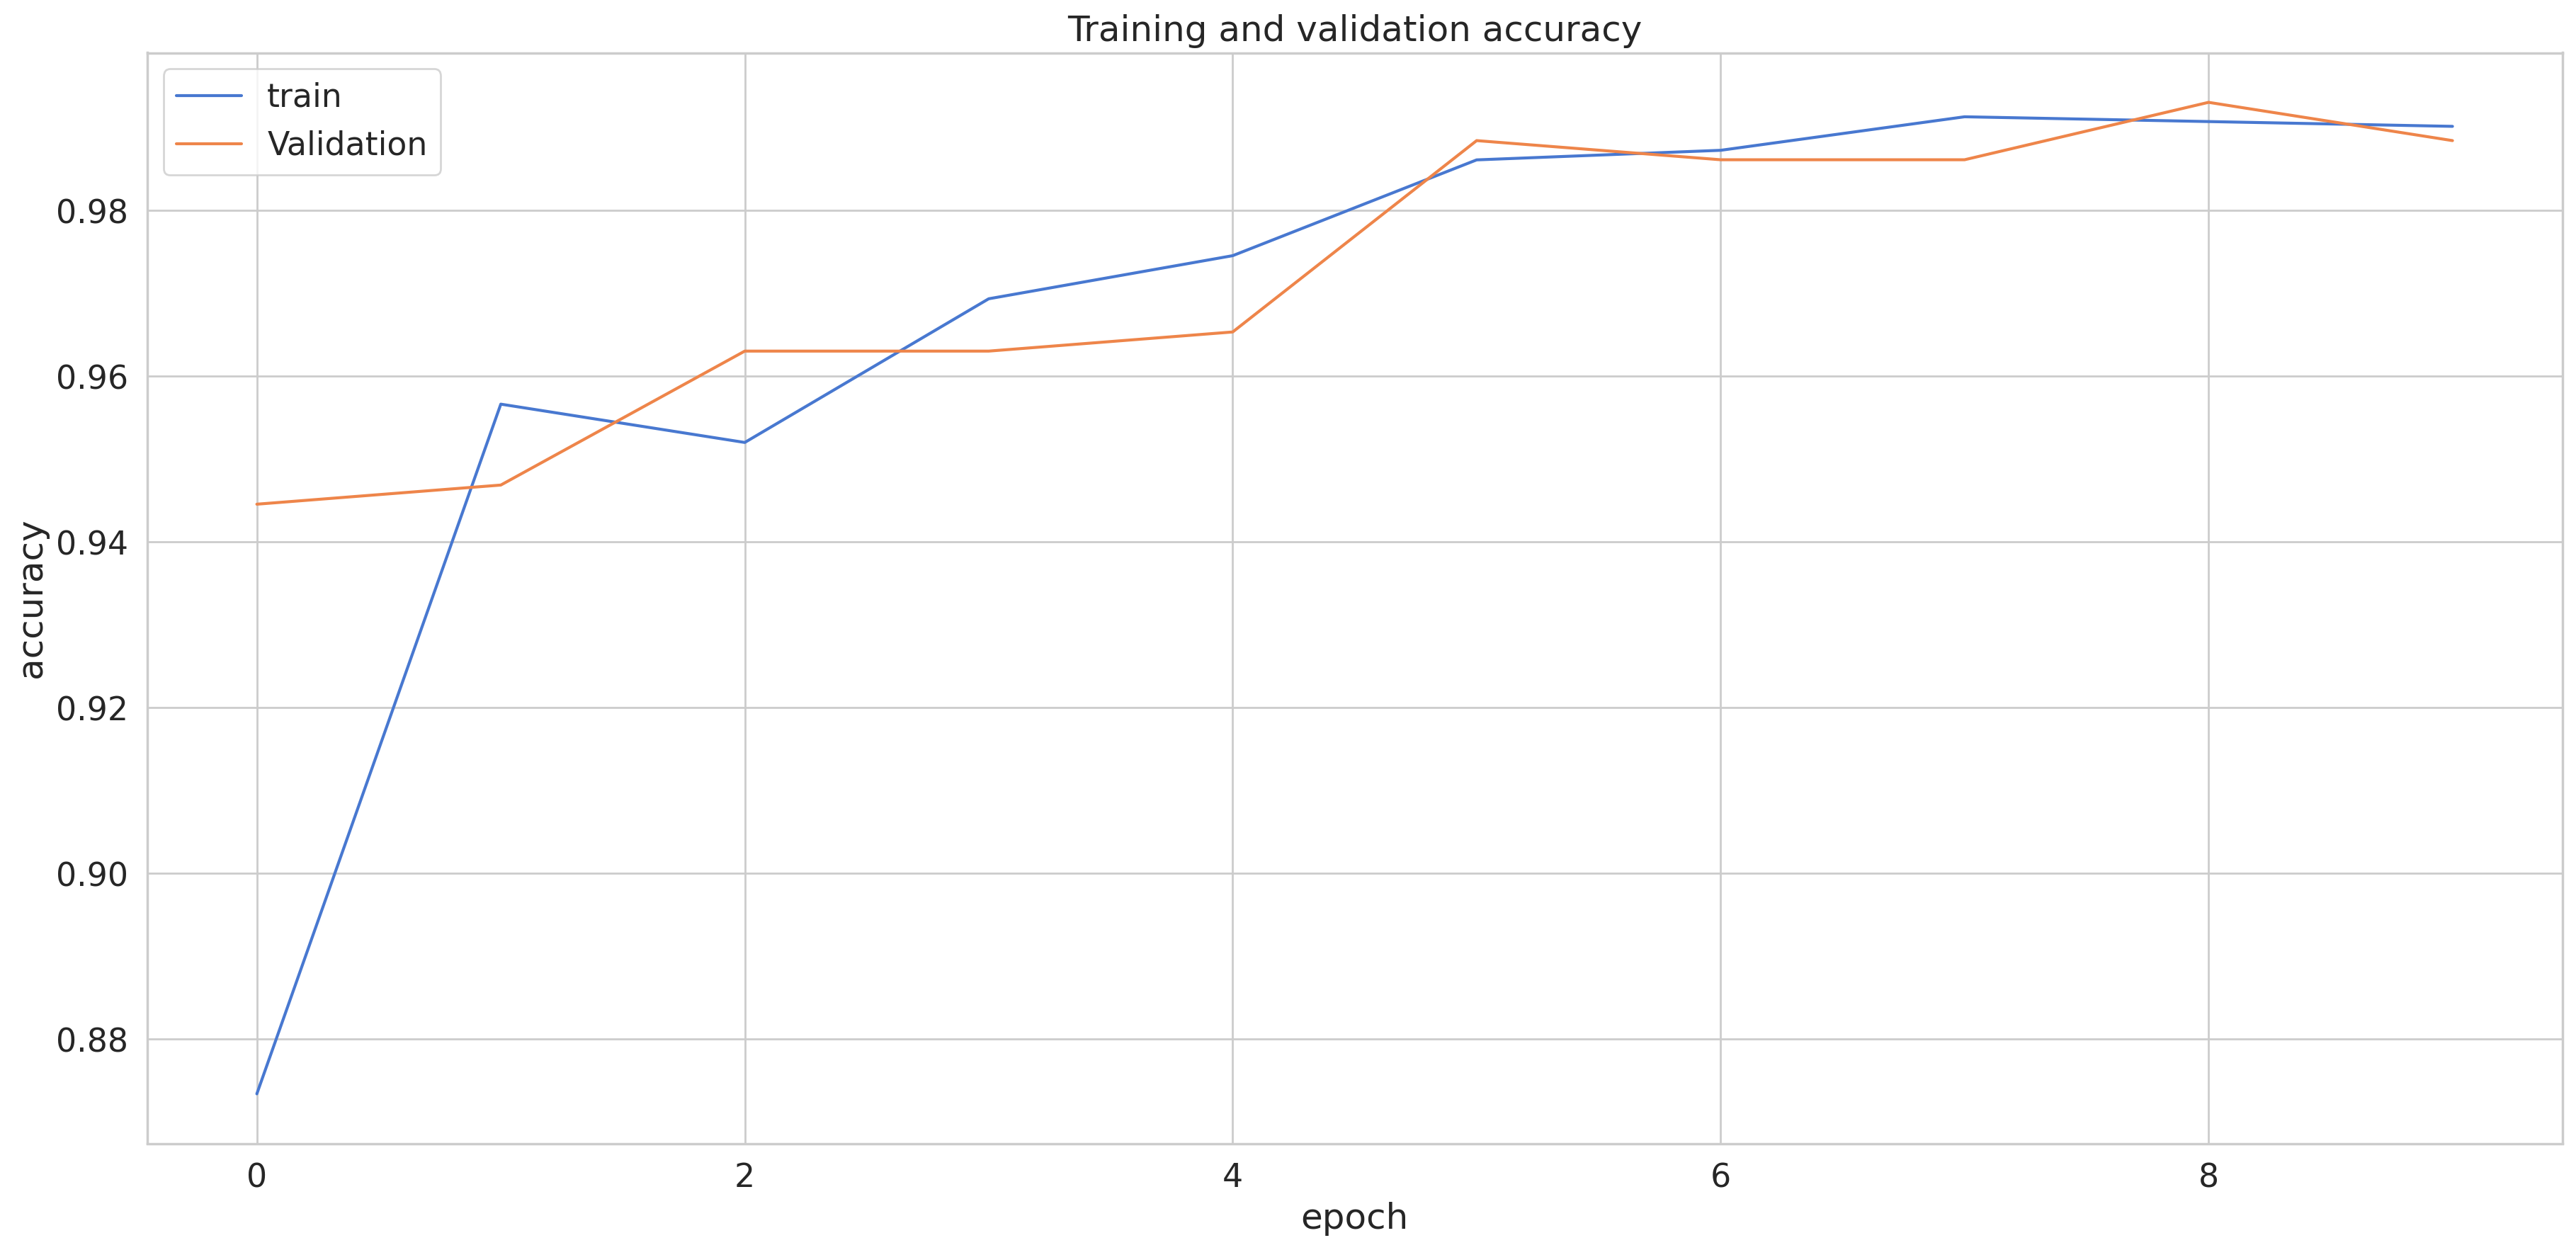

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

17/17 [==============================] - 1s 26ms/step
f1_score =  0.9870725995560985
0.9870609981515711
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       299
           1       0.98      1.00      0.99       242

    accuracy                           0.99       541
   macro avg       0.99      0.99      0.99       541
weighted avg       0.99      0.99      0.99       541



<Axes: >

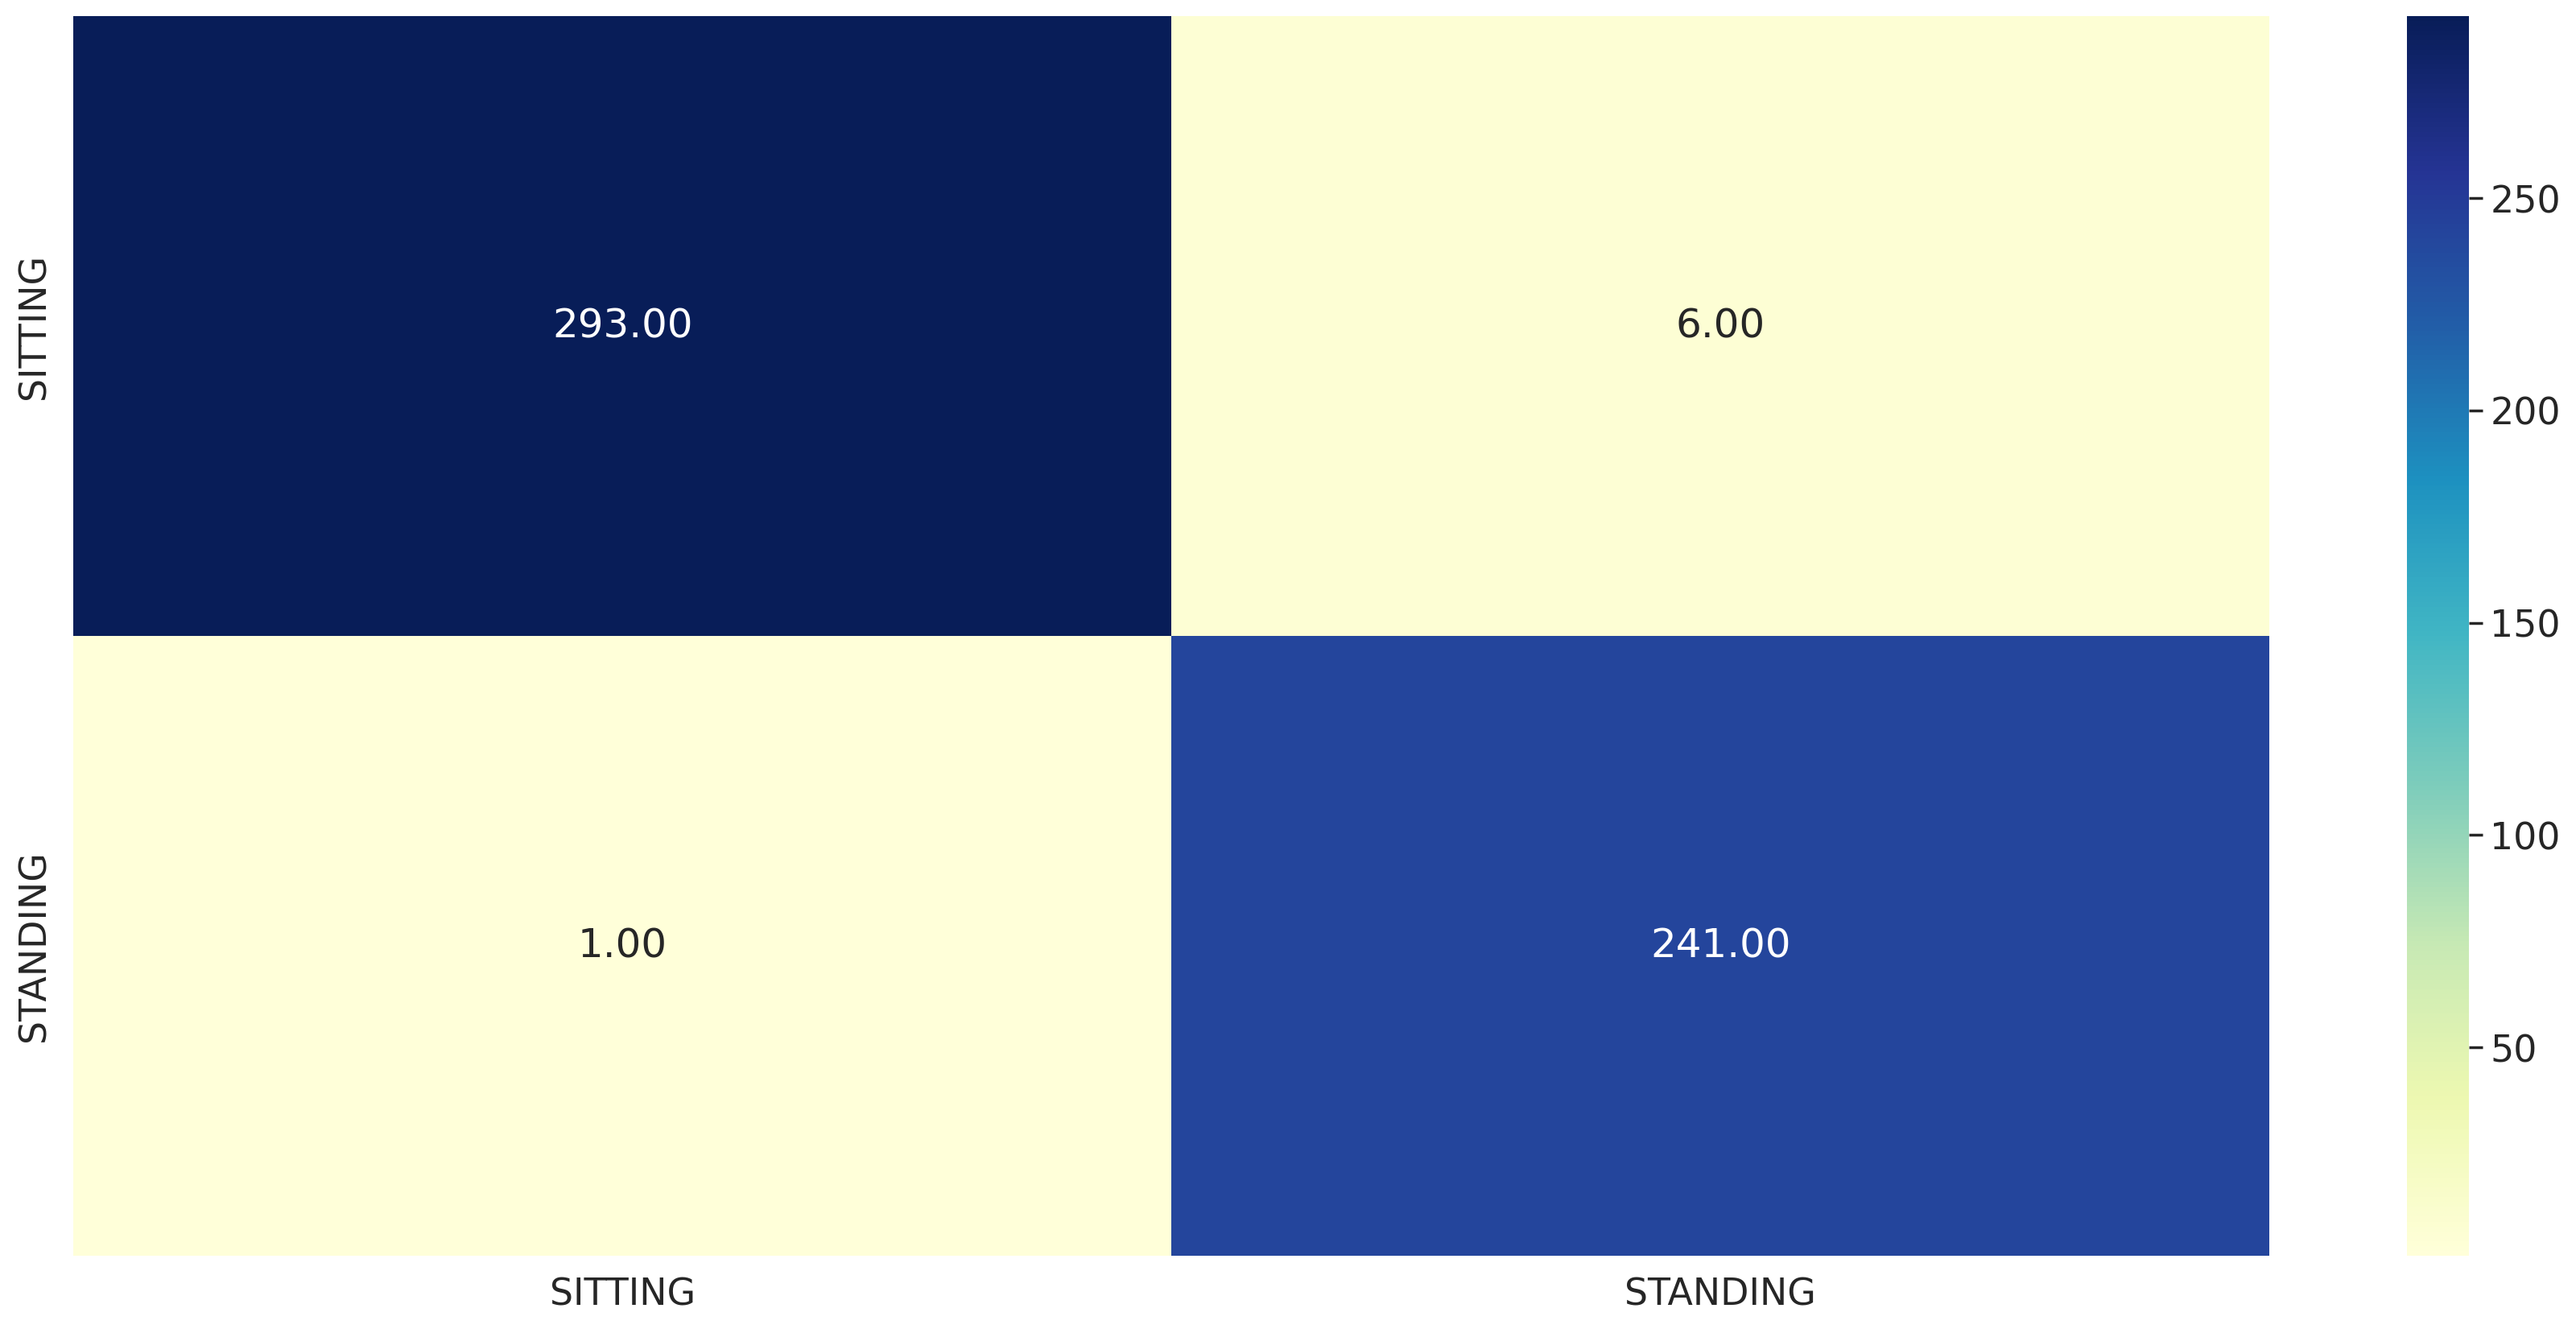

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['SITTING','STANDING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Layer 5

# CNN4 -LSTM1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeD  (None, None, 48, 64)      640       
 istributed)                                                     
                                                                 
 time_distributed_27 (TimeD  (None, None, 46, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_28 (TimeD  (None, None, 46, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_29 (TimeD  (None, None, 23, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_30 (TimeD  (None, None, 21, 64)     

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
14/14 [==============================] - 7s 220ms/step - loss: 0.3451 - accuracy: 0.8364 - val_loss: 0.1680 - val_accuracy: 0.9446
Epoch 2/10
14/14 [==============================] - 2s 172ms/step - loss: 0.1306 - accuracy: 0.9572 - val_loss: 0.1230 - val_accuracy: 0.9630
Epoch 3/10
14/14 [==============================] - 4s 276ms/step - loss: 0.0970 - accuracy: 0.9682 - val_loss: 0.1023 - val_accuracy: 0.9630
Epoch 4/10
14/14 [==============================] - 4s 293ms/step - loss: 0.0720 - accuracy: 0.9734 - val_loss: 0.0764 - val_accuracy: 0.9769
Epoch 5/10
14/14 [==============================] - 3s 179ms/step - loss: 0.0532 - accuracy: 0.9896 - val_loss: 0.0511 - val_accuracy: 0.9908
Epoch 6/10
14/14 [==============================] - 2s 173ms/step - loss: 0.0498 - accuracy: 0.9884 - val_loss: 0.0649 - val_accuracy: 0.9792
Epoch 7/10
14/14 [==============================] - 2s 173ms/step - loss: 0.0490 - accuracy: 0.9861 - val_loss: 0.0535 - val_accuracy: 0.9838
Epoch 

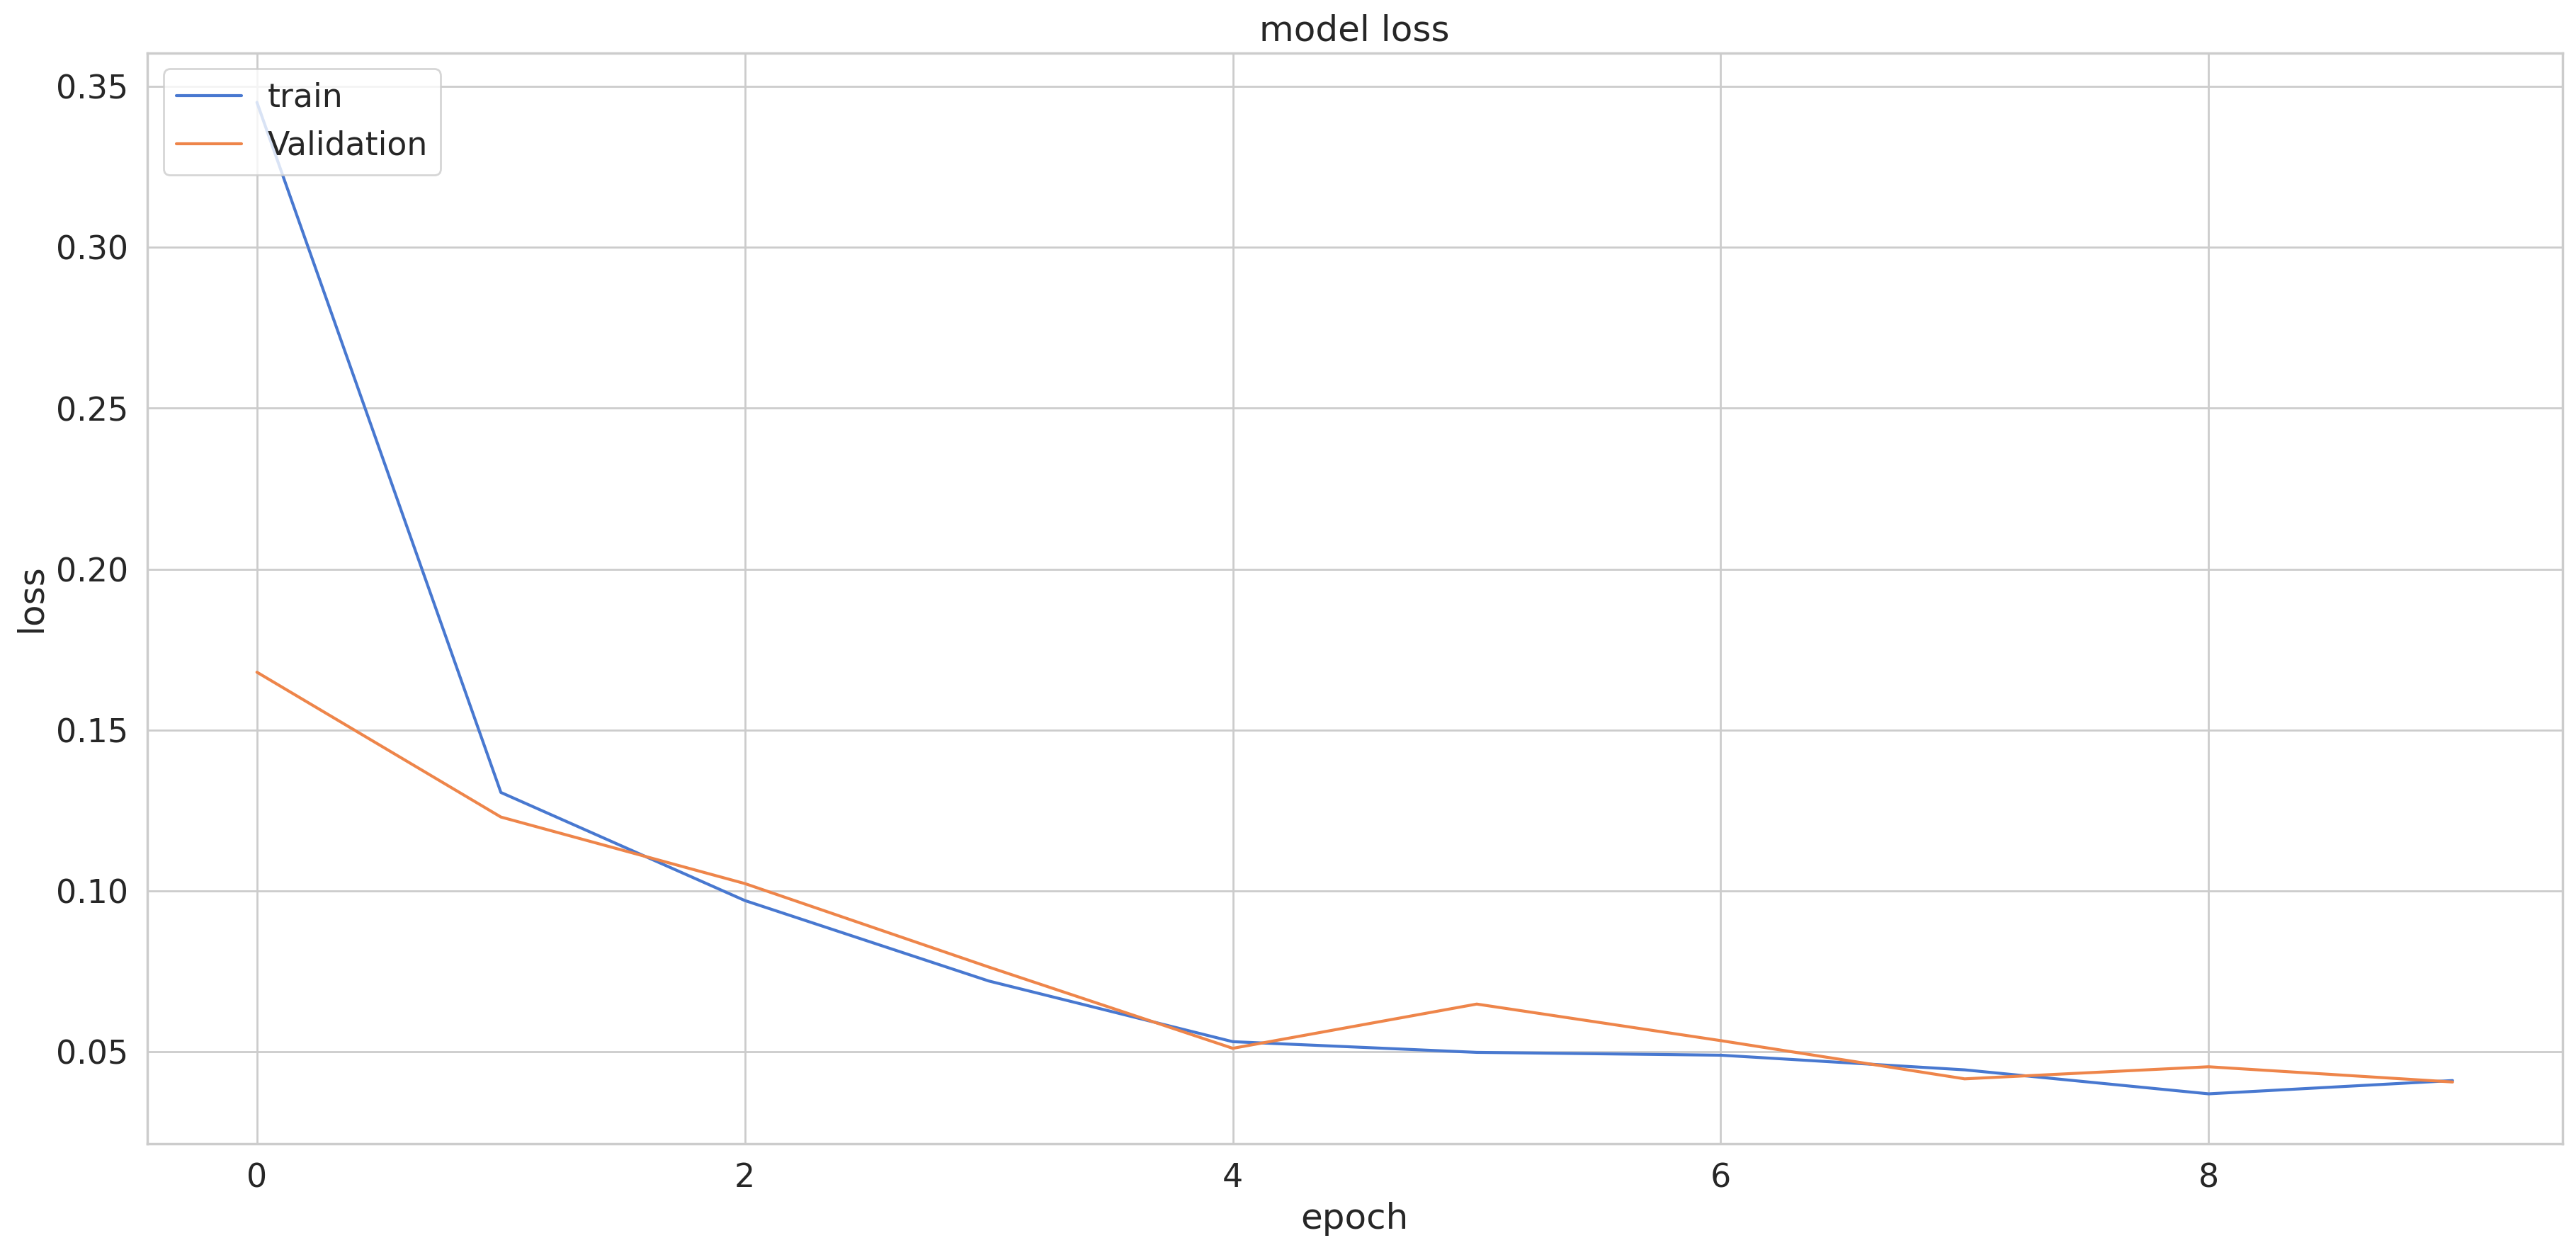

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

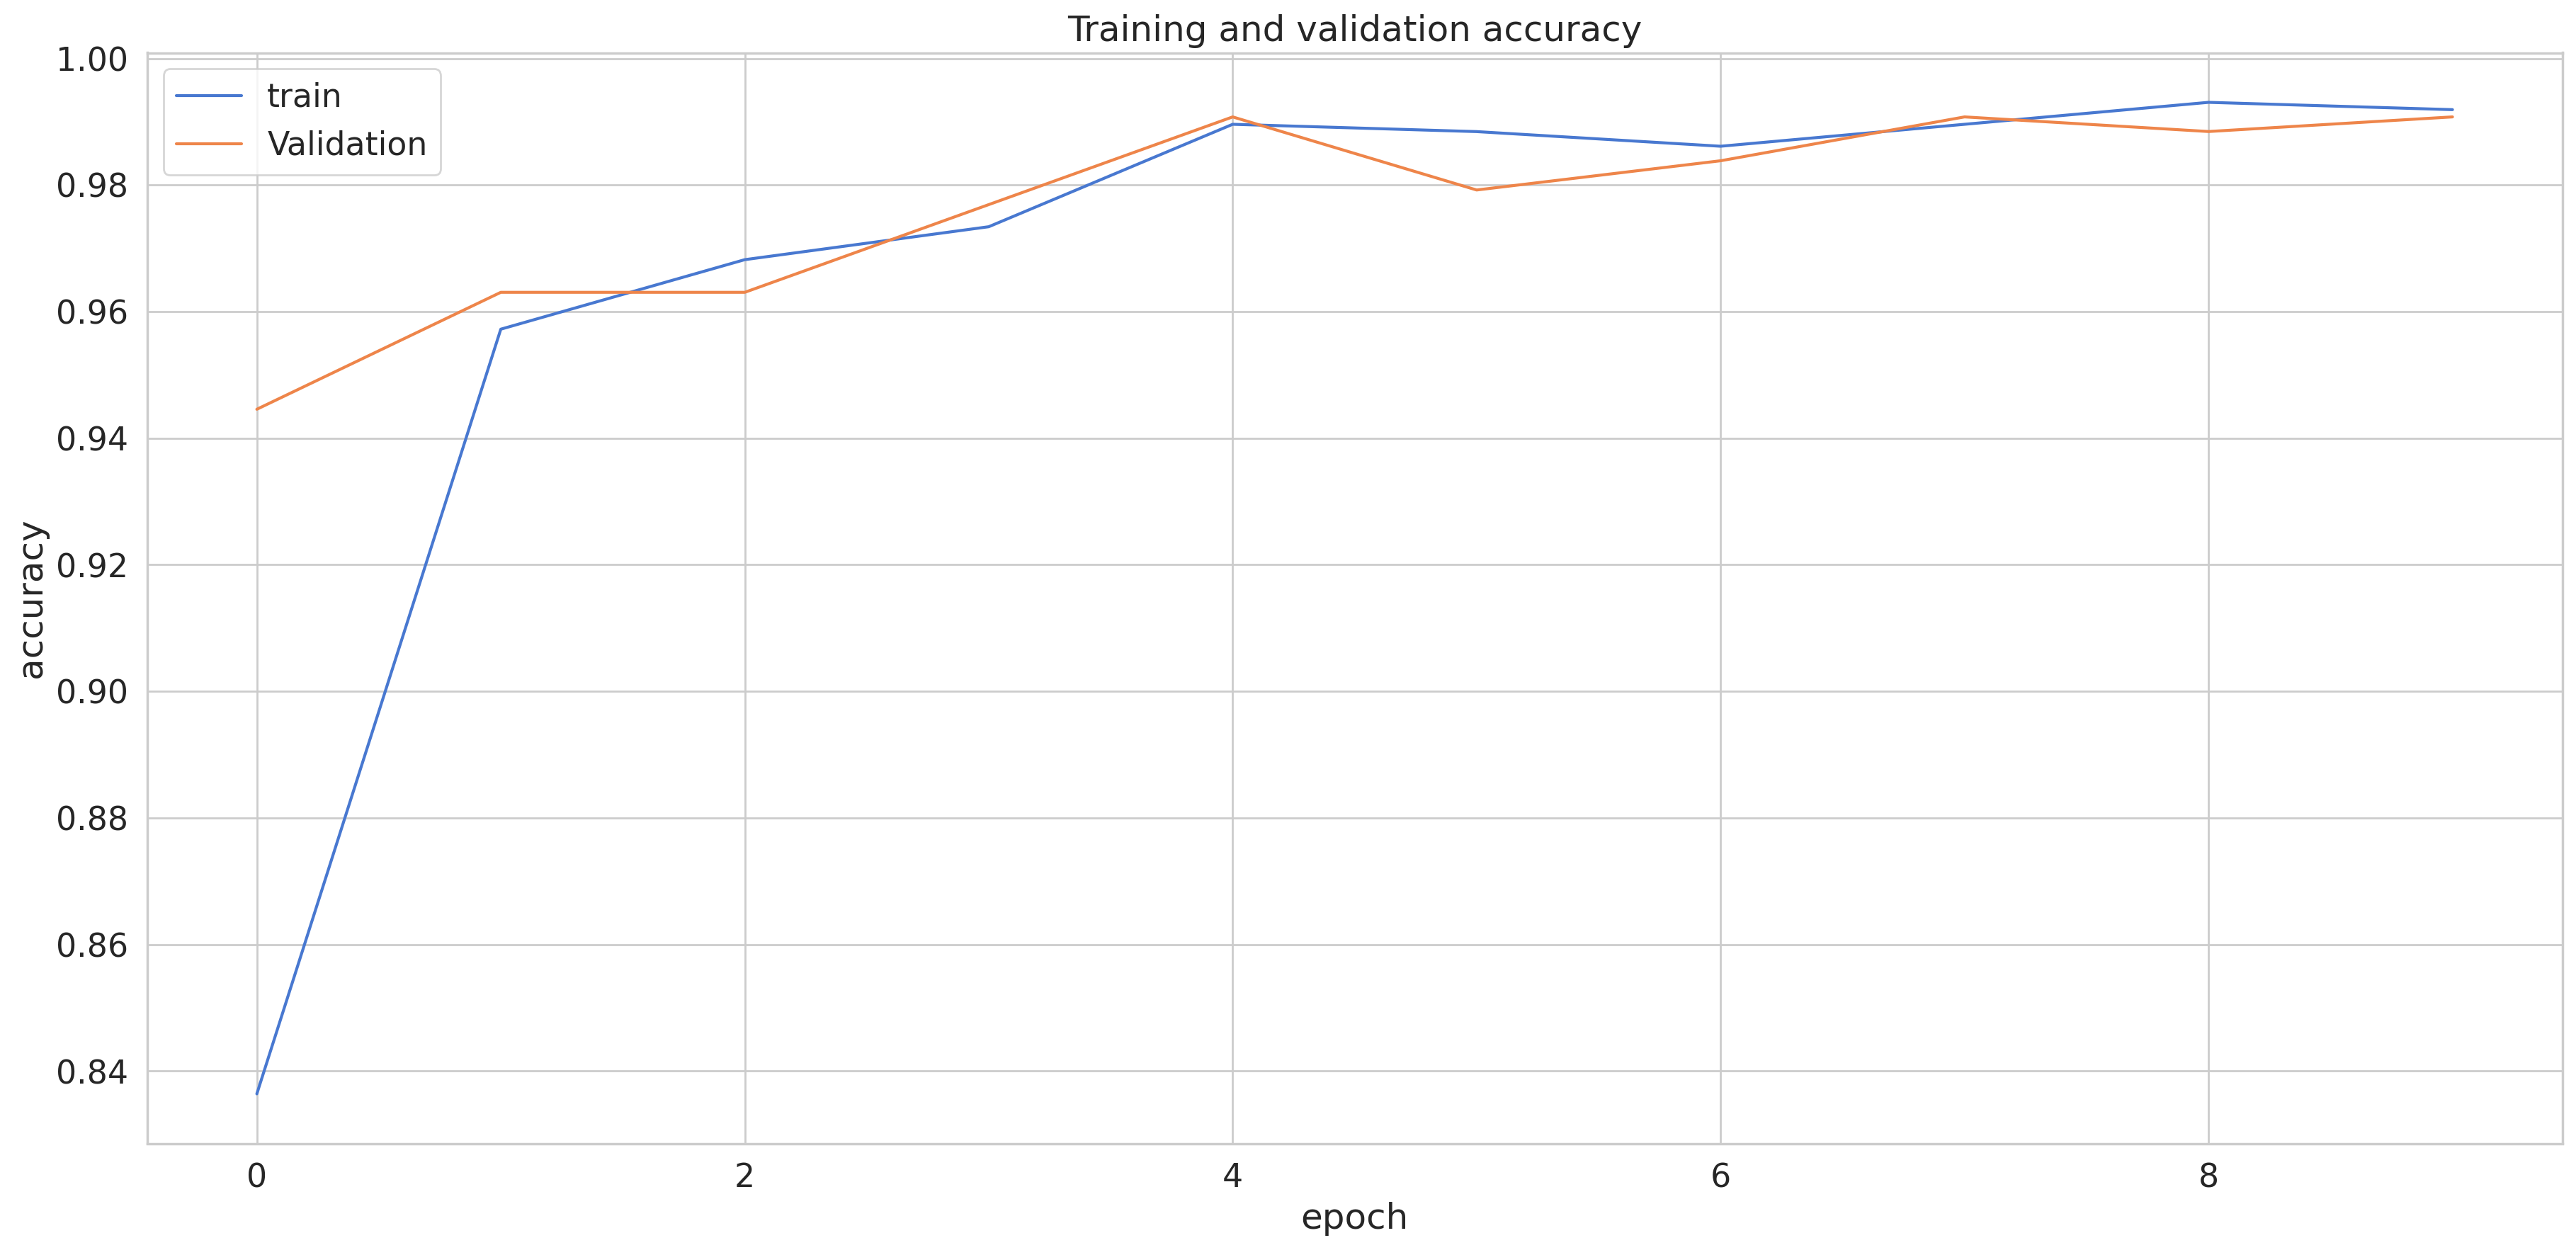

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

17/17 [==============================] - 3s 26ms/step
f1_score =  0.9907596433169779
0.9907578558225508
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       299
           1       0.99      0.99      0.99       242

    accuracy                           0.99       541
   macro avg       0.99      0.99      0.99       541
weighted avg       0.99      0.99      0.99       541



<Axes: >

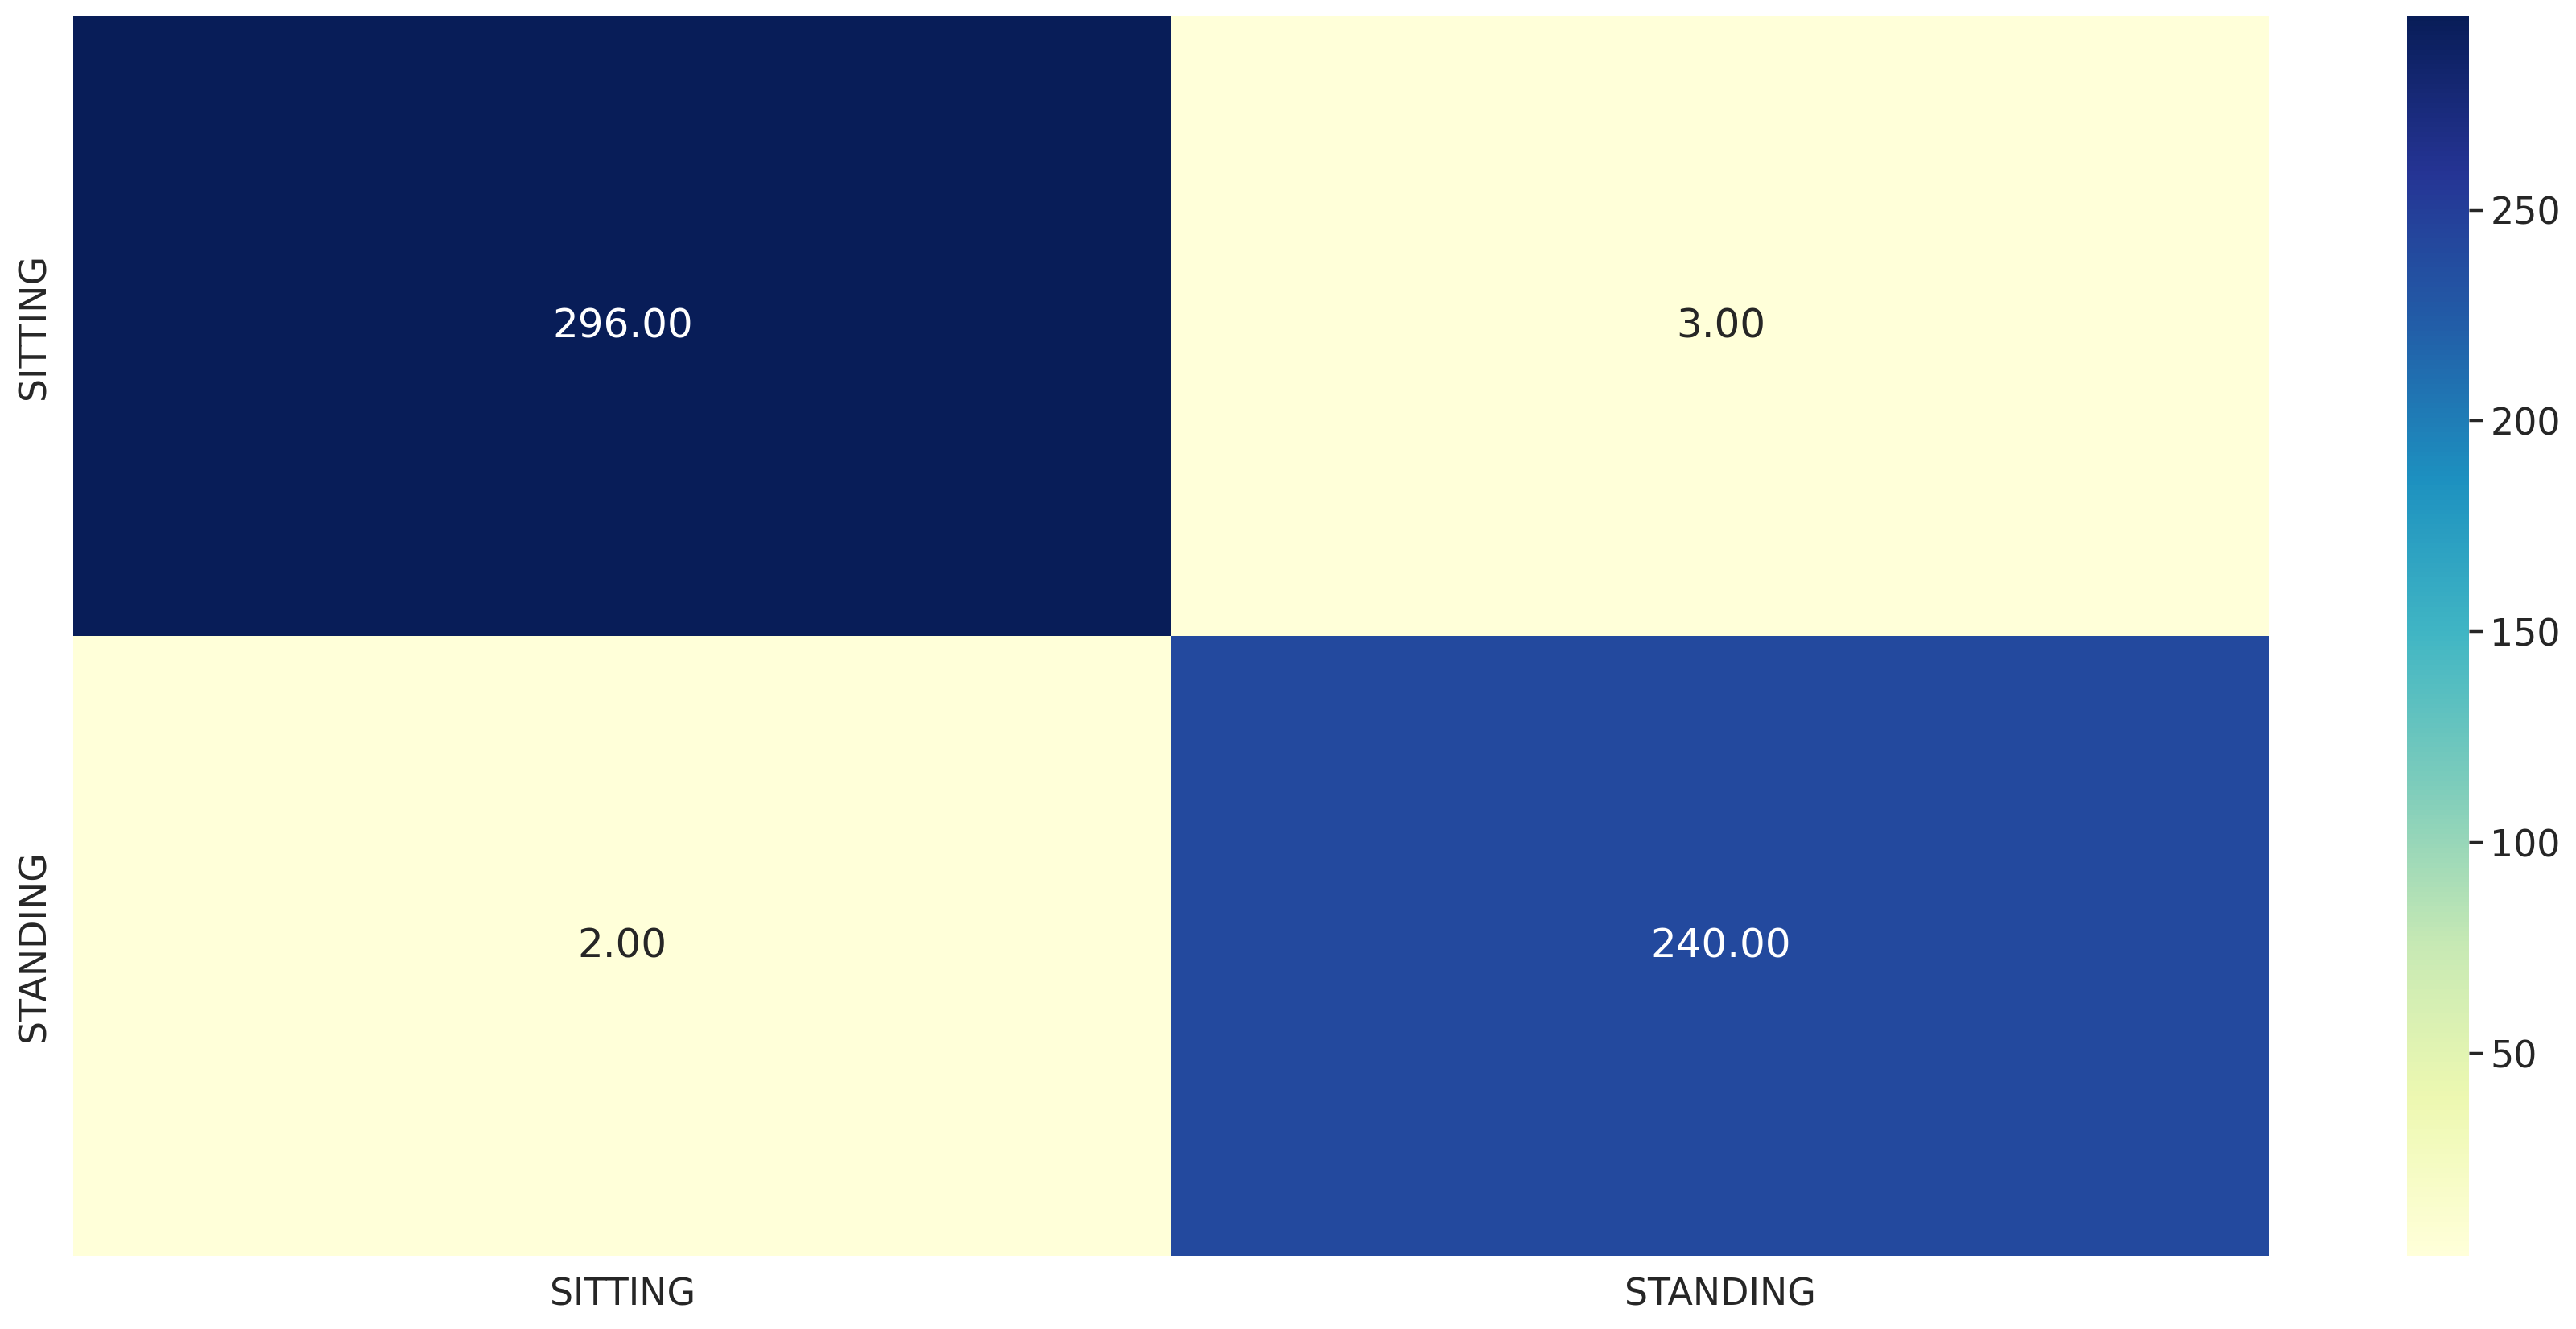

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['SITTING','STANDING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')


# CNN3 - LSTM2

In [16]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 48, 64)      640       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 46, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 46, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, None, 23, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, None, 21, 64)      1

In [17]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
14/14 [==============================] - 7s 263ms/step - loss: 0.3917 - accuracy: 0.8780 - val_loss: 0.1467 - val_accuracy: 0.9515
Epoch 2/10
14/14 [==============================] - 3s 223ms/step - loss: 0.1386 - accuracy: 0.9486 - val_loss: 0.0838 - val_accuracy: 0.9607
Epoch 3/10
14/14 [==============================] - 2s 141ms/step - loss: 0.1002 - accuracy: 0.9543 - val_loss: 0.0613 - val_accuracy: 0.9769
Epoch 4/10
14/14 [==============================] - 1s 93ms/step - loss: 0.0846 - accuracy: 0.9636 - val_loss: 0.0529 - val_accuracy: 0.9769
Epoch 5/10
14/14 [==============================] - 1s 92ms/step - loss: 0.0686 - accuracy: 0.9775 - val_loss: 0.0418 - val_accuracy: 0.9769
Epoch 6/10
14/14 [==============================] - 1s 92ms/step - loss: 0.0555 - accuracy: 0.9844 - val_loss: 0.0564 - val_accuracy: 0.9792
Epoch 7/10
14/14 [==============================] - 1s 92ms/step - loss: 0.0669 - accuracy: 0.9792 - val_loss: 0.0701 - val_accuracy: 0.9746
Epoch 8/10

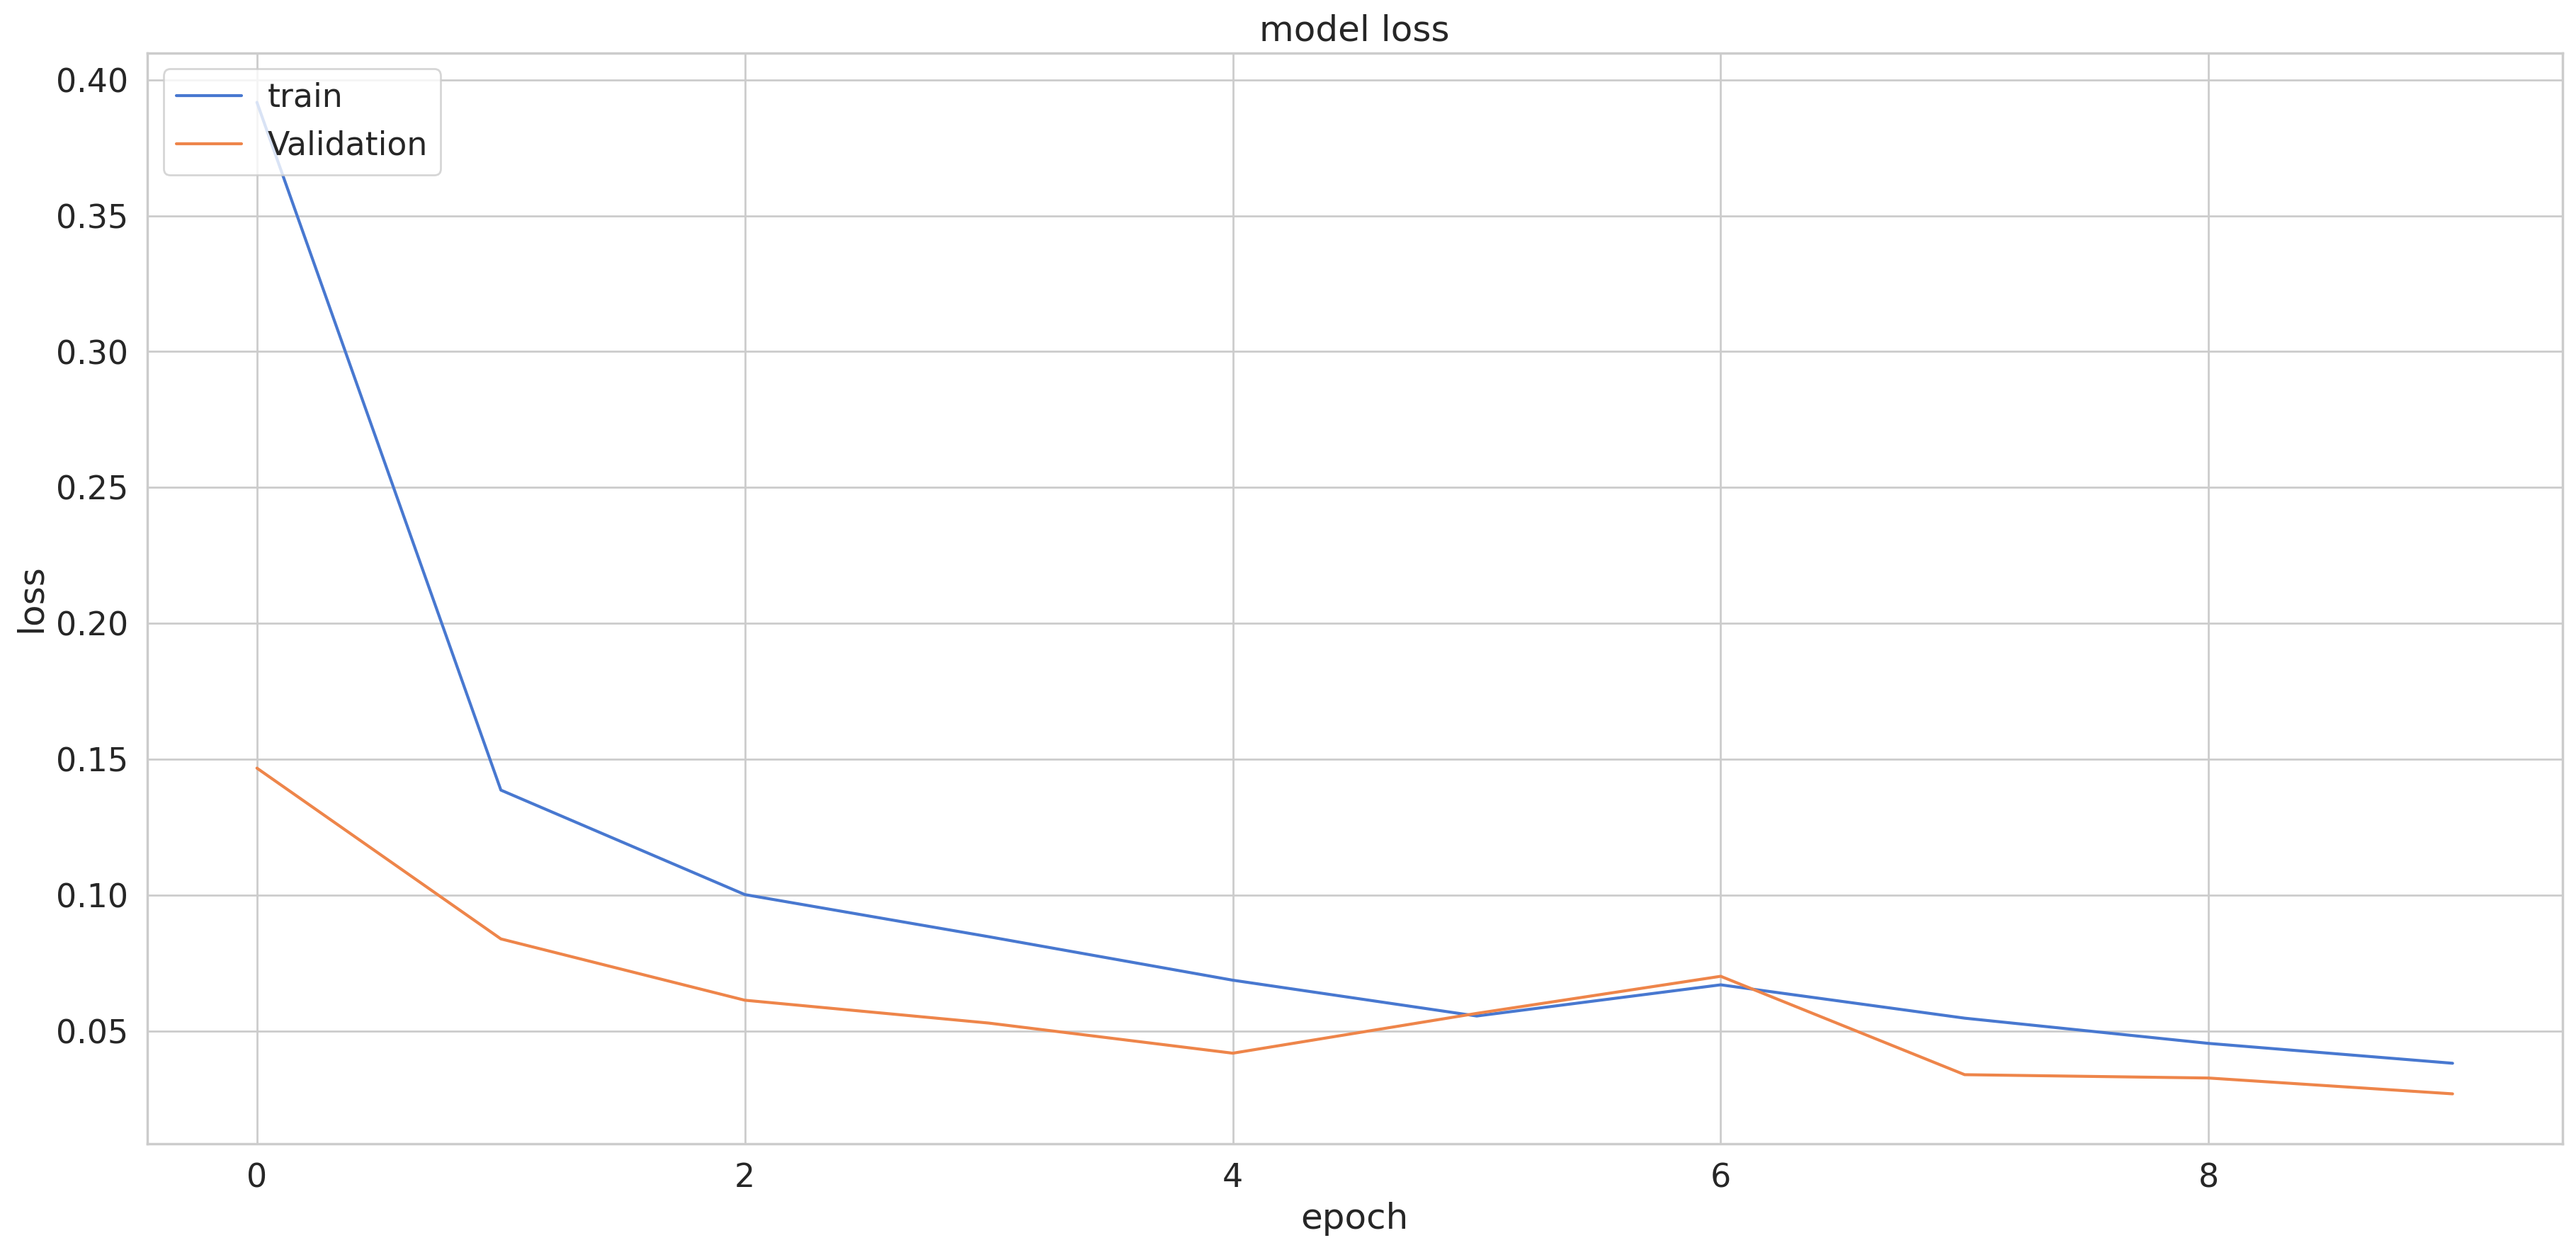

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

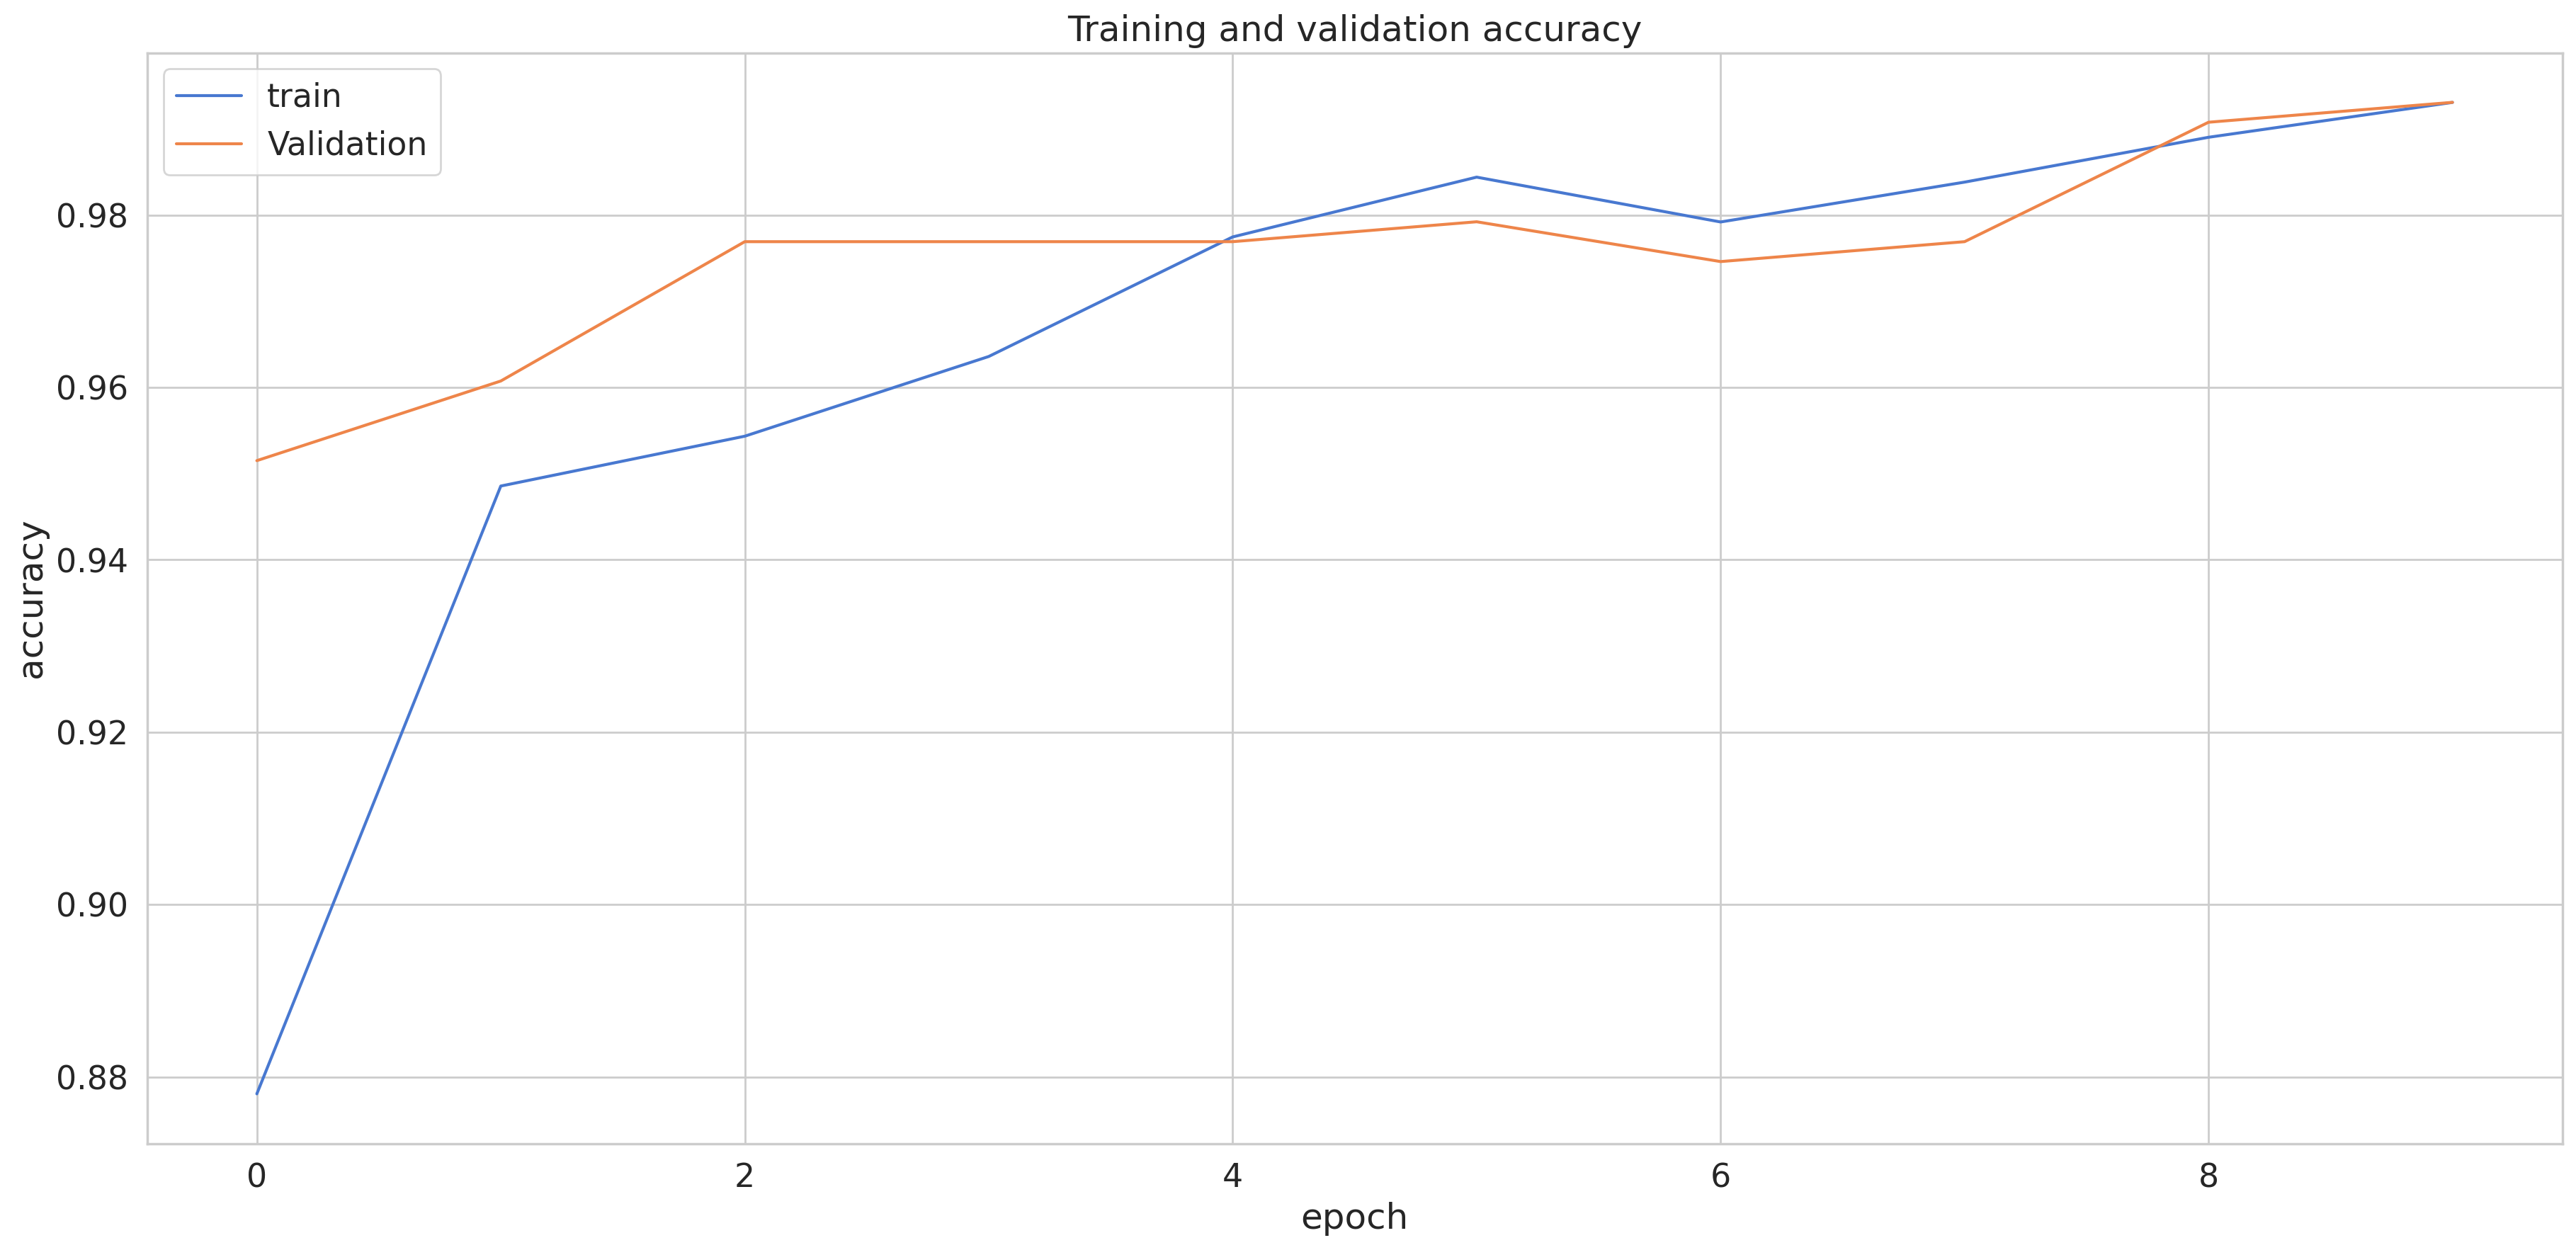

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

17/17 [==============================] - 1s 10ms/step
f1_score =  0.9833734411526609
0.9833641404805915
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       299
           1       0.98      0.99      0.98       242

    accuracy                           0.98       541
   macro avg       0.98      0.98      0.98       541
weighted avg       0.98      0.98      0.98       541



<Axes: >

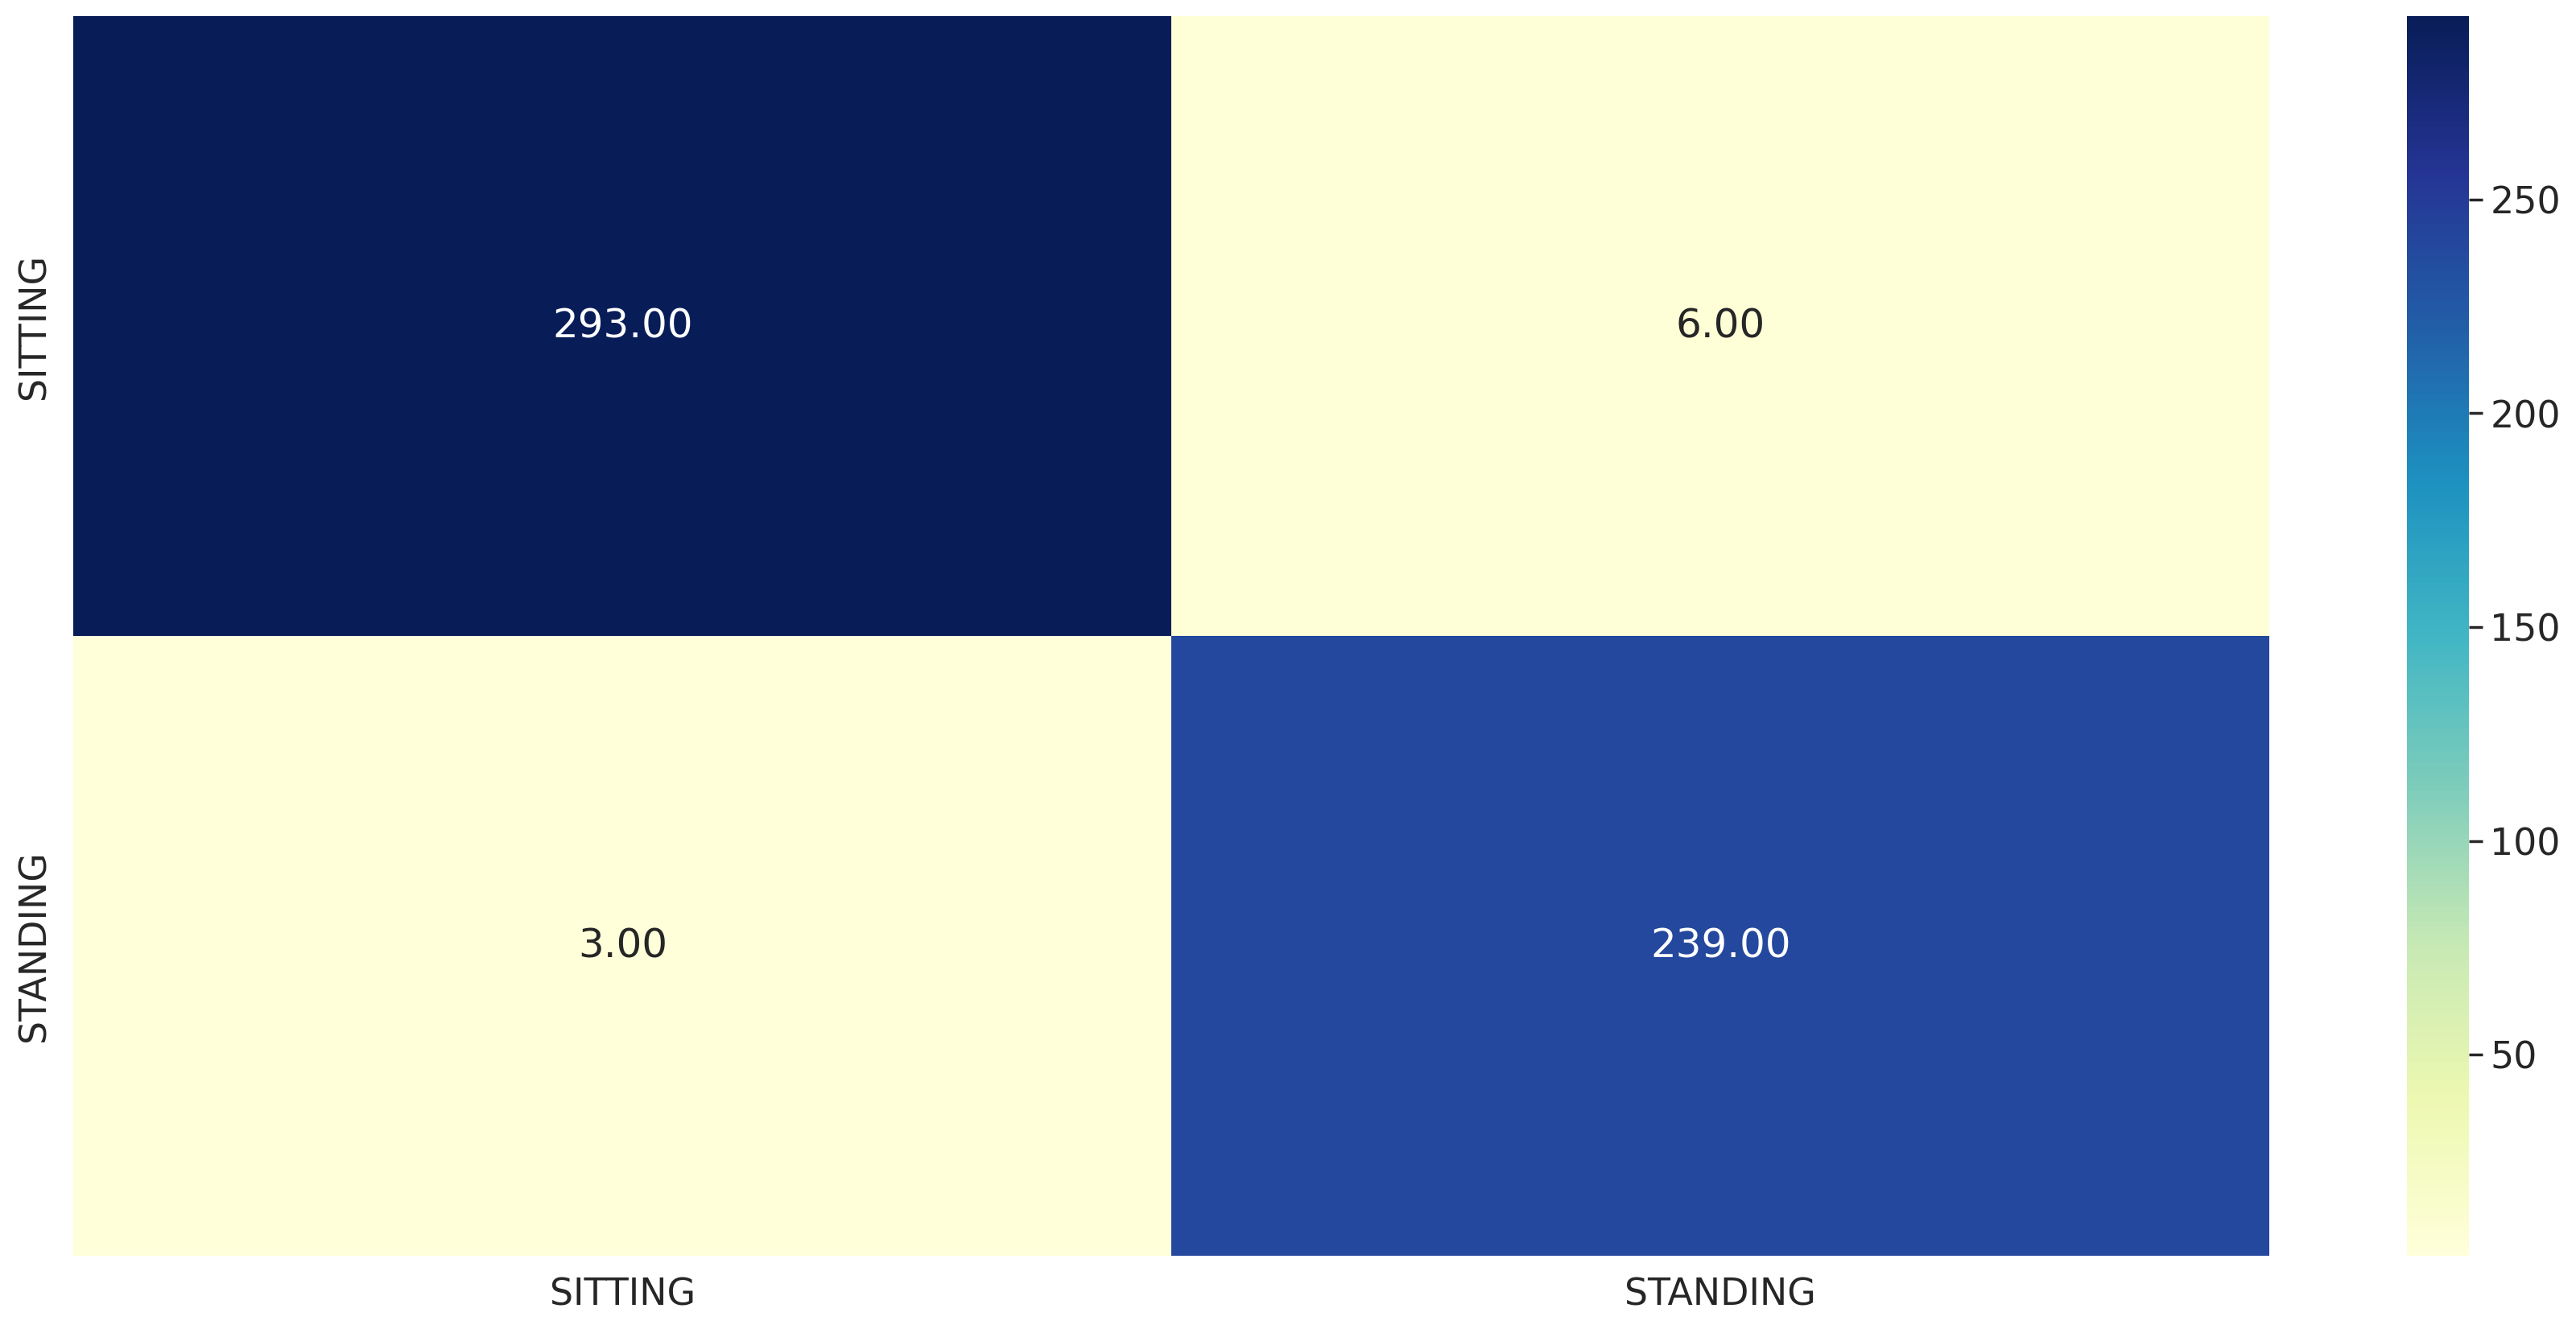

In [20]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['SITTING','STANDING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')


# CNN2 - LSTM3

In [21]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))




model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, None, 48, 64)      640       
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, None, 46, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, None, 46, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, None, 23, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, None, 1472)       

In [22]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
14/14 [==============================] - 7s 165ms/step - loss: 0.3989 - accuracy: 0.8751 - val_loss: 0.2008 - val_accuracy: 0.9423
Epoch 2/10
14/14 [==============================] - 1s 93ms/step - loss: 0.1695 - accuracy: 0.9497 - val_loss: 0.1200 - val_accuracy: 0.9630
Epoch 3/10
14/14 [==============================] - 1s 96ms/step - loss: 0.1107 - accuracy: 0.9566 - val_loss: 0.0718 - val_accuracy: 0.9584
Epoch 4/10
14/14 [==============================] - 2s 137ms/step - loss: 0.0938 - accuracy: 0.9532 - val_loss: 0.0649 - val_accuracy: 0.9723
Epoch 5/10
14/14 [==============================] - 2s 137ms/step - loss: 0.0871 - accuracy: 0.9595 - val_loss: 0.0628 - val_accuracy: 0.9607
Epoch 6/10
14/14 [==============================] - 2s 108ms/step - loss: 0.0840 - accuracy: 0.9642 - val_loss: 0.0573 - val_accuracy: 0.9769
Epoch 7/10
14/14 [==============================] - 1s 95ms/step - loss: 0.0691 - accuracy: 0.9746 - val_loss: 0.0489 - val_accuracy: 0.9746
Epoch 8/1

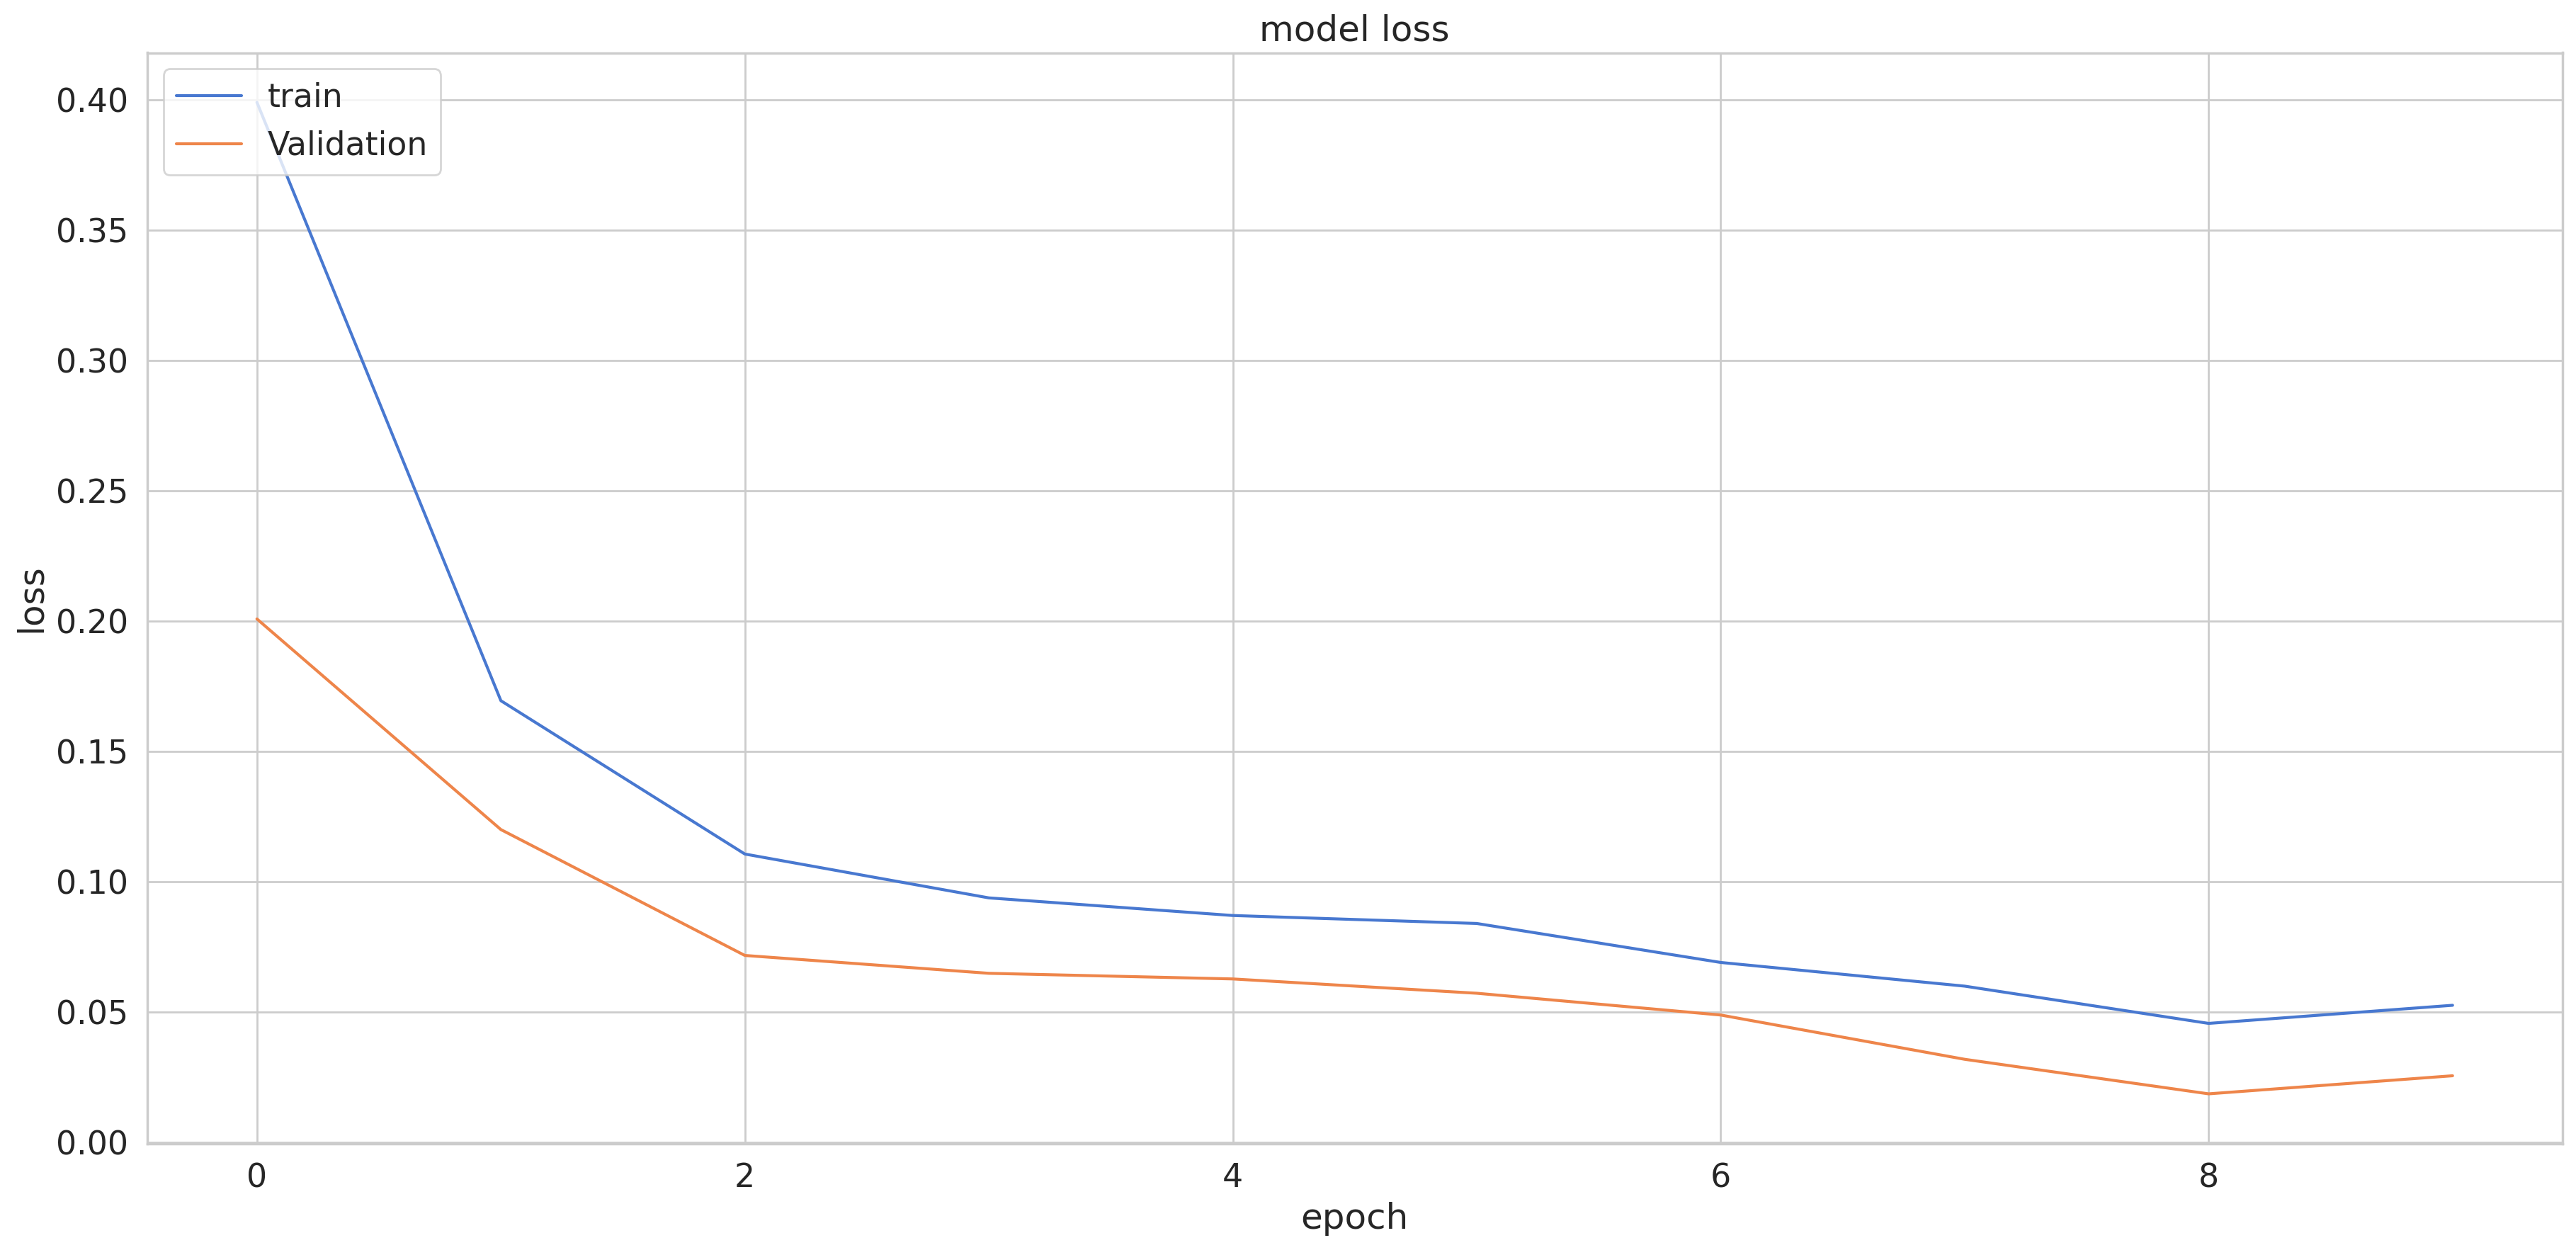

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

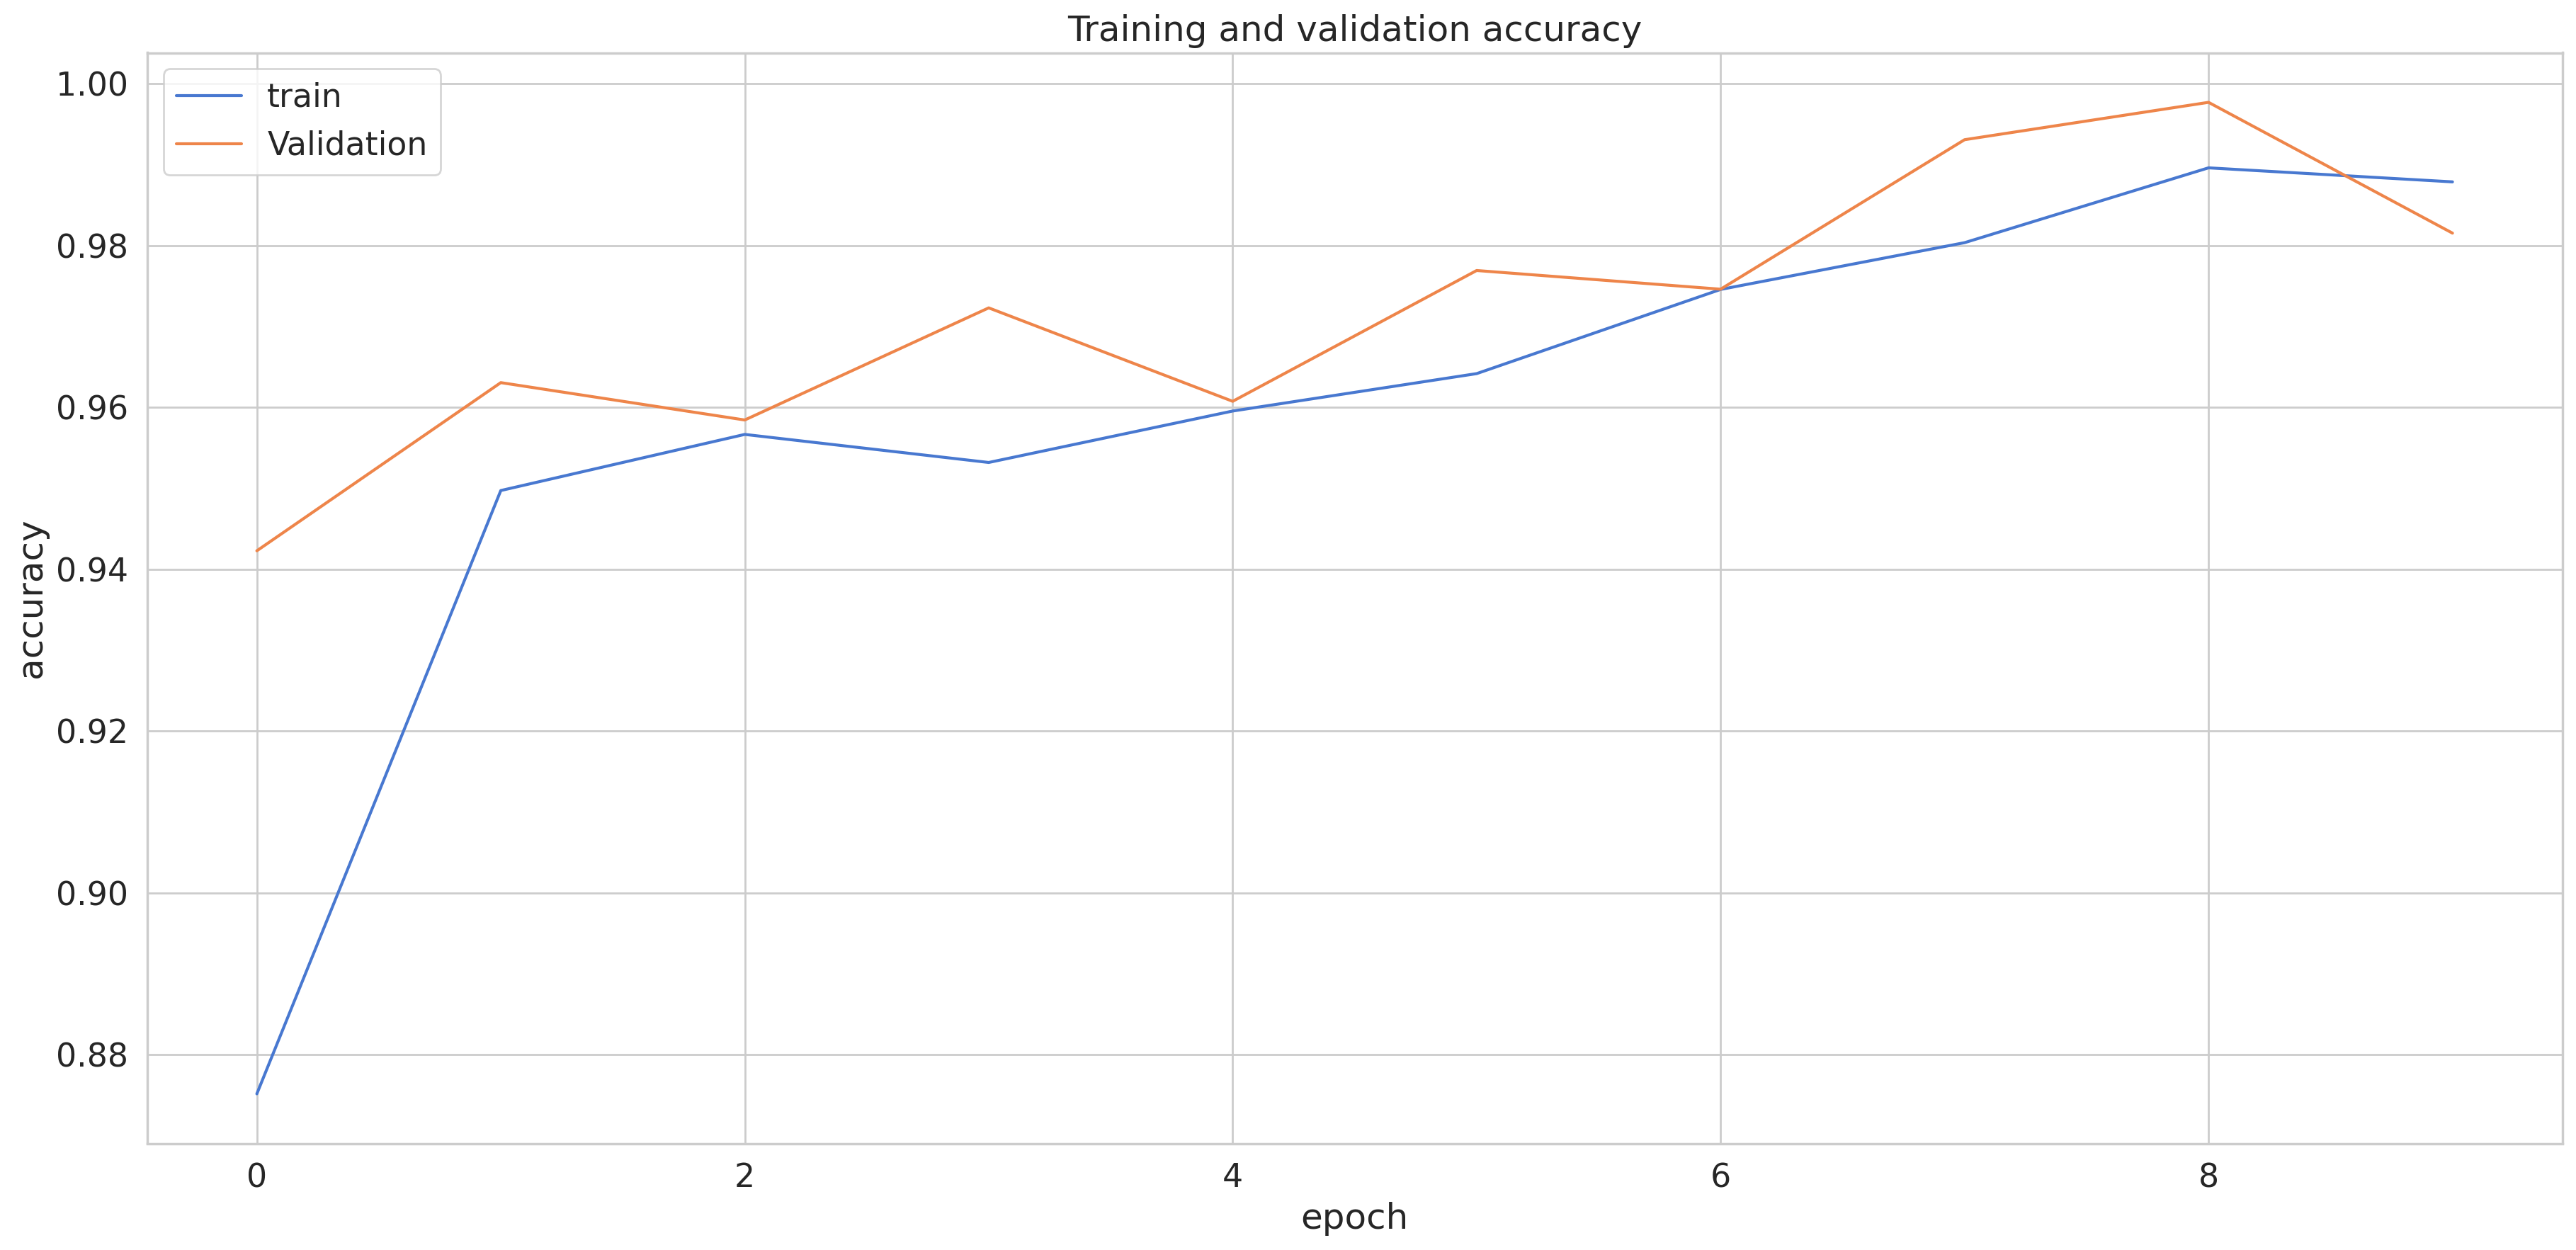

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

17/17 [==============================] - 1s 9ms/step
f1_score =  0.9741755617918971
0.9741219963031423
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       299
           1       0.95      1.00      0.97       242

    accuracy                           0.97       541
   macro avg       0.97      0.98      0.97       541
weighted avg       0.98      0.97      0.97       541



<Axes: >

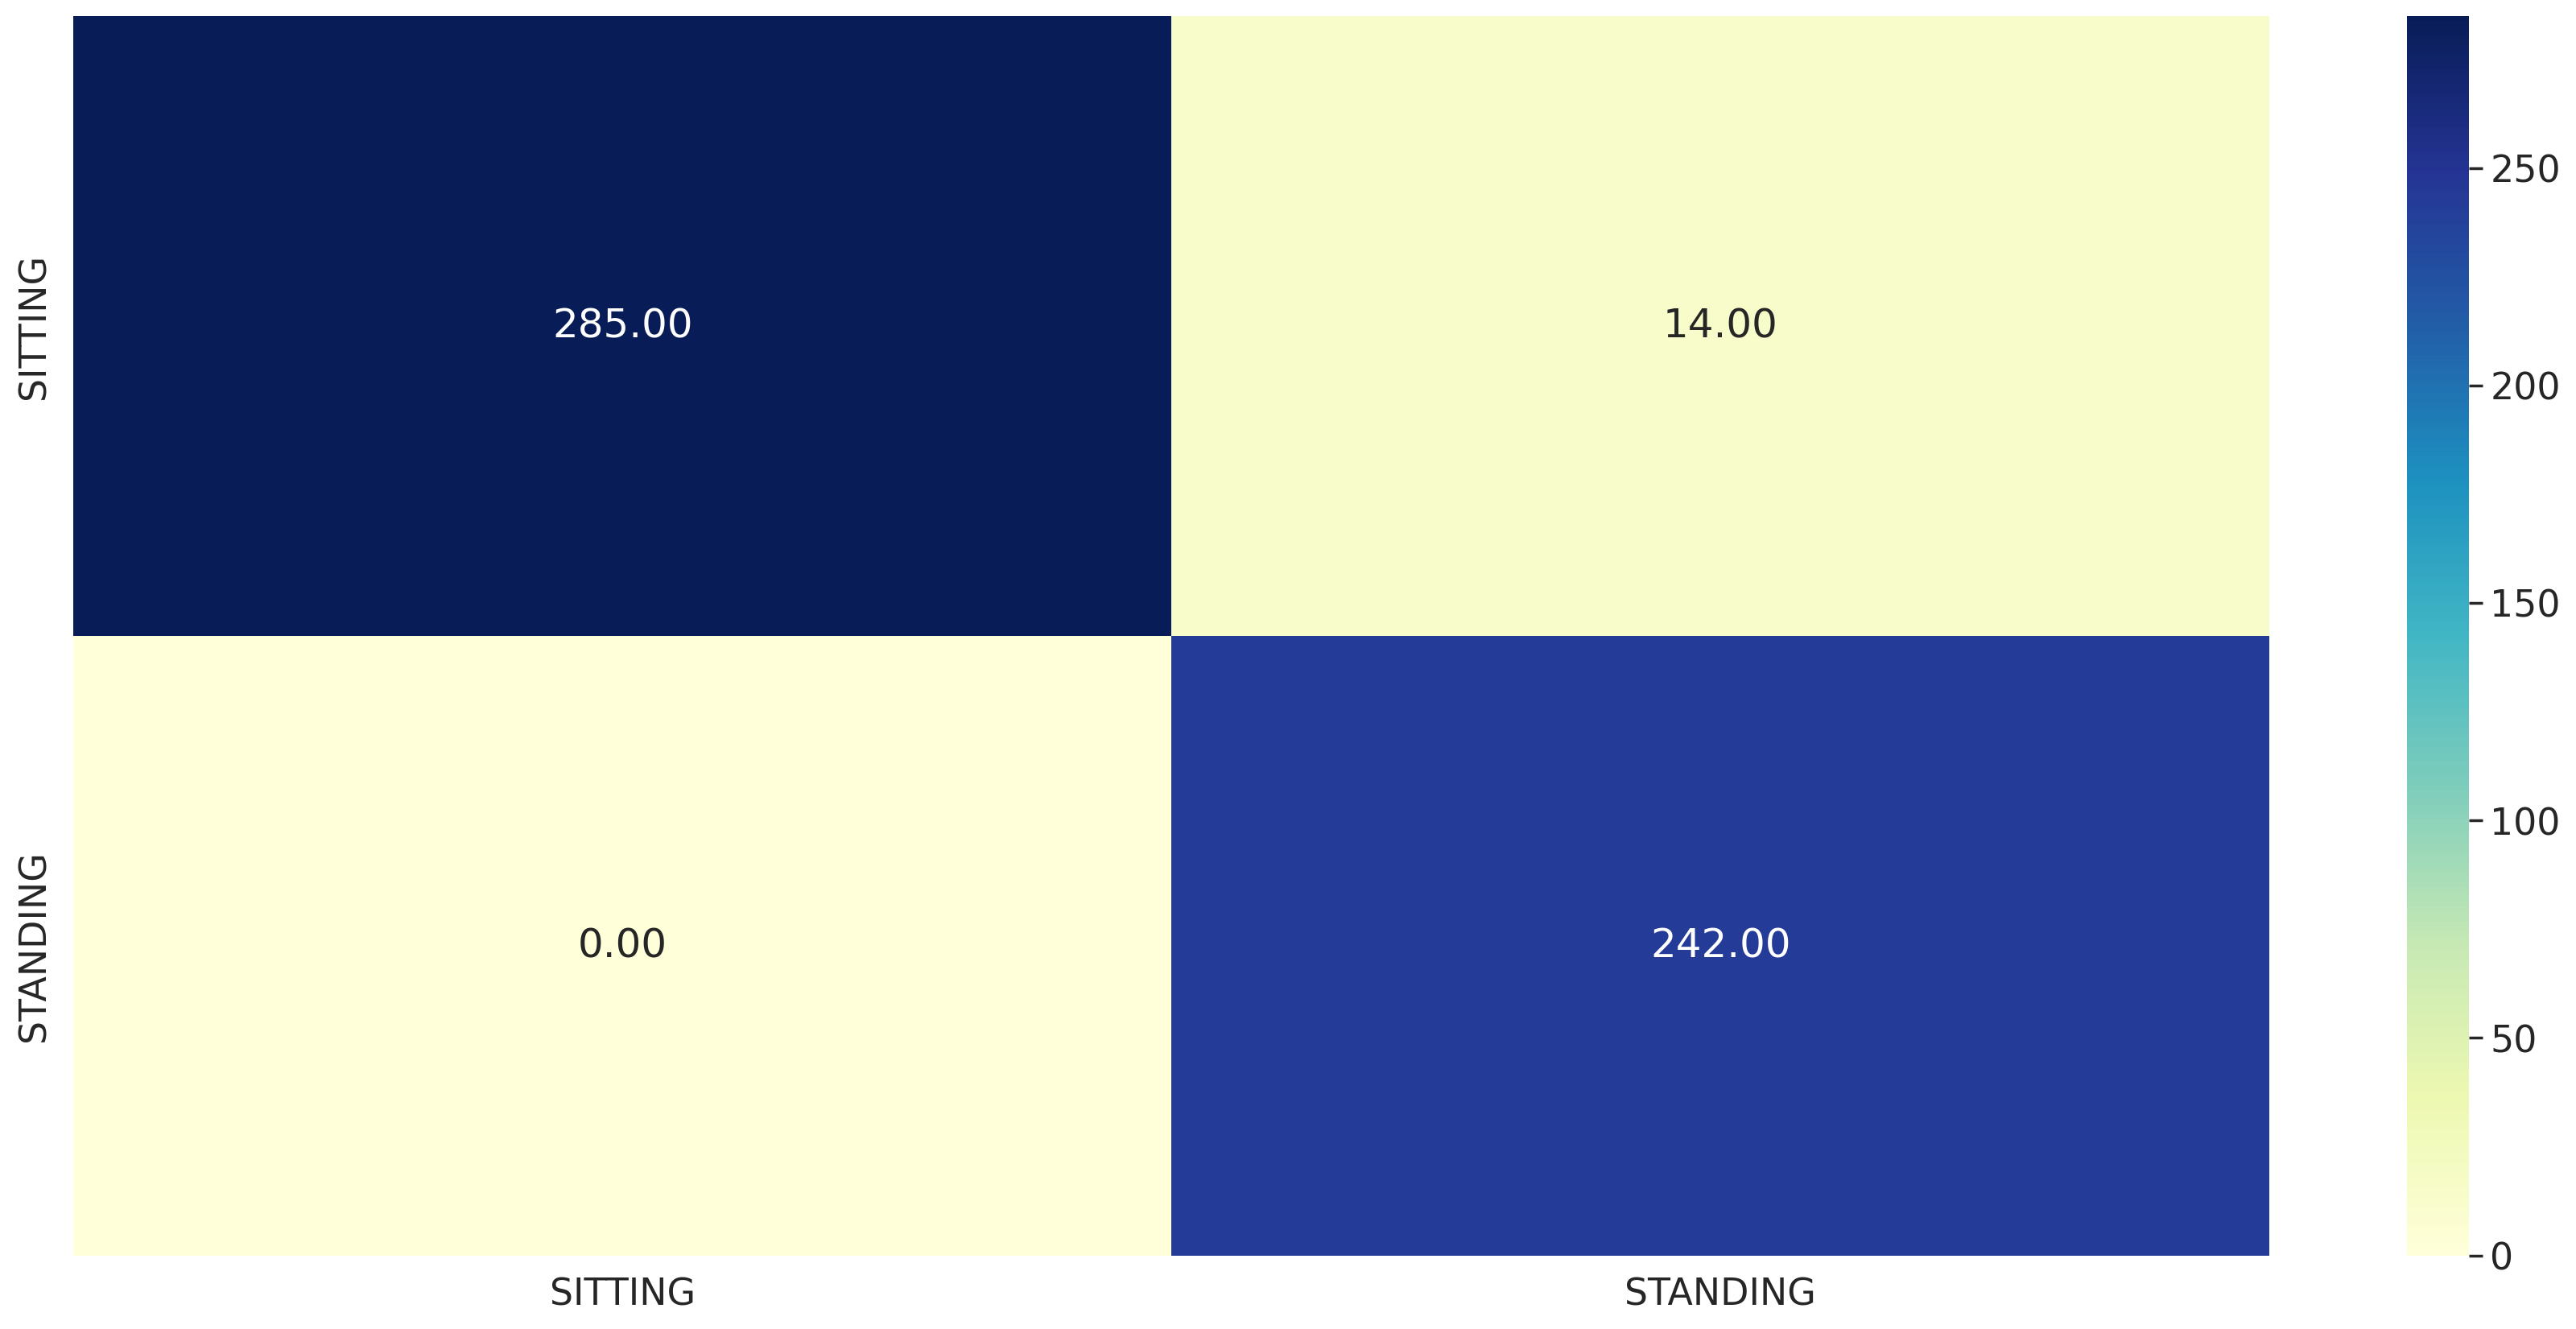

In [25]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['SITTING','STANDING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')


# CNN1 - LSTM4

In [26]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeD  (None, None, 48, 64)      640       
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, None, 48, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, None, 24, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, None, 1536)        0         
 istributed)                                                     
                                                                 
 lstm_5 (LSTM)               (None, None, 100)        

In [27]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/10
14/14 [==============================] - 9s 164ms/step - loss: 0.4727 - accuracy: 0.8509 - val_loss: 0.1855 - val_accuracy: 0.9492
Epoch 2/10
14/14 [==============================] - 1s 78ms/step - loss: 0.1916 - accuracy: 0.9434 - val_loss: 0.1455 - val_accuracy: 0.9561
Epoch 3/10
14/14 [==============================] - 1s 78ms/step - loss: 0.1397 - accuracy: 0.9526 - val_loss: 0.0904 - val_accuracy: 0.9630
Epoch 4/10
14/14 [==============================] - 2s 105ms/step - loss: 0.0977 - accuracy: 0.9595 - val_loss: 0.0646 - val_accuracy: 0.9769
Epoch 5/10
14/14 [==============================] - 1s 76ms/step - loss: 0.0812 - accuracy: 0.9682 - val_loss: 0.0455 - val_accuracy: 0.9792
Epoch 6/10
14/14 [==============================] - 1s 106ms/step - loss: 0.0701 - accuracy: 0.9751 - val_loss: 0.0329 - val_accuracy: 0.9792
Epoch 7/10
14/14 [==============================] - 2s 113ms/step - loss: 0.0617 - accuracy: 0.9792 - val_loss: 0.0296 - val_accuracy: 0.9954
Epoch 8/1

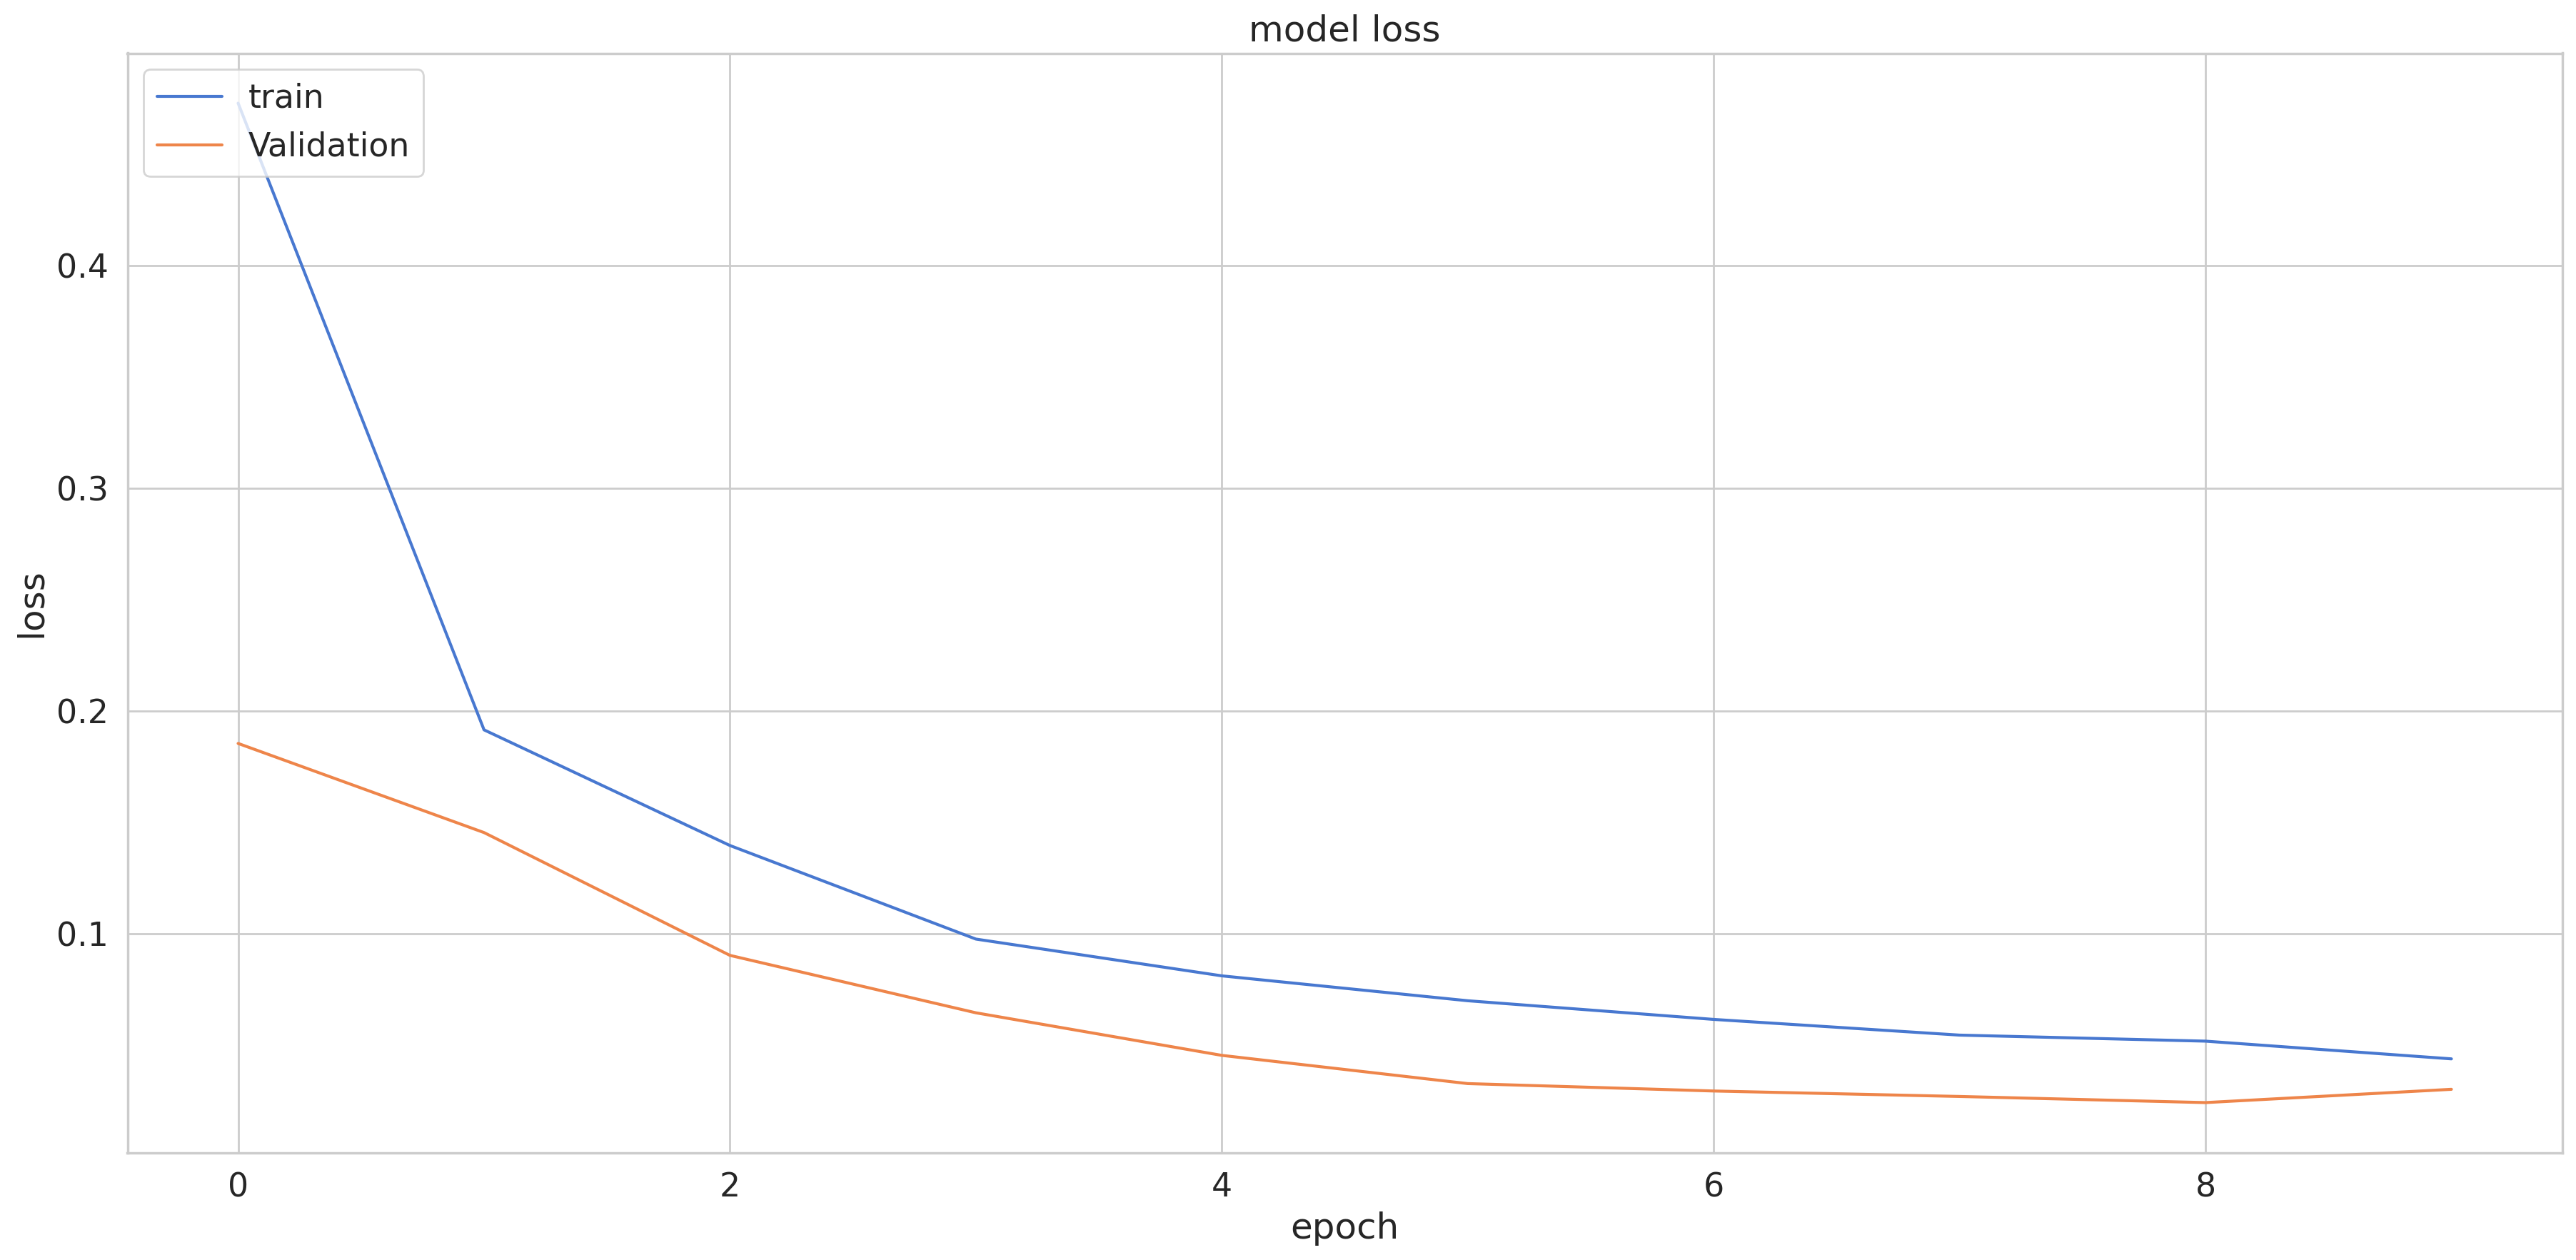

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

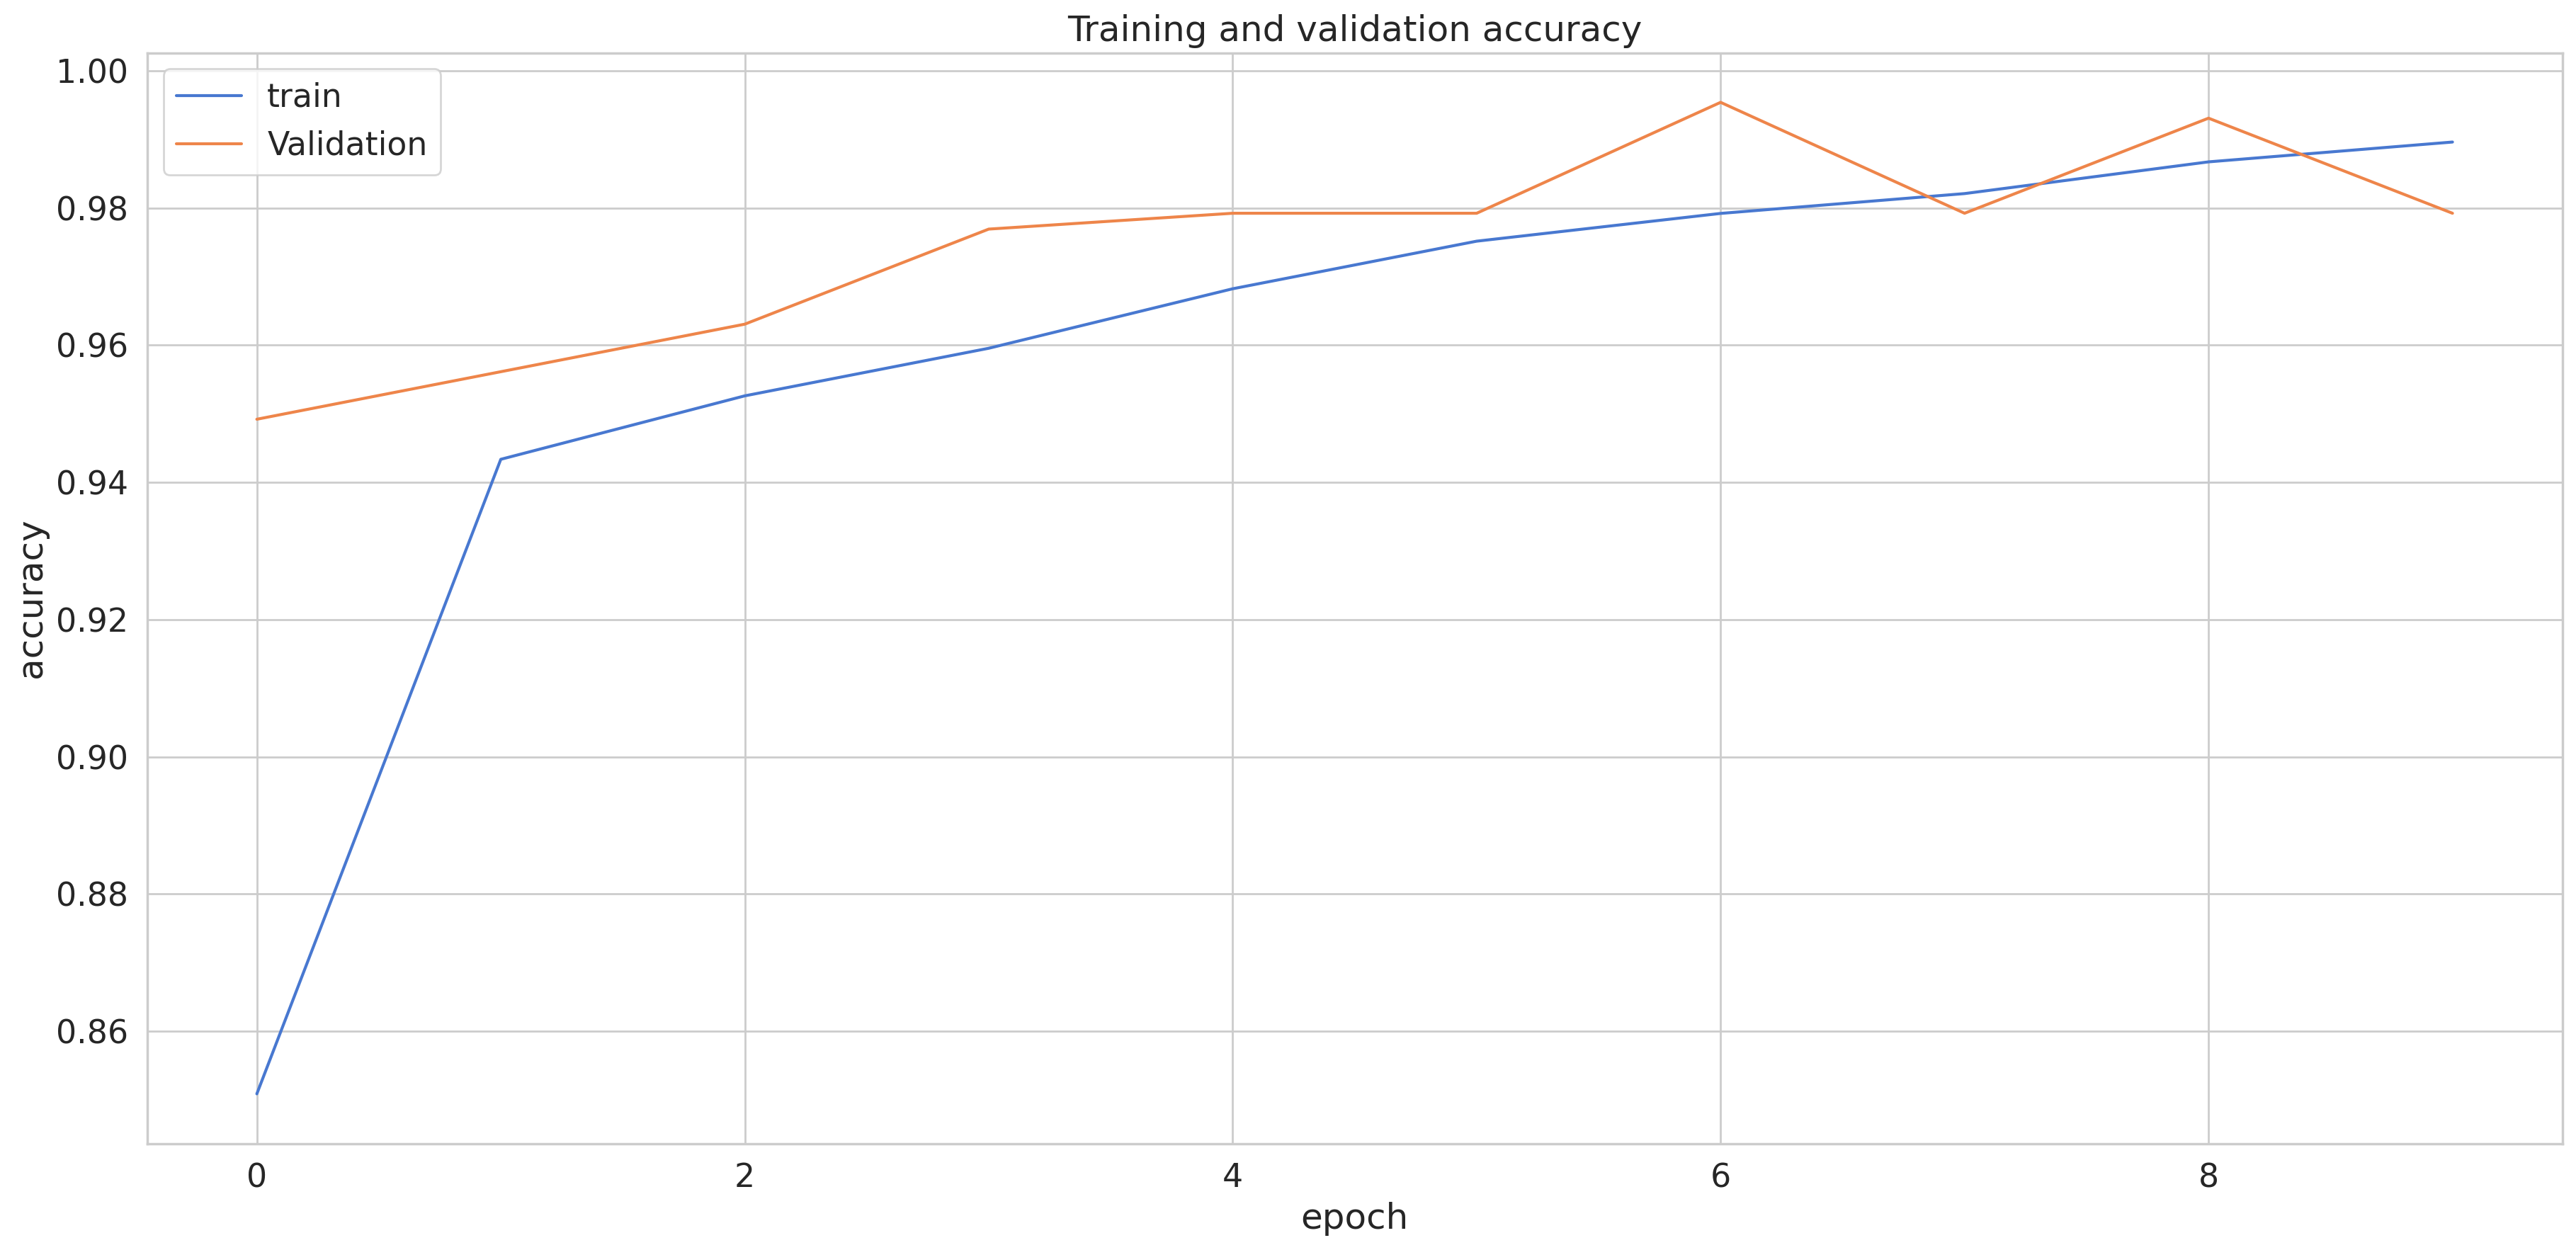

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

17/17 [==============================] - 1s 11ms/step
f1_score =  0.9631205562097331
0.9630314232902033
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       299
           1       0.93      1.00      0.96       242

    accuracy                           0.96       541
   macro avg       0.96      0.97      0.96       541
weighted avg       0.97      0.96      0.96       541



<Axes: >

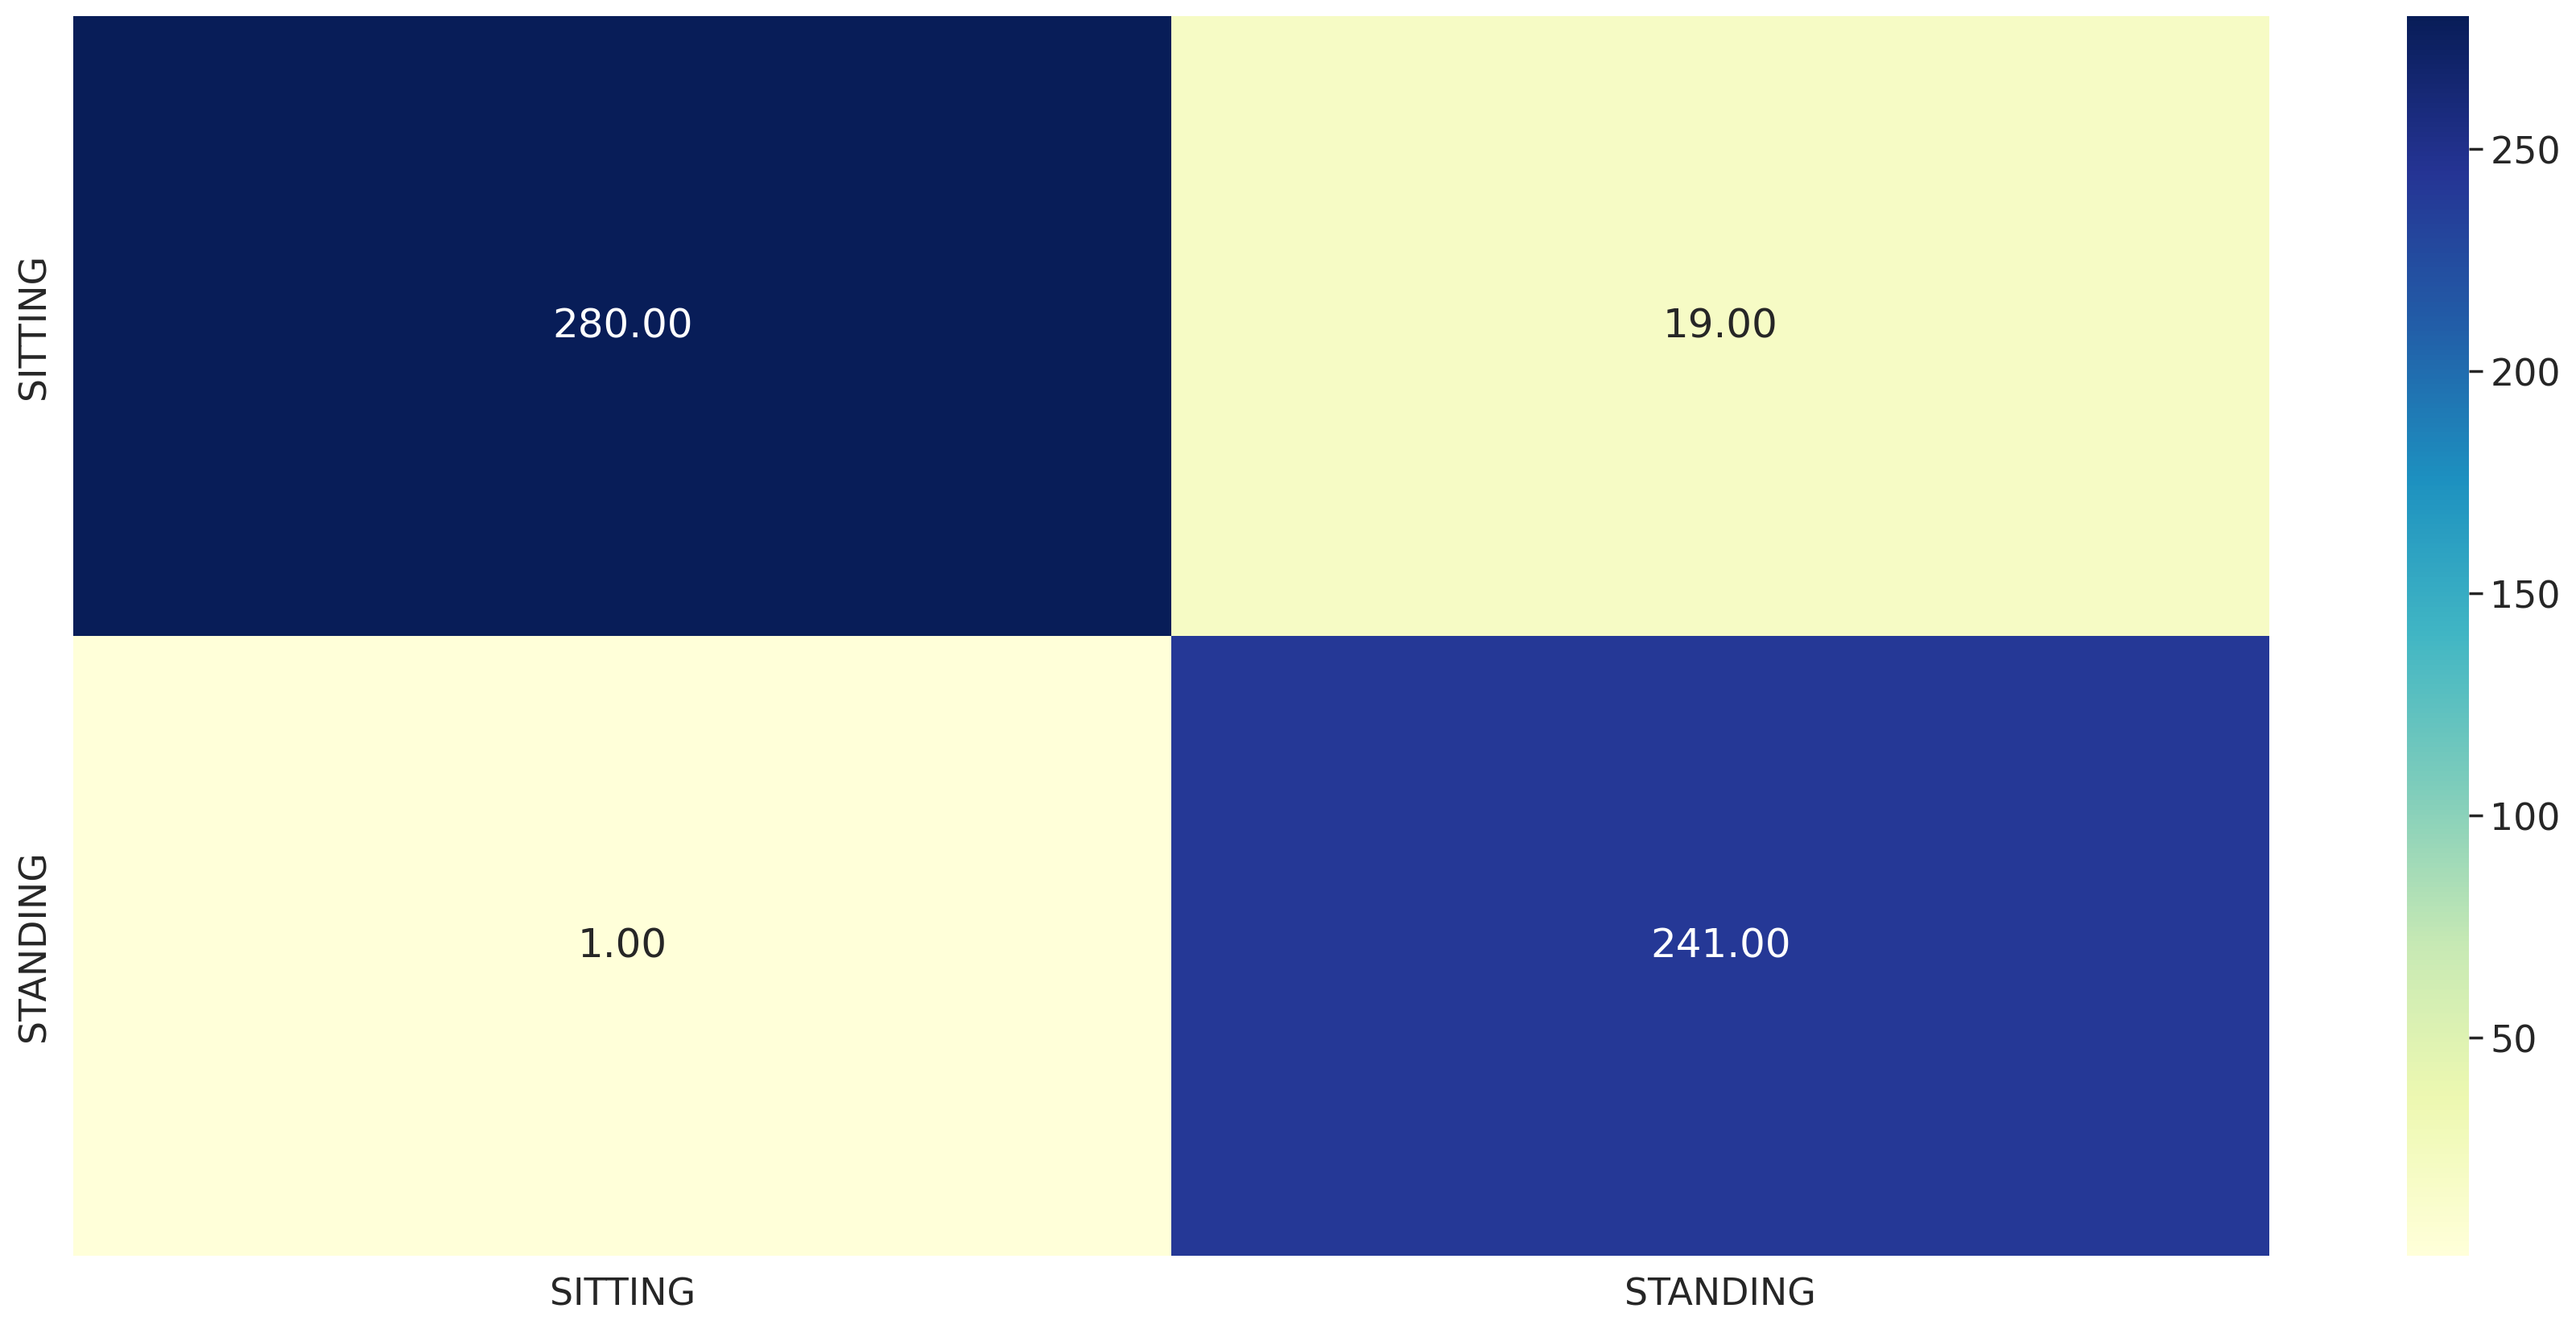

In [30]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['SITTING','STANDING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')
